# Key Project Strategy Simulator - Gaia

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate
import h5py

## Gaia Event Sky Locations

To start off with, let's start by simulating the set of Gaia events that we are likely to detect. 

The code skymap_events.py was previously used to map the events detected in Gaia Data Release 3 by Katarzyna, and convert this into a very rough map of event rate per year per HEALpixel (see code skymap_events.py).  This takes into account Gaia's time sampling, the distributions of stars, events and extinction, and Gaia's restricted limiting magnitude in crowded fields. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'gaia/gaia_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

gaia_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
gaia_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

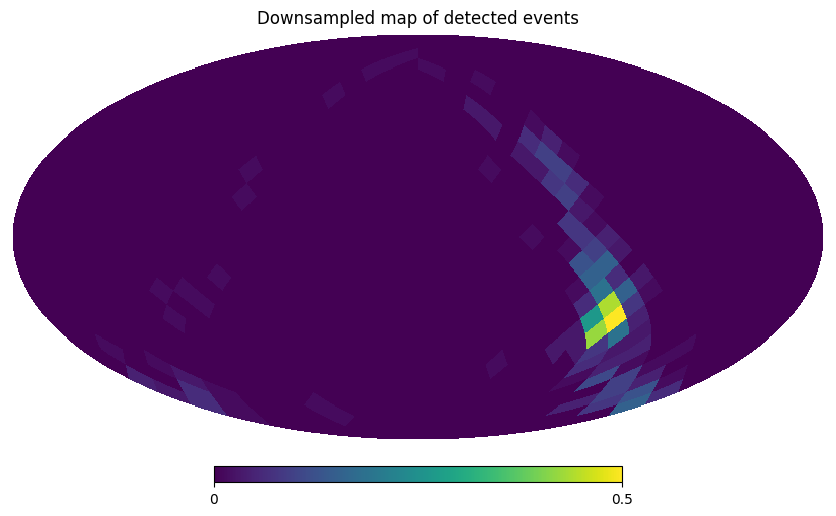

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(gaia_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

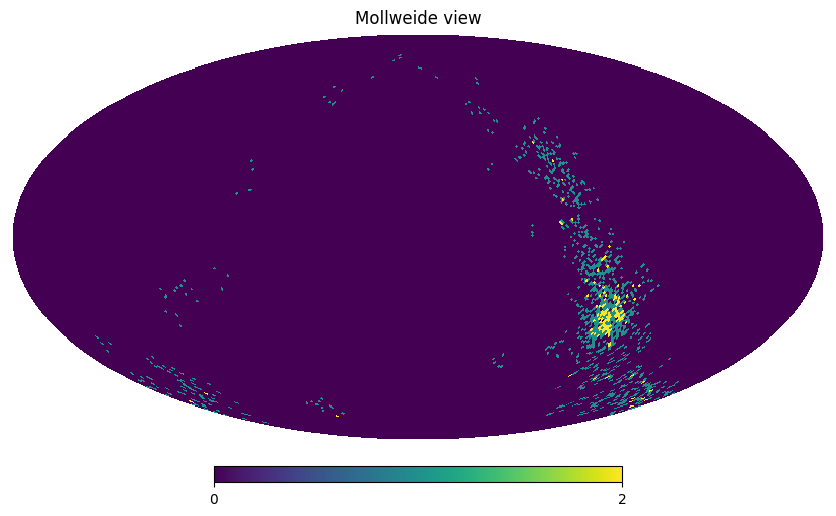

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = gaia_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (206.7857125, -58.919775)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (235.3125, -54.34091111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (146.7857125, -58.919775)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (231.54545417, -48.92279444)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (261.5625, -36.42357222)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -35.68533333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, -70.90666389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (191.571425, -64.19874444)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (150.78947083, -47.357575)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (146.25, -44.99387778)>"


## Gaia Event Baseline Magnitudes

Next we need to simulate the lightcurve data that Gaia would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by looking at the distribution of historic data from the Gaia Alerts system.  

In [8]:
def str2float(str):
    if len(str) > 0:
        return float(str)
    else:
        return -99.999

In [9]:
file_path = 'gaia/gaia_alerts_data.csv'
file_lines = open(file_path, 'r').readlines()
event_ids = []
data = []
for i,line in enumerate(file_lines):
    if i > 0:
        row = line.replace('\n','').split(',')
        event_ids.append(row[0])
        data.append([str2float(row[2]), str2float(row[3]), str2float(row[5]), str2float(row[6])])
data = np.array(data)

gaia_alert_table = Table([
                            Column(name="Event", data=event_ids, dtype='str'),
                            Column(name="RA", data=data[:,0], dtype='str'),
                            Column(name="Dec", data=data[:,1], dtype='str'),
                            Column(name="mag", data=data[:,2], dtype='float'),
                            Column(name="mag_error", data=data[:,3], dtype='float'),
                            ])
gaia_alert_table

Event,RA,Dec,mag,mag_error
str9,str32,str32,float64,float64
Gaia22epg,19.96019,-53.955,19.83,0.4
Gaia22epf,274.77416,-28.17701,19.55,0.05
Gaia22epe,273.40098,-29.60688,19.3,0.04
Gaia22epd,271.10083,-24.27362,18.34,0.36
Gaia22epc,14.69411,-56.98653,16.86,0.18
Gaia22epb,272.94736,-27.39745,18.11,0.06
...,...,...,...,...
Gaia14aag,219.14335,44.65261,18.42,0.02
Gaia14aaf,244.25381,62.00685,18.06,0.19


Text(0.5, 1.0, 'Distribution of baseline magnitudes of Gaia Alerts')

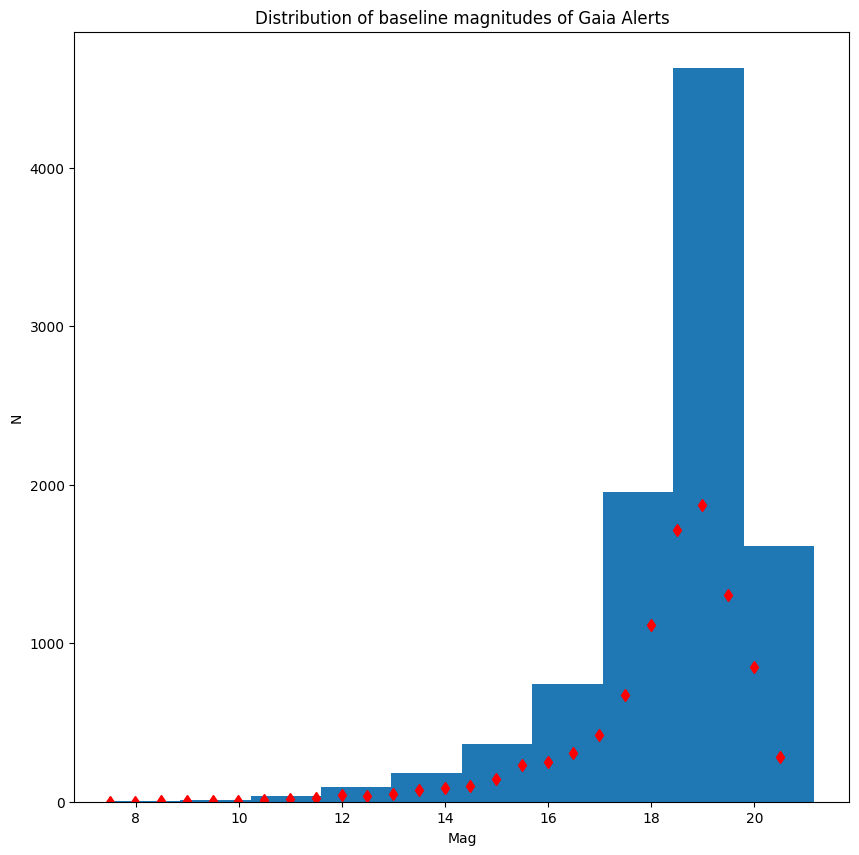

In [10]:
idx = np.where(gaia_alert_table['mag'] > 0.0)
mag_min = gaia_alert_table['mag'][idx].min()
mag_max = gaia_alert_table['mag'][idx].max()
(mag_dist, mag_bins) = np.histogram(gaia_alert_table['mag'][idx], bins=np.arange(mag_min, mag_max, 0.5))


fig = plt.figure(1,(10,10))
plt.hist(gaia_alert_table['mag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of Gaia Alerts')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for Gaia detections

Text(0.5, 1.0, 'Distribution of simulated Gaia detections')

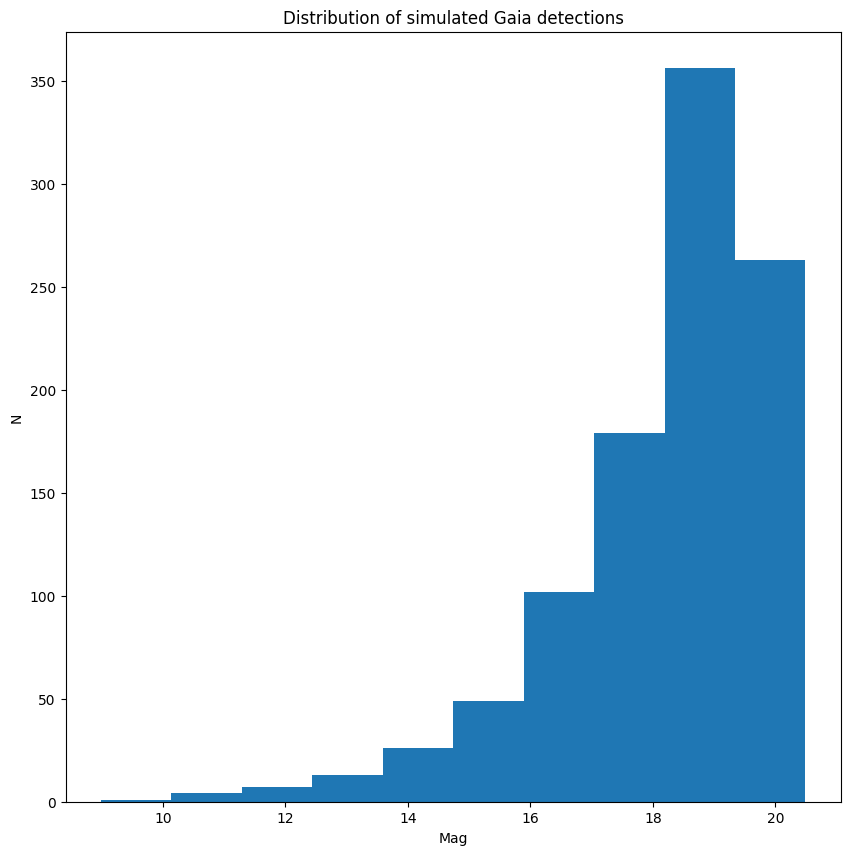

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated Gaia detections')

## Gaia Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the overlap between the Key Project (2023-2026) and Gaia's expected dates of operation (2023-2025):

In [12]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2460887.5000

In [13]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [14]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

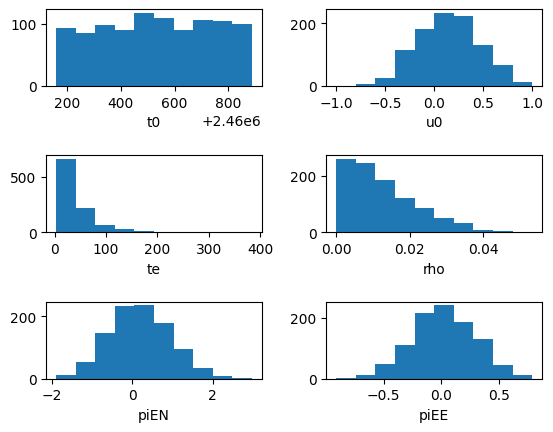

In [15]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

For ease of handling, let's combine these data into a single events table

In [16]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('GaiaSim'+roundID(x))

In [17]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,45636,"<SkyCoord (ICRS): (ra, dec) in deg\n (206.7857125, -58.919775)>",19.490000000000002,2460249.874704935,-0.09481753772714355,35.232861194558055,0.027390460452340885,-0.3177155235842072,-0.0034055510920603382,0.0
GaiaSim00002,44573,"<SkyCoord (ICRS): (ra, dec) in deg\n (235.3125, -54.34091111)>",18.990000000000002,2460608.659205467,-0.2583166977934087,50.01244761695013,0.01067954573450122,1.3582715946823956,0.23757512172162887,0.0
GaiaSim00003,45608,"<SkyCoord (ICRS): (ra, dec) in deg\n (146.7857125, -58.919775)>",19.490000000000002,2460782.672698673,0.23909077886474767,24.985497589958126,0.004760415361235304,-0.15496188168071146,0.44519617971169356,0.0
GaiaSim00004,43133,"<SkyCoord (ICRS): (ra, dec) in deg\n (231.54545417, -48.92279444)>",19.490000000000002,2460863.264270333,0.18720506218893357,82.44677097926667,0.025358246642173628,1.2201713604799262,-0.332343729613855,0.0
GaiaSim00005,39226,"<SkyCoord (ICRS): (ra, dec) in deg\n (261.5625, -36.42357222)>",18.490000000000002,2460230.3749628696,-0.16333739378438375,55.47433047713222,0.010439919308857647,0.9417592033270177,-0.06469118163754428,0.0
GaiaSim00006,38975,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -35.68533333)>",19.490000000000002,2460565.2111460087,0.31043393900995664,17.3927598833422,0.01194934126616819,0.8279490408951036,-0.47545383506536226,0.0
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,45961,"<SkyCoord (ICRS): (ra, dec) in deg\n (201.375, -60.43443611)>",19.490000000000002,2460546.99814566,0.2553064077101475,30.263829920520703,0.016006475931271323,1.4568461980536944,0.0907621225635497,0.0
GaiaSim00995,45955,"<SkyCoord (ICRS): (ra, dec) in deg\n (187.875, -60.43443611)>",18.490000000000002,2460454.285200135,0.544520204921526,26.701468358128892,0.011789167337018498,0.5032395338507893,0.5217387822530148,0.0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for Gaia events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of Gaia events. 



## Gaia Event Lightcurve sampling

In order to generate realistic Gaia lightcurves, we take into account the non-uniform map of visits that results from Gaia's scanning law. We read in this data, which was resampled using the gaia/gaia_scanning_law notebook, and output to file gaia/gaia_dr3_nvisits_34months.fits.  Since Gaia is expected to continue operating for 24months during the Key  Project, we scale the expected number of visits per HEALpixel accordingly.  

In [18]:
gaia_duration = 34*30.0
gaia_kp_overlap = 365.24*2.0
scale_factor = gaia_kp_overlap / gaia_duration
scale_factor

0.716156862745098

In [19]:
map_file_path = 'gaia/gaia_dr3_nvisits_34months.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

gaia_nvisits = Table([
                        Column(name="HP", data=data_table['hp_index'], dtype='int'),
                        Column(name="nvisits", data=data_table['nvisits']*scale_factor, dtype='int'),
                        ])
gaia_nvisits

HP,nvisits
int64,int64
1,221
2,226
3,219
4,219
5,232
6,222
...,...
49146,224
49147,230


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [20]:
events_table['nvisits'] = gaia_nvisits['nvisits'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,int64
GaiaSim00001,45636,"<SkyCoord (ICRS): (ra, dec) in deg\n (206.7857125, -58.919775)>",19.490000000000002,2460249.874704935,-0.09481753772714355,35.232861194558055,0.027390460452340885,-0.3177155235842072,-0.0034055510920603382,445
GaiaSim00002,44573,"<SkyCoord (ICRS): (ra, dec) in deg\n (235.3125, -54.34091111)>",18.990000000000002,2460608.659205467,-0.2583166977934087,50.01244761695013,0.01067954573450122,1.3582715946823956,0.23757512172162887,186
GaiaSim00003,45608,"<SkyCoord (ICRS): (ra, dec) in deg\n (146.7857125, -58.919775)>",19.490000000000002,2460782.672698673,0.23909077886474767,24.985497589958126,0.004760415361235304,-0.15496188168071146,0.44519617971169356,241
GaiaSim00004,43133,"<SkyCoord (ICRS): (ra, dec) in deg\n (231.54545417, -48.92279444)>",19.490000000000002,2460863.264270333,0.18720506218893357,82.44677097926667,0.025358246642173628,1.2201713604799262,-0.332343729613855,203
GaiaSim00005,39226,"<SkyCoord (ICRS): (ra, dec) in deg\n (261.5625, -36.42357222)>",18.490000000000002,2460230.3749628696,-0.16333739378438375,55.47433047713222,0.010439919308857647,0.9417592033270177,-0.06469118163754428,129
GaiaSim00006,38975,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -35.68533333)>",19.490000000000002,2460565.2111460087,0.31043393900995664,17.3927598833422,0.01194934126616819,0.8279490408951036,-0.47545383506536226,134
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,45961,"<SkyCoord (ICRS): (ra, dec) in deg\n (201.375, -60.43443611)>",19.490000000000002,2460546.99814566,0.2553064077101475,30.263829920520703,0.016006475931271323,1.4568461980536944,0.0907621225635497,303
GaiaSim00995,45955,"<SkyCoord (ICRS): (ra, dec) in deg\n (187.875, -60.43443611)>",18.490000000000002,2460454.285200135,0.544520204921526,26.701468358128892,0.011789167337018498,0.5032395338507893,0.5217387822530148,249


Store the table of simulated event parameters

In [21]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_events_table.fits', overwrite=True)


## Gaia Event Lightcurves

Now we can simulate the lightcurves that Gaia would produce for these simulated events.  Although the scanning law data does not tell us the distribution of visits over the 34 months included in Gaia DR3, it is a regularly repeating function with a non-varying scan from a space-based facility.  The sampling isn't uniform, but we approximate it here as uniform, since experiments with the Gaia scanninglaw package failed due to out of date documentation.  

In [22]:
def add_gaia_g_noise(mag):
    """Code by Markus Hundertmark
    """
    a1 = 0.2
    b1 = -5.3 #-5.2
    a2=0.2625
    b2= -6.3625 #-6.2625

    mag_obs_list = []
    magerr_list = []

    for value in mag:
        log_err1 = a1*value + b1
        log_err2 = a2*value + b2
        if (value < 13.5):
            magerr = 10**(a1*13.5+b1)
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if value>=13.5 and value<17:
            magerr = 10**log_err1
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if (value>=17):
            magerr = 10**log_err2
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        #this works until 21 mag.
    return np.array(mag_obs_list), np.array(magerr_list)

In [23]:
def simulate_event_gaia(event_params, start_date, end_date, horizons_table, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps
    cadence = (end_date - start_date) / event_params['nvisits']
    timestamps = np.arange(start_date, end_date, cadence)
    
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude, with fixed photometric uncertainties, 
    # since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel.spacecraft_positions = spacecraft_positions
    
    sim_event.telescopes.append(tel)
    sim_event.find_survey('Gaia')
    
    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]
        
    sim_model.define_model_parameters()
    
    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
    tel = sim_model.event.telescopes[0]
    
    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    #print(event_params)
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
    (lightcurve[:,1],lightcurve[:,2]) = add_gaia_g_noise(lightcurve[:,1])
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
    
    return sim_event, sim_model, lensing_parameters

In order to implement parallax for Gaia events, we use the projected vector locations of the spacecraft, as generated by JPL Horizons, and output to an ASCII table which can be read from file.  
The JPL Horizons configuration used to generate this table is:
* Ephemeris type: Vector table
* Target body: Gaia (spacecraft)
* Coordinate center: Solar System Barycenter SSB [500@0]
* Time: 2023-01-01 to 2026-08-30, increments of 1 day (duration of Key Project)
* Table settings: default

However, this appears not to be the format required to calculate the observed location of the spacecraft.  Instead it needs the RA, Dec position, meaning that the observer table format is required, with the following options:
* Astrometric RA & Dec
* Rates RA & Dec
* Airmass and extinction (required)
* Visual mag & surface brightness
* Heliocentric range and range rate
* Observer range and range rate
* Sun-Observer-Target ELONG angle
* Sun-Target-Observer PHASE angle
* Local apparent hour angle
* Sky motion
* Lunar sky brightness

In [24]:
gaia_vector_table_file = './gaia/jplhorizons_observer_table.txt'

horizons_table = jplhorizons_utils.parse_JPL_Horizons_table(horizons_file_path=gaia_vector_table_file, 
                                                                   table_type='OBSERVER')
horizons_table

Date,RA,Dec,Delta,JD
bytes16,float64,float64,float64,float64
2023-Jan-01T00:0,101.31470833333333,22.988694444444445,0.99424530711027,2459945.5
2023-Jan-02T00:0,102.41991666666667,22.90411111111111,0.99437003596059,2459946.5
2023-Jan-03T00:0,103.52370833333335,22.811972222222224,0.99450009481111,2459947.5
2023-Jan-04T00:0,104.625875,22.712305555555556,0.9946354327103,2459948.5
2023-Jan-05T00:0,105.72629166666665,22.605194444444447,0.99477599538272,2459949.5
2023-Jan-06T00:0,106.82491666666667,22.49063888888889,0.99492172842485,2459950.5
...,...,...,...,...
2026-Aug-22T00:0,330.5357916666667,-12.060194444444445,1.02354688405442,2461274.5
2026-Aug-23T00:0,331.45425,-11.725111111111111,1.02327762396697,2461275.5


In [25]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

gaia_lens, gaia_lens_model, lens_model_pars = simulate_event_gaia(events_table[event_number], start_date, end_date, horizons_table, parallax=True)

Picked bright event:  7  baseline_mag= 17.490000000000002 mag
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47759281391603


Simulate all events

In [26]:
sim_gaia_lenses = []
sim_gaia_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (gaia_lens, gaia_lens_model, lens_model_pars) = simulate_event_gaia(events_table[ievent], start_date, end_date, horizons_table, parallax=True)
    sim_gaia_lenses.append(gaia_lens)
    sim_gaia_lens_models.append(gaia_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.4700892927969
0 [2460249.874704935, -0.09481753772714355, 35.232861194558055, 0.027390460452340885, -0.3177155235842072, -0.0034055510920603382]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.956955358796726
1 [2460608.659205467, -0.2583166977934087, 50.01244761695013, 0.01067954573450122, 1.3582715946823956, 0.23757512172162887]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.4670849500322
2 [2460782.672698673, 0.23909077886474767, 24.985497589958126, 0.004760415361235304, -0.15496188168071146, 0.44519617971169356]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.424115740013054
3 [2460863.264270333, 0.18720506218893357, 82.44677097926667, 0.025358246642173628, 1.220

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.463339242971557
35 [2460609.4483442944, -0.38217049856673113, 28.624085370864012, 0.00918845028303655, 0.8272659030987068, -0.08511812465483753]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.471143270469604
36 [2460563.912186618, 0.3338509018282371, 48.72107691778739, 0.017054923179216298, -0.19143053441231922, 0.054667467905528996]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.982201512771375
37 [2460679.1511576017, -0.2752679233187617, 20.5990453113831, 0.0008690626929054937, 0.002360333611054033, 0.3663461074581226]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987192354971775
38 [2460297.4912280967, 0.1439795445353922, 21.75536096178377, 0.015542708506951575, 0.3425787820653569, -0.3052521790094

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.980875347688993
68 [2460507.852689866, 0.06833212018370655, 17.62359088501773, 0.010073652706879564, 0.38601588787405117, 0.34011102410801264]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.484724242928813
69 [2460549.2991231685, 0.17126550515752256, 9.522946004774735, 0.00739729324207712, 0.3331051147151318, -0.42384525298602355]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.474033924447745
70 [2460605.6667006216, -0.09260666812014234, 25.30838910342801, 0.006502268853830291, -0.8570459805006367, -0.3358611671756119]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.9879631194728
71 [2460589.107554942, -0.03218037565049245, 14.995580536195488, 0.0021226924118896897, -0.20854275973893194, 0.5732442667583

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.495488978832714
104 [2460840.0195100205, -0.19730680804958386, 5.647704590907191, 0.03373054157126946, -1.0317716849842373, -0.5602171305031133]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.482812188763468
105 [2460563.1675811685, 0.16064085592405736, 25.036288713924264, 0.023228202995732562, -0.3014354487895838, 0.38105074878280915]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.46697914065136
106 [2460883.658960008, -0.032648947649802806, 65.0192495366732, 0.005626273266316185, 0.2065681608676909, 0.32939121217989187]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.979272606174014
107 [2460218.1494121486, 0.6885628097124642, 48.39634956849988, 0.0039054600007469844, 1.3085364064502587, -0.0241603766

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.4851026451284
141 [2460827.3268690407, -0.529543426341988, 27.773250316826946, 0.03185003047236758, 0.48735496402906814, -0.06570906072002874]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.487463444093272
142 [2460224.9830628056, 0.00978886219218228, 11.607565663808849, 0.00373995413796757, 0.4143536083885564, 0.21230647109288564]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.979486569542644
143 [2460850.732345194, 0.6617072573238563, 74.54972226373138, 0.021366086987962274, -0.17965002706989575, 0.16361125569734644]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.383617837917672
144 [2460416.496880757, 0.08310893267450448, 217.61425324131181, 0.0057192803701640715, 0.6122213367367917, 0.3398627768661

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98479388553751
185 [2460754.3305365965, 0.4172745248190407, 14.71575216340754, 0.0011867262181478565, -0.11466281232651027, 0.22276518007249752]
14.49 14.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.49 14.478411467712288
186 [2460743.927170005, 0.42025249844073287, 77.84378199416253, 0.022642060768329385, 0.7597245439437434, -0.47454769798198976]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.471485034844378
187 [2460273.026522167, 0.5113709283733322, 25.669220887086595, 0.012734588783822812, 0.31123124554832304, -0.14198836026364187]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.921179850448063
188 [2460528.03726125, -0.1460270411465934, 81.68941324845846, 0.005951120245171625, 0.5745641765661825, -0.039236294246759236]
18.990000000000002 18.990000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
10.99 10.987970782391464
223 [2460551.829301895, -0.14796888988235166, 23.281602140240047, 0.014434335416287105, 0.828053921633326, 0.15607075637285583]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.477229058574995
224 [2460339.926602797, 0.009575577120718104, 28.443512192720103, 0.024485286523281566, -0.23552089852277341, -0.591548025544683]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.967690629191104
225 [2460539.226243778, 0.43885363031655333, 13.843445750497164, 0.007508049318129418, 1.5304698384803581, -0.22041641325845127]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48422972770547
226 [2460202.161574396, 0.017222717232920987, 53.33931669818435, 0.02093631486639735, 0.626214277953424, 0.41143818961054957]
17.4900

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.486906899061857
262 [2460836.5376901985, 0.44065164202130447, 17.712972311451097, 0.006924858733421531, 0.10482122662916306, -0.32737147868443406]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.489702835635516
263 [2460383.7209330606, 0.1421334804731927, 15.212081013032776, 0.017098328793449344, 0.5206714910613817, -0.01121112860653107]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.482525143872646
264 [2460192.531360348, 0.33563231152944234, 28.810488930178835, 0.018610047893773896, -0.12392521804107604, -0.5517923534120988]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.990380453922675
265 [2460460.687578552, -0.3248457165250056, 4.61101091390929, 0.03883276825643505, -0.7609203238209967, -0.01640414

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.97974224087152
304 [2460700.047257309, 0.012103175996245608, 44.56888900864317, 0.005085481642902373, -0.3255219204276161, 0.23351472759839267]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.489782126301234
305 [2460571.467311777, 0.04435059847663039, 5.559611219389869, 0.018431489021185042, -0.4368211202229237, 0.12398138392451927]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.490183260050895
306 [2460683.9403849887, 0.3136752811815056, 22.9669450082724, 0.0013289705927663122, 1.0963770932735812, -0.06975181805957242]
16.490000000000002 16.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.46480534840171
307 [2460496.5200993293, 0.2973298847970242, 73.97615392076236, 0.02995699915224001, 0.31908865238670414, 0.1056455048605722]
19.990000000000002 19.990000000000002
Parallax(Fu

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.473185583752066
344 [2460620.9476555083, 0.3873798658088905, 23.985170712150456, 0.0010054884328802582, -0.9750007579729092, 0.14413893058133426]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.483117735439464
345 [2460240.006501125, 0.27910550960770375, 13.34686202799321, 0.004798931482066217, 0.8515043058169922, -0.24022926977367012]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.979465664929272
346 [2460580.0451137144, -0.44278067184191816, 26.14299946071197, 0.009676439830101989, -0.4545206313621602, -0.061589094508427596]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.44723940433884
347 [2460610.087597324, 0.25534934034277323, 86.604852744262, 0.00035479786486881243, -1.0642152082433272, -0.0850066

Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.753954622832211
379 [2460620.552455478, -0.33590620158312734, 129.59621285267679, 0.01752087812426695, -0.09902360804230559, 0.29158870648592167]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48569649707872
380 [2460757.7453805995, 0.13711430270565383, 14.944322185843689, 0.037988824962520505, -0.7682064203297936, 0.18894140572249496]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97231746017299
381 [2460874.833389421, 0.288432896729142, 41.23574755222392, 0.03865206793486819, 0.045053339119347335, 0.42602640543981385]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.980091974505218
382 [2460494.870861336, 0.40348887642174147, 22.225066346773573, 0.012036098776821231, 0.7835221642089079, 0.08830715014252917]
19.4900

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.487595781860197
415 [2460323.1875009015, 0.23932871669016387, 17.322102670053212, 0.022616606757633904, -0.40450400087342325, -0.03901839027108724]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.950620452151757
416 [2460401.2141402136, 0.4421191864829852, 58.895157036399624, 0.008914550586864078, 1.3801950703612804, -0.2928884977142507]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48096199655081
417 [2460238.8812825573, 0.3853048580099121, 16.228804638471875, 0.020037489936287563, -0.8113824626588029, -0.18521353954663378]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.975340367379083
418 [2460243.3438358884, 0.7181842296266758, 19.114752081703923, 0.003964590412782819, 0.6347499657289026, -0.0558566

Parallax(Full) estimated for the telescope Gaia: SUCCESS
12.99 12.986213898395208
452 [2460694.15856366, 0.46176165573851713, 26.63914762958087, 0.016737407849592406, -1.464133705686305, 0.6318973649137022]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48144216931926
453 [2460605.6761679514, -0.3232196956523825, 15.434593423474901, 0.033150295301127036, 1.4422056095791824, 0.33776617989328267]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.488833077691638
454 [2460567.6354997815, 0.28248041920820377, 9.618233454026093, 0.016813430119827603, 0.25820036365738985, -0.07890406643628547]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.483477356354104
455 [2460765.3171477183, 0.09753192724023191, 26.761253435580954, 0.008786521796406821, -0.8566951739760162, -0.21065669801649353]
17.99

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.486871027396152
492 [2460265.6282220357, 0.5847395625386008, 29.489668341751816, 0.015129185914556125, -0.7231126501755527, 0.10344320159588057]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.985419754967534
493 [2460373.6291203215, -0.03638314043196103, 14.671451676212344, 0.027410841535986434, 1.3450311590551407, 0.08866789027810773]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.457475795686857
494 [2460658.4919539527, 0.23374979262924211, 35.23400171433533, 0.005434855131545507, -0.7171705465305107, 0.05753532811302239]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.491388142678073
495 [2460251.238129761, -0.1744594469142152, 12.439206081504151, 0.00961489849319569, -0.5472390521001367, -0.040936647671180056]
1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97868634407192
530 [2460770.887333565, 0.5791037330132812, 17.37501531776153, 0.0014598165374773405, -0.616815569011623, 0.517389732680861]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.986703248693175
531 [2460236.7726272102, -0.17878351344674406, 14.314584177090817, 0.008093076802338494, 1.004190361995054, 0.06644802634607656]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.980666743723045
532 [2460822.9043462663, 0.4216131795455452, 8.335106285740874, 0.004262202889623579, -0.6997841146036103, -0.09053246990742123]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.977168518704797
533 [2460502.725338815, 0.49099122505235027, 33.34429898445561, 0.028283164029233032, 0.3374411693777729, 0.3990851760203128

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.475962284488592
568 [2460706.473935963, -0.14521521775852034, 20.812802119596505, 0.0011398898378160351, 1.319839796323737, 0.2997123866907718]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.989345088032263
569 [2460644.004593047, -0.019919656145472336, 5.010474657231115, 0.007453239000412783, 0.2783795945623688, -0.05970647698141763]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.45589670893017
570 [2460307.4477475057, 0.7724838111903034, 76.8318528020923, 0.0277120255735068, -0.5387284165336776, -0.5228773009832564]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.489215542450523
571 [2460575.0724322125, 0.22372922951092217, 10.854423909730297, 0.029122308142231414, 0.4480824037813315, -0.13789441182133766]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the t

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.441644129469374
606 [2460682.956886604, 0.2130926531253457, 95.00871523592564, 0.009893233391777424, -0.7822841468858459, -0.3144993890755196]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.990622416978866
607 [2460531.9276553015, 0.19962468339784603, 6.924012473618375, 0.00019513742168954414, 0.089054304417279, -0.14447822255142254]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.86944287173406
608 [2460706.1856860775, 0.24545620279097896, 92.20559308961101, 0.025768403315023884, -0.6155377614894875, -0.43504968848465864]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.475390089426664
609 [2460731.861792191, -0.09444319099101953, 52.70320015261245, 0.024284233491523977, -0.31888045329791015, 0.004560650

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.481944260481615
645 [2460479.013175642, 0.27756811502802936, 30.41083586213161, 0.01623327120018681, 0.009573844660680259, 0.3708169026588733]
13.49 13.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.486091875905139
646 [2460187.0600786065, -0.3618100178290614, 92.58637502820122, 0.008556171663728308, 0.530159487346015, -0.13817548404826807]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.98559312446054
647 [2460583.012004885, -0.08716856016463378, 15.38720750751725, 0.001790523459519115, 0.7499384606395811, -0.293616745384128]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.972453846895924
648 [2460385.418477574, 0.22888206476565268, 30.479604038854294, 0.015276766258091257, -1.150745235054492, 0.15464834287069207]
17.990000000000002 17.99000000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.46719303373328
681 [2460850.0929174293, -0.2544659370116734, 127.58210011359, 0.018083574143682148, 0.9062132751716643, -0.0413594294313522]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98368554945579
682 [2460781.177199815, 0.2686699995257461, 9.420386872246128, 0.005858990504520566, 0.2908879109203607, 0.5295177841681469]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.54093629875353
683 [2460346.490446329, -0.0844558309311639, 383.78903840310124, 0.0047373947988225956, 0.19431794216168263, 0.07192696078986671]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.974728056963485
684 [2460537.327223887, 0.560678266282438, 136.87637361780025, 0.010500005701578916, -1.1879162331377726, -0.4773115307285117]
1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.455606390205702
716 [2460823.0324224383, -0.10633633347026145, 63.14043595029596, 0.025200980797221613, 0.19462603085119912, -0.3415858979174661]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.982621428017026
717 [2460836.662186069, -0.19681071653037688, 35.30871559274844, 0.012679284808706458, 0.6804468774799823, 0.2863667286223239]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.462381222715855
718 [2460650.0380768613, 0.13954577190890155, 47.915895764717995, 0.006725188609296132, -0.4573569548600162, 0.023214539957880524]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.966348012985904
719 [2460277.150379833, 0.10426445202265763, 62.057635368210114, 0.001311241015406691, 0.8618568656327128, 0.049963399

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484494961890128
752 [2460854.896275535, 0.5104449968025282, 12.528201685000914, 0.003617659244870326, -0.7432604203674948, 0.13932987787128467]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.486135256241884
753 [2460690.8640291817, 0.2721963583825898, 26.961786628511547, 0.01474419654416837, 1.8877831456513883, -0.3465625085474733]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47415344842109
754 [2460547.8528887713, 0.321414615433124, 41.66741004697152, 0.005735558634303658, -0.7622602600307649, -0.47588705714182417]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.486975652829358
755 [2460566.511707879, 0.6334635968769551, 17.536892104625505, 0.027897878499848983, -0.7093672863011238, -0.04323731969581

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97464950919056
793 [2460284.0055692336, -0.1485576268997064, 40.46317564012603, 0.023283333359231197, 0.634774898237824, -0.5022470880819262]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.486890346597338
794 [2460776.6639792607, 0.18860910411244222, 12.304248748050208, 0.03020245250718661, 0.4529967869899256, 0.0987512871470151]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.467153228427136
795 [2460632.2429228653, -0.17099523431970562, 47.210190209366864, 0.019405190506163343, -0.3590683283411105, 0.3535039469087694]
14.49 14.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.49 14.488802667052358
796 [2460876.9801216903, 0.5471353533235995, 26.187962664042416, 0.008580147930863731, -0.07420051909585984, -0.20937131482482255]
16.990000000000002 16.990000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.969987866012218
832 [2460496.4280269165, 0.540326977738617, 31.100628658394736, 0.016806861281034625, -0.07162445274303803, 0.134798935208696]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97458411781242
833 [2460722.335862536, 0.3312775869893533, 38.31806573203926, 0.001417831537360254, -0.8541689843288296, -0.12580757905846798]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.985800344567693
834 [2460791.7985318387, 0.43217980157861957, 11.371856640473837, 0.002152762072087043, 0.3066292986036686, 0.07563692539870812]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47691329797653
835 [2460873.320912678, 0.6092688033916442, 58.02754070762872, 0.01151914232482059, -0.8793404870440618, -0.0400471183667473

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.46853214167696
870 [2460708.153937383, -0.2745725633300675, 39.17833349204167, 0.020841127090113785, -0.3657774588123656, -0.09832440584102911]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.983960409467773
871 [2460867.485340216, 0.10540188892405844, 34.081347417454474, 0.0007017229969655883, 1.6407977100387554, -0.16131545052626467]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.364454956811507
872 [2460471.347837361, 0.14599521863969409, 208.20584992745452, 0.0002755473427062255, 0.2378788410363113, 0.33749848301629043]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.987027577363147
873 [2460446.1092194733, -0.16217232232391035, 7.681756674025185, 6.95297711035877e-05, 0.04024951654705236, 0.15257197

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.9745997791877
908 [2460733.5657951804, 0.07480384855990914, 90.31514866216015, 0.01359993867438126, -1.3093614019738853, 0.0839422258468129]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.979646231950273
909 [2460611.0454877364, 0.04947003921955323, 24.230066138951326, 0.015718871670469467, -0.027597894416064694, 0.08621920954860182]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97476034677498
910 [2460814.584569576, -0.17944525850906154, 33.43781148769781, 0.011088722707495727, 2.0918050100707073, 0.051117242761150344]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.487316852597704
911 [2460548.4777327203, 0.6620230940954659, 10.828670314441462, 0.007787444143236896, -0.07505215455714762, -0.360663646

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.63529667538665
944 [2460772.7515302934, 0.3926072400249867, 157.47850976132298, 0.053339400456378826, -0.20425614806421827, -0.6261118602700508]
16.490000000000002 16.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.487978932289547
945 [2460719.496729557, 0.15159185141643705, 16.64965635458315, 0.021854675820893406, 2.227574283002852, 0.5086921852804644]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.469335267396847
946 [2460385.77388813, -0.08707334020692462, 57.939583959941295, 0.0033754846888670847, 0.6264394200443157, 0.1520203897674813]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.474415627761676
947 [2460846.3060135236, -0.09939362355611855, 24.36056084515931, 0.03348943559800646, 0.7179722558977855, 0.153720696900086

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.454987274426628
982 [2460171.9917311072, 0.06687212194821131, 189.15213522579913, 0.007118110833361223, -0.14683319732416333, 0.14749034321318466]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47312904854032
983 [2460734.5296587753, -0.39016063673324974, 58.93994940771868, 0.009756262843617547, 1.7679094135230575, 0.017184087650082003]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.484026165530516
984 [2460413.3210512567, 0.2779174177588404, 19.391907312477738, 0.01032089883050565, -1.170558983486872, -0.14285037121990107]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.440626431127317
985 [2460520.4644271755, -0.24723023208657177, 55.095023240545956, 0.006739874258343152, 0.19642080765104397, 0.063732

Store the simulated Gaia lightcurves

In [27]:
file_path = 'simulated_gaia_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_gaia_lenses),1):
        lc = sim_gaia_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

Plot an example event

  EventID      HP                                location                                 baseline_mag            t0                  u0                 te                rho                  piEN                piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------- -------
GaiaSim00008 46706 <SkyCoord (ICRS): (ra, dec) in deg\n    (191.571425, -64.19874444)> 17.490000000000002 2460630.6360755963 0.04545153853264809 54.19571515429157 0.008479332810664432 0.49554608605159844 -0.0685202657213084     227


Text(0.5, 1.0, 'Simulated event GaiaSim00008')

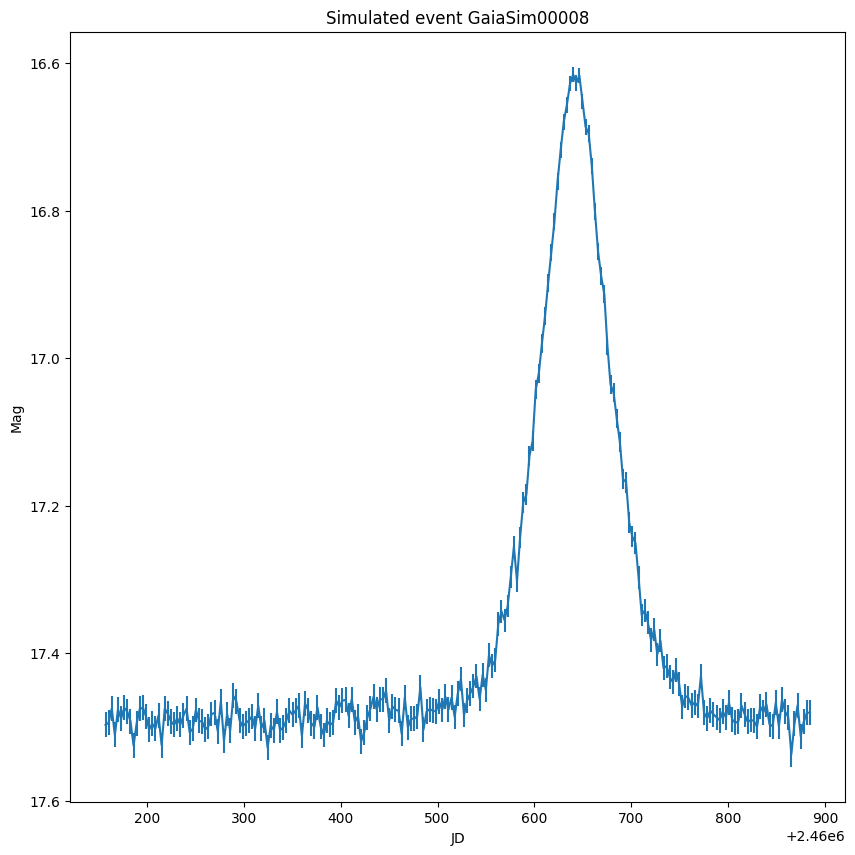

In [28]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_gaia_lenses[event_number].telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
#xmin = float(events_table[event_number]['t0']) - 2*float(events_table[event_number]['te'])
#xmax = float(events_table[event_number]['t0']) + 2*float(events_table[event_number]['te'])
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [29]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

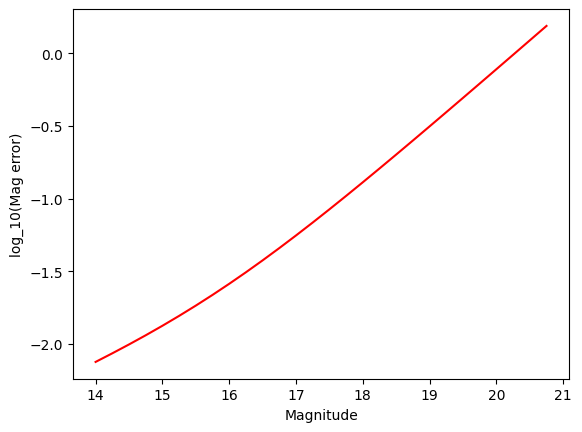

In [30]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [31]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [32]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [33]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Gaia events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [34]:
def simulate_lco_observations(gaia_event, gaia_model, gaia_model_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    gaia_lc = gaia_lens.telescopes[0].lightcurve_magnitude
    if len(gaia_lc) == 0:
        return gaia_event
    
    mag_threshold = 17.5
    bright_data = np.where(gaia_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(gaia_lc[:,1].min())+' no LCO observations')
        return gaia_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = gaia_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = gaia_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(gaia_event.ra, gaia_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = gaia_lc[:,0].min()
    end_jd = gaia_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (gaia_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = gaia_lc[idx,0].min()
            pre_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = gaia_lc[:,0].min()
            pre_peak_end = gaia_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = gaia_lc[idx,0].min()
            post_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = gaia_lc[:,0].max()
            post_peak_end = gaia_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        ts = np.concatenate((ts1,ts2,ts3))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return gaia_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for Gaia
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(gaia_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    gaia_event.telescopes.append(tel)
    
    if parallax:
        gaia_model.event.compute_parallax_all_telescopes(gaia_model.parallax_model)
        
    tel = gaia_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = gaia_model.compute_pyLIMA_parameters(gaia_model_params)
    magnification = gaia_model.model_magnification(tel, pylima_parameters)
    A = gaia_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)
    lc = np.delete(lc, idx, axis=0)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    gaia_event.telescopes[1] = tel
    
    return gaia_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [35]:
gaia_lens = sim_gaia_lenses[event_number]
gaia_lens_model = sim_gaia_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, visibility_data)

Event model parameters:  2460630.6360755963 0.04545153853264809 54.19571515429157 0.008479332810664432 0.49554608605159844 -0.0685202657213084
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                                location                                 baseline_mag            t0                  u0                 te                rho                  piEN                piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------- -------
GaiaSim00008 46706 <SkyCoord (ICRS): (ra, dec) in deg\n    (191.571425, -64.19874444)> 17.490000000000002 2460630.6360755963 0.04545153853264809 54.19571515429157 0.008479332810664432 0.49554608605159844 -0.0685202657213084     227


Text(0.5, 1.0, 'Simulated event GaiaSim00008')

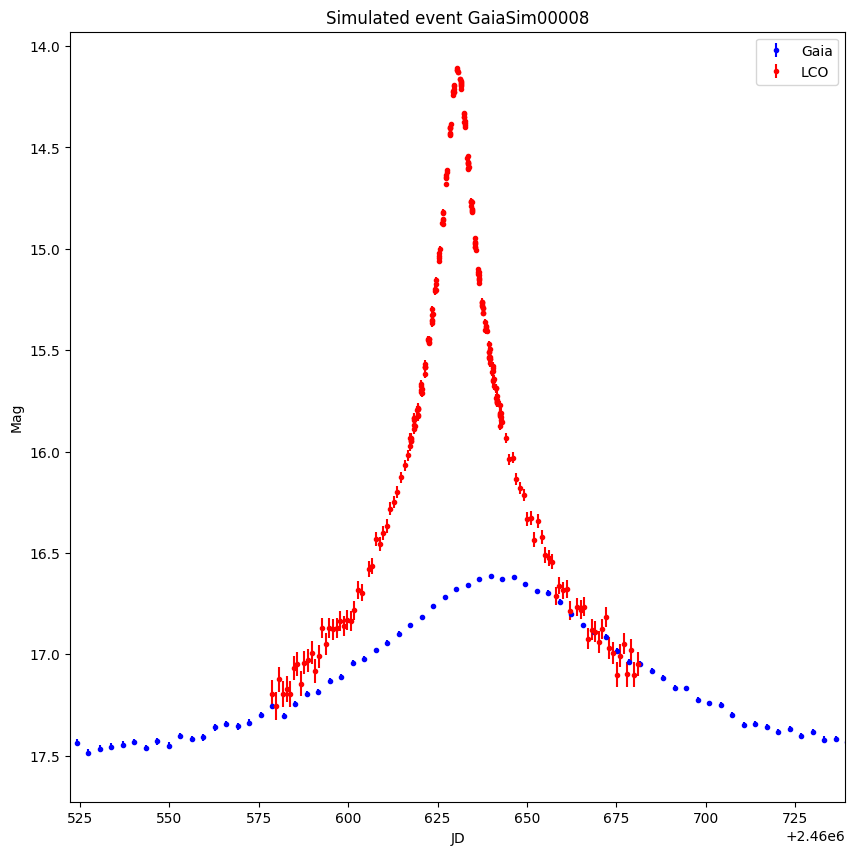

In [36]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated Gaia events

In [37]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_gaia_event = simulate_lco_observations(sim_gaia_lenses[ievent], 
                                                   sim_gaia_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   visibility_data)
    simulated_events_list.append(updated_gaia_event)

Event model parameters:  2460249.874704935 -0.09481753772714355 35.232861194558055 0.027390460452340885 -0.3177155235842072 -0.0034055510920603382
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460608.659205467 -0.2583166977934087 50.01244761695013 0.01067954573450122 1.3582715946823956 0.23757512172162887
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460782.672698673 0.23909077886474767 24.985497589958126 0.004760415361235304 -0.15496188168071146 0.44519617971169356
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460863.264270333 0.18720506218893357 82.44677097926667 0.025358246642173628 1.2201713604799262 -0.332343729613855
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460230.3749628696 -0.16333739378438375 55.47433047713222 0.010439919308857647 0.9417592033270177 -0.06469118163754428
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460496.13723942 0.3624839225089577 170.82405604440834 0.0057820618303556694 -0.43471071169253245 -0.2969906886077805
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460694.831738932 0.07262493162951249 105.82082985088232 0.004095000091632241 0.8676688926957643 -0.032824324626515154
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460237.9852817757 0.3104411221075485 22.212143465356245 0.0046281753420980174 0.20482852947091418 -0.48810456086057735
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460338.0206514136 0.3383534988670498 37.669779484364874 0.015721766621035443 -0.27105971608476476 -0.15905764467510206
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460669.3402013527 0.001865479772391626 6.151399158943684 0.017238039266802063 -0.6042631808405852 -0.3543083038657952

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460555.7509192447 0.3971536664240255 78.99397321631176 0.007219920102698343 0.30702761640123477 0.44535048262117705
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460511.4892943096 0.6236753146484195 66.78117447002043 0.009041989397405992 0.7516433307110475 0.26452998781138104
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460729.0163599704 -0.5107458270012531 32.425488965260705 0.02911672117410695 0.4070095420655896 0.32620436466716507
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460188.5148543823 0.24766400927386328 6.038347607064077 0.005565873183351668 -0.5473357509390748 0.3035870521265625
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.3000705065 0.147387291380844 77.96739887648845 0.005228437250279872 -0.2491767062245368 0.026094827822269816
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460405.532923358 -0.05955814910709473 67.72807031251271 0.017340893255019654 -0.8841631880529701 -0.3422065039729344
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460708.762578948 -0.12473533605171724 32.31823745231353 0.00948391171933564 0.3028180426931424 -0.031774409226161156
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460790.5963225826 -0.06762239193629041 22.652190751024712 0.01738755754697245 -0.9449768830886727 0.18463146514606119
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460622.1890346995 0.6127011096563203 19.68107886177459 0.02118885104903686 0.8002381087680865 0.3767103633547153
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460214.9252626295 0.5227603495546977 31.296572595080622 0.004532847897454058 1.7627346427375834 0.4117363760869009
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460853.5986946886 -0.24983839635707308 15.251542700578694 0.0078691903912054 -0.2041114689584137 -0.14285884984566727
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460203.7048141547 0.14260089564757547 120.99386781404158 0.004649709749775013 -0.09891100060506464 0.13424426084659966
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460542.8516209587 0.06788230628223803 90.47660275881623 0.025510125843774767 0.8341348923289367 -0.1455192337735179
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460671.5792513867 0.24276331819313396 12.210443896745145 0.002233147595678802 -0.3663943344964828 0.23258902099200013
No viable times for LCO observations
Event model parameters:  2460438.7811883115 0.11422148570216012 5.959954548757862 0.008979377277328013 0.2574123602302255 -0.31573216504941043
Parallax(Full) estima

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460162.153406694 0.04084670596473104 20.63173131743298 0.014792499166591176 0.5588932740403785 -0.07538278086444528
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460266.92417615 0.3402397278620889 19.380402047264745 0.0010905988398057908 0.22909561167928702 0.3316736945932565
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460550.8497047843 0.10824209896490937 20.38790696046604 0.014527849272118256 -0.4268140311283645 0.49609518548413917
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460682.3863041904 0.018805594413372526 15.173617537136698 0.008997590625619195 -0.3704828440600197 0.3769241019776892
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460551.829301895 -0.14796888988235166 23.281602140240047 0.014434335416287105 0.828053921633326 0.15607075637285583
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460460.687578552 -0.3248457165250056 4.61101091390929 0.03883276825643505 -0.7609203238209967 -0.01640414667575621
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460201.5646844213 -0.2669818277283419 12.933270751106525 0.0041244478063236336 0.1594263595947827 -0.1895809132539196
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460549.589200567 0.050719722194576114 44.18166240707674 0.016557444976533116 1.6661480911510682 0.43505055460791403
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460236.7223738753 0.6006487540469814 22.400606175014488 0.007549068992717171 0.43846270028153583 0.11593430826464263
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460348.927649867 -0.08456842190337 54.636606036929564 0.018985586562827478 0.07892359225815195 -0.6131796444973976
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460316.6183282793 0.035752081874697375 49.783912914960894 0.005592215343493228 -0.043528778639634946 0.10301635651493304
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460681.4492371506 -0.023973307309427594 38.72839394492141 0.010836215316937748 -0.03678396384969504 0.2069476906884146
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460876.3933441127 0.4741810916836362 34.69067809813957 0.011165115119271514 -0.42880272665621194 0.23317876034048102
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460589.155694407 -0.025824127370794314 9.52638477938946 0.0004977074703012615 -0.22392941586516624 0.02467645332325209
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460808.24828877 -0.05019572156785973 33.152904045295415 0.03203445907831762 1.0336088216865384 -0.0313967597713733

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460169.5613947073 0.550096034664285 9.6407337893723 0.00046062552832393765 -0.321836380025457 -0.1502504970569874
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460766.934979467 0.6766935355299587 11.09192698873548 0.021061889200433087 -0.32253050066546174 0.16854047109656914
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460581.0098179155 0.6239533787197755 34.079427386743795 0.0031877081482013635 0.23226838396445332 0.21996522649725161
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460552.4847878725 0.12115540669790449 125.98526781308166 0.008316845264011951 0.03777624076235883 0.040999586833439766
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460224.0939965406 0.03675983174372259 3.7529548247565936 0.009528859618483957 0.507128072089964 -0.1491989040454077
Paralla

Event model parameters:  2460496.6781467707 0.1122858038186727 39.29233217934953 0.015284576258245664 -1.0210479985115177 -0.026153472102931112
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460887.0963729303 0.24553496417079385 6.816565868683626 0.025025743504706995 -0.07602147499226791 0.10296856236366003
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460702.109128028 -0.0677675702516361 155.91464095563532 0.0019005146484083303 -0.8712293206092432 -0.2789747036912276
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.9194735186 0.5610657048111966 12.457325618959942 0.01185488840852799 -0.5090469109452975 0.2864793328862774
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460270.6050850423 0.3445252058106656 19.335159349838463 0.0008864028906780137 1.1974173103356809 -0.00943865732400384
Parallax(Full) estimated for the telescope LCO: SUCCESS
Eve

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460324.2604989973 -1.0 20.464581568091155 0.009681489511568433 1.113533720033038 -0.28252963458153496
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460819.7502009575 0.6461625640463398 16.460822676977443 0.026796903643032312 -0.5786177854065686 0.2455327686770703
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460634.4051222503 -0.26917506768802224 34.951204472151765 0.014854785451405072 0.6056976734147801 -0.13242584049251127
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460694.15856366 0.46176165573851713 26.63914762958087 0.016737407849592406 -1.464133705686305 0.6318973649137022
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460605.6761679514 -0.3232196956523825 15.434593423474901 0.033150295301127036 1.4422056095791824 0.33776617989328267
Parallax(Full) estimate

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460856.8037339277 0.8759991187055758 98.21370782075931 0.012398222386865752 -0.6232958900221801 -0.27131633014614476
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460780.356996587 -0.07144533156167115 14.798147952099955 0.0018808235907668835 0.5064388949266219 -0.32559380749735806
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460428.9688519505 -0.23710921005364752 26.331518868770743 0.01946247097120278 0.7123714558051852 -0.10333294192947837
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460485.695239424 0.21151083351925554 23.813515277637123 0.016607997352930948 -0.14624040174533842 -0.04137256822747846
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460601.4895998854 -0.24641046171402844 7.926372722596639 0.014978540196665873 -0.28294078950990564 -0.256266021134518

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460853.5878308183 -0.14701155912889194 6.430325815877381 0.010310623845387458 1.0632720291518618 0.5064827747437128
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460651.296426884 -0.3497650727504604 24.621963611154023 0.006781006606125957 0.2639761070623218 0.3444696323729579
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460448.445994563 -0.22844984245401892 49.55141558251889 0.006947621201068049 0.7408051662328117 -0.14408202728302485
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460878.2987145325 -0.19678044517121948 12.780410118983164 0.005797710295014545 0.5852446803684352 0.0712668461348749
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460193.0436069593 -0.09616698845917507 11.656369105425725 0.007247238016975592 0.8261669063237715 -0.44017397583920753
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460261.721877478 0.6570813093620932 21.393385404779657 0.028294428491644402 -0.4044346472975299 0.18632274126851428
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460205.608987628 0.38878555610262416 92.24020398611981 0.015090264178230083 0.16667323580797672 0.1531939801495177
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460222.2040345506 0.2957079436480229 76.84499736773165 0.014410380172061157 -0.07799133037832062 0.17505943136789956
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460469.9259782797 0.6228241794755046 100.93727212935079 0.019612043187707203 0.3396939130408509 0.34755737127502145
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460726.3874400603 -0.21266944918809835 4.939313548717726 0.02734824518407141 1.3831401244014092 0.03944510929898729
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460694.886589268 0.9157240336038599 8.289478648267234 0.0026315514781411736 -0.04761481930331282 0.3024471819016909
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460464.9300128375 0.3415946607457935 18.730350210630284 0.043531604130209504 0.16419356044575767 -0.044688823434718423
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.1062366464 0.2399538495573786 24.146547140976338 0.015212899660845698 -1.2646240397127972 0.018317811837812628
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460479.013175642 0.27756811502802936 30.41083586213161 0.01623327120018681 0.009573844660680259 0.3708169026588733
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460187.0600786065 -0.3618100178290614 92.58637502820122 0.008556171663728308 0.530159487346015 -0.13817548404826807
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460847.9308036496 0.4366944104070112 14.085824095028624 0.0013732026625963593 0.7010868969392836 0.2534665848008848
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460708.8568952424 -0.34069345510807514 104.3432660764263 0.0013576168628843654 0.24053588352292204 0.12034330516695863
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460437.1838880503 -0.2764927973737199 13.453156567629275 0.008356777896534532 -0.43679558672702795 0.7713035775726418
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460557.6171986996 0.015499403343516294 35.9782090192488 0.0025944057652798422 0.5491716133021209 0.04531080506910977
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460685.012962 -0.20528545352424285 40.07720997613168 0.008134840528594641 0.3990801989621538 -0.16964900852233533
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460785.4733015373 -0.05608969375031159 46.227051950278515 0.007914713718504985 -0.0763476123998669 -0.21394936940689321
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460234.8370331014 0.37317695823832747 37.44137893870305 0.02453868629292434 -0.6558214557888189 0.2470248518693606
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460507.0046006613 0.15403176593727308 27.44537441354696 0.03821714476464816 1.6745152326546162 0.12911547109182828
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460556.811107265 0.3712825368366941 45.516028224125954 0.00010516114747320324 2.210152394991028 0.42262134162921255
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460348.365819331 0.8846557134226423 11.385704364891492 0.007643920637761057 1.2786131289479599 0.23827653625920403
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460463.4260324 0.23878094061271848 15.088213409169684 0.023495805229752545 0.6369923406559233 -0.09368658715121594
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460265.842212648 0.2731792990453732 69.8004484286964 0.009936234407995919 -0.9311838073926184 -0.21432803481456872
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460826.1569896364 0.49634692366914235 70.24567004712162 0.02702182342120054 0.40372005352200746 -0.42957424164284586
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460816.612333965 0.48459858771554676 15.966705492765486 0.004764407775743646 0.6865310532083353 0.08937449587331088
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460713.559278802 -0.3149332489521257 62.692257064454495 0.023064972304213442 1.6215300986020353 0.20714053725976445
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460557.6153505603 -0.1764093143227112 41.13788749854876 0.029970497169204656 0.5203805669804673 0.33584651753404804
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460166.346312774 -0.16031376582790688 27.683507706202366 0.0002381516543814733 0.26347050213100226 0.024362913008067023
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460357.9925906467 -0.23638193392295323 49.7753569779811 0.016707269356868525 0.4251756211386865 0.06563916319027303
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460349.562094444 0.51021287649894 39.81214198593396 0.003144252824245722 0.6840286222719696 -0.19732877332165571
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460312.525446996 0.5852742749439308 10.020895252132528 0.008118935248225925 0.27267449321676973 -0.014462258645686961
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460322.1933104675 0.18148505245880978 22.678470997178227 0.004082346284525551 -0.5504574947084142 0.17184450288062642
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460463.0541497534 0.4977093912976127 50.498262471090754 0.017836015191044715 0.9199100294375444 -0.170939216683744
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460776.4911334645 0.18002761048991026 40.34994483429888 0.009160574198337833 -0.273362216180745 -0.17786019712602277
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460686.8010418457 0.8223540485601931 59.13326784871863 0.009227037742964675 -0.7731542098330253 -0.1365422991754048
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460554.6648759753 -0.18426792958169677 32.918204019183605 0.0010548855865373276 -0.06566281785964834 -0.1416481099457706
Par

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460611.0454877364 0.04947003921955323 24.230066138951326 0.015718871670469467 -0.027597894416064694 0.08621920954860182
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460814.584569576 -0.17944525850906154 33.43781148769781 0.011088722707495727 2.0918050100707073 0.051117242761150344
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460548.4777327203 0.6620230940954659 10.828670314441462 0.007787444143236896 -0.07505215455714762 -0.3606636465977909
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460595.5212039724 0.028374762639081674 42.69699402926445 0.0006027858256753872 -0.529908323057289 -0.3243503260495486
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460802.865802336 0.04392061502077915 31.217330721637286 0.025883867668876404 -0.7340435952508422 0.06858935205637402


Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460759.668919704 -0.23844214096818192 6.518760613340358 0.017021616787872264 -1.3925315819627302 -0.20592128811758206
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460653.168799884 -0.29021976157087914 69.10584062319343 0.02182763149748055 -0.6188736472298273 0.23806250069689933
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460505.537604576 0.46641400145410317 46.81071575329864 0.024548786816295763 0.16443379467808916 0.3167317633193861
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460585.630065814 0.24773028852948104 110.74942664329532 0.02334345581816993 0.5049545140253757 0.37657432180471107
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460220.2662032205 0.2845885803373877 18.61985335254106 0.02376528236363063 -0.26495447903313085 0.08180396509375501
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460554.4337293603 0.44791398084931977 70.40701685142646 0.0213209245555701 0.31425300966308184 0.7867698678630006
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460435.578063463 -0.5873125854818729 66.43354085357697 0.017296123122411883 -0.17450329797964576 -0.2204720655244092
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460832.2896763505 0.2780103185225694 75.62697977776229 0.008421938920271736 1.4938170416312067 -0.019706401093560567
Parallax(Full) estimated for the telescope LCO: SUCCESS


In [38]:
file_path = 'simulated_lco_lightcurves_gaia_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [39]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [40]:
def fit_event_model(event_params, model_type, horizons_table, gaia_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=gaia_lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel1.spacecraft_positions = spacecraft_positions
    
    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Gaia')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Gaia', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [41]:
gaia_lc = updated_gaia_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_gaia_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                                location                                 baseline_mag            t0                  u0                 te                rho                  piEN                piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------- -------
GaiaSim00008 46706 <SkyCoord (ICRS): (ra, dec) in deg\n    (191.571425, -64.19874444)> 17.490000000000002 2460630.6360755963 0.04545153853264809 54.19571515429157 0.008479332810664432 0.49554608605159844 -0.0685202657213084     227
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00008, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differe

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [42]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        gaia_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, horizons_table, gaia_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 457.806
DE converge to objective function : f(x) =  457.72267963063786
DE converge to parameters : =  ['2460249.875004935' '-0.09451753772714355' '35.23316119455806'
 '0.027690460452340887' '-0.3180155235842072' '-0.003705551092060338']
trust_region_reflective  : TRF fit SUCCESS
[2460249.8749504564, -0.09451753772819058, 35.23316119451269, 0.027690460451407637, -0.3180155235837072, -0.0037055510915102226, 1467.5602704443907, -14.36934921510749, 9299.123126168868, 6.129273969131378, 457.72277220199277]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460249

differential_evolution step 1: f(x)= 430.093
DE converge to objective function : f(x) =  429.9146343430529
DE converge to parameters : =  ['2460230.3746628696' '-0.16303739378438376' '55.47403047713222'
 '0.010739919308857647' '0.9420592033270176' '-0.06439118163754429']
trust_region_reflective  : TRF fit SUCCESS
[2460230.374662962, -0.1630373937843968, 55.47403047713234, 0.010739919308844844, 0.9420592033270044, -0.06439118163755672, 3678.2491519954315, -37.53251790103397, 9315.454184915981, -73.68623803839132, 429.91463635896736]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460230.374662962, -0.1630373937843968, 55.47403047713234, 0.010739919308844844, 0.9420592033270044, -0.06439118163755672, 3678.2491519954315, -37.53251790103397, 9315.454184915981, -73.68623803839132, 429.91463635896736]
t0: Fitted value=2460230.374662962+/-0.028098767788488625 expected value=2460230.3749628696
t0: delta=0.00029990775510668755 prop_

differential_evolution step 1: f(x)= 564.467
differential_evolution step 2: f(x)= 564.3
differential_evolution step 3: f(x)= 564.127
differential_evolution step 4: f(x)= 564.127
differential_evolution step 5: f(x)= 564.069
DE converge to objective function : f(x) =  563.8712193646147
DE converge to parameters : =  ['2460474.421625396' '-0.037561611366743276' '26.038080900410343'
 '0.0170311601823876' '0.7084927991250671' '-0.12000108115760316']
trust_region_reflective  : TRF fit SUCCESS
[2460474.421625394, -0.0375616061328465, 26.038080900410346, 0.017031160182387598, 0.708492799125067, -0.12000108115760318, 36673.87819429667, -14.38558995716946, 9317.560424671738, 40.19294955695815, 563.8712195012533]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460474.421625394, -0.0375616061328465, 26.038080900410346, 0.017031160182387598, 0.708492799125067, -0.12000108115760318, 36673.87819429667, -14.38558995716946, 9317.56042467173

differential_evolution step 2: f(x)= 393.176
differential_evolution step 3: f(x)= 393.176
differential_evolution step 4: f(x)= 393.176
differential_evolution step 5: f(x)= 393.014
differential_evolution step 6: f(x)= 393.014
differential_evolution step 7: f(x)= 393.014
differential_evolution step 8: f(x)= 393.014
differential_evolution step 9: f(x)= 392.917
differential_evolution step 10: f(x)= 392.763
DE converge to objective function : f(x) =  392.6745729011898
DE converge to parameters : =  ['2460766.061821622' '-0.01776425716670338' '21.227704481880647'
 '0.011985251521653587' '1.7404063085958077' '0.36661308687327404']
trust_region_reflective  : TRF fit SUCCESS
[2460766.0618053786, -0.017760626771554877, 21.227478472354992, 0.011961396319873082, 1.7401996723089401, 0.3666130868732741, 2352.1744917889932, -57.83132865324942, 9332.100137351968, 17.282062183666444, 392.598557202043]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit re

differential_evolution step 1: f(x)= 320.772
DE converge to objective function : f(x) =  320.77019215358257
DE converge to parameters : =  ['2460557.950389937' '0.8114826525907164' '17.78655672320764'
 '0.01000022250462523' '0.24201365312582132' '0.19505599680974875']
trust_region_reflective  : TRF fit SUCCESS
[2460557.9503899384, 0.8114826525907163, 17.786556723207635, 0.010000222504625312, 0.2420136531258209, 0.19505599680974914, 903.247787254007, 3.610227433299462, 9173.001365288348, 237.72599366148881, 320.7701921570859]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460557.9503899384, 0.8114826525907163, 17.786556723207635, 0.010000222504625312, 0.2420136531258209, 0.19505599680974914, 903.247787254007, 3.610227433299462, 9173.001365288348, 237.72599366148881, 320.7701921570859]
t0: Fitted value=2460557.9503899384+/-0.522276801781019 expected value=2460557.950689937
t0: delta=0.00029999855905771255 prop_delta=1.219229

differential_evolution step 1: f(x)= 548.635
differential_evolution step 2: f(x)= 548.609
differential_evolution step 3: f(x)= 548.609
differential_evolution step 4: f(x)= 548.609
differential_evolution step 5: f(x)= 548.6
DE converge to objective function : f(x) =  548.4392568267498
DE converge to parameters : =  ['2460741.863114597' '-0.056204650763480496' '35.48325692098378'
 '0.020959718287884226' '-0.3729112342402683' '-0.1498790622126098']
trust_region_reflective  : TRF fit SUCCESS
[2460741.863114596, -0.056204646217710444, 35.48325692098377, 0.020959718287884222, -0.37291123424026823, -0.14987906221260983, 2321.204085141658, -20.221464133729576, 9347.280411186863, -75.41973765742681, 548.4392569976727]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460741.863114596, -0.056204646217710444, 35.48325692098377, 0.020959718287884222, -0.37291123424026823, -0.14987906221260983, 2321.204085141658, -20.221464133729576, 9347

differential_evolution step 1: f(x)= 1096.76
DE converge to objective function : f(x) =  1096.665251221359
DE converge to parameters : =  ['2460756.9478799906' '-0.1921163068829051' '77.6923845166874'
 '0.01772880567443833' '2.019142659714466' '0.32275249581416454']
trust_region_reflective  : TRF fit SUCCESS
[2460756.9478800097, -0.19211630688289863, 77.69238451668727, 0.01772880567444015, 2.019142659714462, 0.32275249581416565, 3662.61859836105, 5.480183652987477, 9360.869173099383, -93.72107631624753, 1096.665251449663]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.9478800097, -0.19211630688289863, 77.69238451668727, 0.01772880567444015, 2.019142659714462, 0.32275249581416565, 3662.61859836105, 5.480183652987477, 9360.869173099383, -93.72107631624753, 1096.665251449663]
t0: Fitted value=2460756.9478800097+/-0.0658822210621991 expected value=2460756.9481799905
t0: delta=0.00029998086392879486 prop_delta=1.21905929

differential_evolution step 1: f(x)= 318.984
DE converge to objective function : f(x) =  318.9769466686392
DE converge to parameters : =  ['2460863.634056563' '0.6259637717524117' '18.14064585468506'
 '0.007762911256004512' '1.5012692401236574' '-0.11989603010273611']
trust_region_reflective  : TRF fit SUCCESS
[2460863.6340554594, 0.625963771752219, 18.140645854714904, 0.007762911255639426, 1.5012692401243002, -0.11989603010237278, 3553.233094740474, 113.8288507153554, 9436.904463926518, -160.65772368272906, 318.97696394782685]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460863.6340554594, 0.625963771752219, 18.140645854714904, 0.007762911255639426, 1.5012692401243002, -0.11989603010237278, 3553.233094740474, 113.8288507153554, 9436.904463926518, -160.65772368272906, 318.97696394782685]
t0: Fitted value=2460863.6340554594+/-0.1838599154621333 expected value=2460863.633756563
t0: delta=0.00029889633879065514 prop_delta=1

differential_evolution step 1: f(x)= 213.311
DE converge to objective function : f(x) =  213.26724415513996
DE converge to parameters : =  ['2460679.1514576017' '-0.2749679233187617' '20.5987453113831'
 '0.0006906428982415796' '0.002060333611054033' '0.3660461074581226']
trust_region_reflective  : TRF fit SUCCESS
[2460679.1512498967, -0.2749679234076258, 20.598745313405797, 0.0006906428982415796, 0.002060333684375332, 0.3660461074586226, 5770.982093699204, 42.73210925158084, 9370.297787840953, -178.65714764968075, 213.28009420516858]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460679.1512498967, -0.2749679234076258, 20.598745313405797, 0.0006906428982415796, 0.002060333684375332, 0.3660461074586226, 5770.982093699204, 42.73210925158084, 9370.297787840953, -178.65714764968075, 213.28009420516858]
t0: Fitted value=2460679.1512498967+/-0.23671205986780405 expected val

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00043, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 560.993
DE converge to objective function : f(x) =  560.9921723183095
DE converge to parameters : =  ['2460881.426264124' '0.4449420906550256' '35.75694346402993'
 '0.0016711245696770932' '-1.1737429525099616' '0.3620767133489857']
trust_region_reflective  : TRF fit SUCCESS
[2460881.4260199666, 0.4449420906330929, 35.75694346048848, 0.0016711245696770932, -1.1737429526249072, 0.36207671325132107, 595.8824242103235, -17.44863828757756, 9373.84409172441, -33.48987017020564, 560.992246356182]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460881.4260199666, 0.4449420906330929, 35.75694346048848, 0.0016711245696770932, -1.1737429526249072, 0.36207671325132107, 5

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00048, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 652.213
DE converge to objective function : f(x) =  652.2039078774785
DE converge to parameters : =  ['2460496.13693942' '0.36278392250895775' '170.82375604440833'
 '0.0054820618303556695' '-0.4344107116925324' '-0.2972906886077805']
trust_region_reflective  : TRF fit SUCCESS
[2460496.136941407, 0.36278392250842095, 170.82375604449865, 0.005482061830863975, -0.4344107116930324, -0.2972906886072653, 939.1147572463544, -28.808396441103362, 9281.978016047866, 72.3987174967521, 652.2039082169629]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.136941407, 0.36278392250842095, 170.82375604449865, 0.005482061830863975, -0.4344107116930324, -0.2972906886072653, 939.1147572463544, -28.808396441103362, 9281.978016047

trust_region_reflective  : TRF fit SUCCESS
[2460669.340501352, 0.0015654797723916277, 6.151699158943683, 0.017538039266801905, -0.604563180840585, -0.35460830386579517, 559.405379259643, 9.531824481668188, 9287.814016317057, 51.619578303111794, 370.5633779096194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460669.340501352, 0.0015654797723916277, 6.151699158943683, 0.017538039266801905, -0.604563180840585, -0.35460830386579517, 559.405379259643, 9.531824481668188, 9287.814016317057, 51.619578303111794, 370.5633779096194]
t0: Fitted value=2460669.340501352+/-0.0036876105665936635 expected value=2460669.3402013527
t0: delta=0.00029999949038028717 prop_delta=1.2191783978408846e-08% within_range? True
te: Fitted value=6.151699158943683+/-1.1578566434034137 expected value=6.151399158943684
te: delta=0.0002999999999993008 prop_delta=0.004876939249879807% within_range? True
u0: Fitted value=0.0015654797723916277+/-0.9535399641

differential_evolution step 1: f(x)= 577.714
DE converge to objective function : f(x) =  577.6873269788912
DE converge to parameters : =  ['2460827.9370195433' '0.35984818309194827' '37.41600142354372'
 '0.003341138138300662' '0.8173544941693012' '0.2480737693567266']
trust_region_reflective  : TRF fit SUCCESS
[2460827.9370195363, 0.3598481830919501, 37.41600142354342, 0.0033411381382997623, 0.817354494169299, 0.24807376935673192, 5788.660558078695, 9.523558468604953, 9313.96072838419, 100.91697743774509, 577.687327158504]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460827.9370195363, 0.3598481830919501, 37.41600142354342, 0.0033411381382997623, 0.817354494169299, 0.24807376935673192, 5788.660558078695, 9.523558468604953, 9313.96072838419, 100.91697743774509, 577.687327158504]
t0: Fitted value=2460827.9370195363+/-0.09863126605762011 expected value=2460827.9367195433
t0: delta=0.00029999297112226486 prop_delta=1.2190733

differential_evolution step 1: f(x)= 478.257
DE converge to objective function : f(x) =  478.2129686288047
DE converge to parameters : =  ['2460170.1673637573' '-0.2136067300129032' '32.17970117811945'
 '0.011477924373592002' '0.16896123671734772' '0.2942981579183209']
trust_region_reflective  : TRF fit SUCCESS
[2460170.167464068, -0.21360673001399164, 32.17970117813917, 0.011477924372454292, 0.16896123671632185, 0.2942981579188209, 5895.451115553556, -93.32962810930695, 9237.606926969878, 272.6251245061197, 478.2130340800355]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460170.167464068, -0.21360673001399164, 32.17970117813917, 0.011477924372454292, 0.16896123671632185, 0.2942981579188209, 5895.451115553556, -93.32962810930695, 9237.606926969878, 272.6251245061197, 478.2130340800355]
t0: Fitted value=2460170.167464068+/-0.02394694393695274 expected value=2460170.167663757
t0: delta=0.00019968906417489052 prop_delta=8.11

differential_evolution step 1: f(x)= 219.382
DE converge to objective function : f(x) =  219.25499788807178
DE converge to parameters : =  ['2460632.7925464986' '-0.07604335657114109' '42.5827639087766'
 '0.008137372990977488' '0.04736973106618502' '0.19818951814031327']
trust_region_reflective  : TRF fit SUCCESS
[2460632.792546498, -0.0760433565711411, 42.582763908776606, 0.008137372990977486, 0.04736973106618503, 0.1981895181403133, 2306.318236750027, -8.77088112626837, 9286.304147110272, 137.40037429851387, 219.25499798779026]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460632.792546498, -0.0760433565711411, 42.582763908776606, 0.008137372990977486, 0.04736973106618503, 0.1981895181403133, 2306.318236750027, -8.77088112626837, 9286.304147110272, 137.40037429851387, 219.25499798779026]
t0: Fitted value=2460632.792546498+/-0.01682429726157212 expected value=2460632.7922464986
t0: delta=0.00029999949038028717 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00069, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 520.276
DE converge to objective function : f(x) =  520.1756469428537
DE converge to parameters : =  ['2460507.852989866' '0.06851336000335237' '17.62329088501773'
 '0.010131037915935632' '0.38571588787405114' '0.34041102410801266']
trust_region_reflective  : TRF fit SUCCESS
[2460507.8529800717, 0.06851385656848874, 17.62329088677724, 0.01013118635580743, 0.3857158879686034, 0.3404110240170853, 2304.7393017190625, 2.2722945740947287, 9322.77025230981, 22.61086392234549, 520.1875002089347]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460507.8529800717, 0.06851385656848874, 17.62329088677724, 0.01013118635580743, 0.3857158879686034, 0.3404110240170853, 2304.7393017190625, 2.2722945740947287, 9322.77025230981, 22.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00074, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 92.844
DE converge to objective function : f(x) =  92.81282116034482
DE converge to parameters : =  ['2460654.0660798354' '0.09480154510794292' '12.110806633030965'
 '0.018562453698753426' '-0.7290263877804926' '-0.12547879812490384']
trust_region_reflective  : TRF fit SUCCESS
[2460654.0660798345, 0.09480154510794156, 12.110806633030945, 0.01856245369875171, -0.7290263877804922, -0.1254787981249035, 3619.217523117339, 26.957094767267165, 7853.510327996725, 2847.7459329930557, 92.81282121207634]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460654.0660798345, 0.09480154510794156, 12.110806633030945, 0.01856245369875171, -0.7290263877804922, -0.1254787981249

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00078, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 668.305
DE converge to objective function : f(x) =  668.2153771547412
DE converge to parameters : =  ['2460808.4611119493' '-0.25375371275105135' '27.641801483625684'
 '0.027554746829343495' '-0.024088597335338226' '-0.1989453031227975']
trust_region_reflective  : TRF fit SUCCESS
[2460808.4611119498, -0.2537537127510514, 27.64180148362568, 0.027554746829343543, -0.024088597335338184, -0.19894529814742523, 5788.594239677491, 26.137152346359976, 9354.481050361112, -69.44006705182602, 668.2153771984526]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460808.4611119498, -0.2537537127510514, 27.64180148362568, 0.027554746829343543, -0.024088597335338184, -0.19894529814742523, 5788.594239677491, 26.137152346359976, 9354

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00083, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 259.08
DE converge to objective function : f(x) =  259.0688441962381
DE converge to parameters : =  ['2460737.2052348075' '0.256013638551662' '6.909741795656358'
 '0.00455711566814293' '0.8288767549185772' '0.49971932831654414']
trust_region_reflective  : TRF fit SUCCESS
[2460737.205234808, 0.25601363855166204, 6.909741795656359, 0.004557115668142931, 0.828876754918577, 0.4997193283165442, 2283.350384593634, 21.908111290081674, 9518.335812616457, -529.3293045463505, 259.0688442046152]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460737.205234808, 0.25601363855166204, 6.909741795656359, 0.004557115668142931, 0.828876754918577, 0.4997193283165442, 2283.350384593634, 21.908111290081674, 9518.335812616457, -529.329

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00087, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 362.327
DE converge to objective function : f(x) =  362.13812681163387
DE converge to parameters : =  ['2460620.8354933443' '0.14053965292111079' '10.07024681724241'
 '0.007990903288040033' '0.805930146402329' '-0.20189777993586136']
trust_region_reflective  : TRF fit SUCCESS
[2460620.8354932815, 0.14053965292110376, 10.070246817242417, 0.00799090328803284, 0.8059301464023297, -0.20189777993586883, 899.6588748300218, 10.732947269369665, 9296.324246755683, 114.65143690315077, 362.138138561034]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460620.8354932815, 0.14053965292110376, 10.070246817242417, 0.00799090328803284, 0.8059301464023297, -0.2018977799358688

DE converge to objective function : f(x) =  981.3479716793267
DE converge to parameters : =  ['2460555.7506192448' '0.3974536664240255' '78.99367321631176'
 '0.007312821213927266' '0.30672761640123475' '0.445050482621177']
trust_region_reflective  : TRF fit SUCCESS
[2460555.7507189116, 0.39745366642251456, 78.99367322037568, 0.007310226808772691, 0.3067276164123205, 0.4450504826216238, 931.1872548453787, -10.134333723023428, 9488.42212304263, -353.91707605836547, 981.3482434274102]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460555.7507189116, 0.39745366642251456, 78.99367322037568, 0.007310226808772691, 0.3067276164123205, 0.4450504826216238, 931.1872548453787, -10.134333723023428, 9488.42212304263, -353.91707605836547, 981.3482434274102]
t0: Fitted value=2460555.7507189116+/-0.16476594328309563 expected value=2460555.7509192447
t0: delta=0.00020033307373523712 prop_delta=8.141781532907524e-09% within_range? True
te: F

differential_evolution step 1: f(x)= 975.974
DE converge to objective function : f(x) =  975.9189762766138
DE converge to parameters : =  ['2460423.3003705065' '0.147087291380844' '77.96709887648845'
 '0.005528437250279872' '-0.249124992138829' '0.025902872032168168']
trust_region_reflective  : TRF fit SUCCESS
[2460423.3003704804, 0.14708729138084892, 77.96709887648855, 0.005528437250275863, -0.24912499032268134, 0.025902875477613097, 2293.17199179059, 12.608563721558099, 9284.867211423501, 124.60636316737208, 975.9189790444934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460423.3003704804, 0.14708729138084892, 77.96709887648855, 0.005528437250275863, -0.24912499032268134, 0.025902875477613097, 2293.17199179059, 12.608563721558099, 9284.867211423501, 124.60636316737208, 975.9189790444934]
t0: Fitted value=2460423.3003704804+/-0.022760132488931394 expected value=2460423.3000705065
t0: delta=0.00029997387900948524 prop_de

DE converge to objective function : f(x) =  488.25724685882653
DE converge to parameters : =  ['2460880.647519498' '0.2608280515150508' '43.083714020615936'
 '0.0040883430966751335' '-0.6907079241354677' '0.33840039632289576']
trust_region_reflective  : TRF fit SUCCESS
[2460880.6472746795, 0.26083054196579775, 43.08371402370358, 0.004088240534702812, -0.6907079240390851, 0.3384003964201104, 146190.3524787765, -322.9584253091328, 9349.15594478704, 25.96183037628674, 488.26136440397266]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460880.6472746795, 0.26083054196579775, 43.08371402370358, 0.004088240534702812, -0.6907079240390851, 0.3384003964201104, 146190.3524787765, -322.9584253091328, 9349.15594478704, 25.96183037628674, 488.26136440397266]
t0: Fitted value=2460880.6472746795+/-0.09916860551351488 expected value=2460880.647219498
t0: delta=5.518132820725441e-05 prop_delta=2.242340694970426e-09% within_range? True
te: F

differential_evolution step 1: f(x)= 638.855
DE converge to objective function : f(x) =  638.7782564103084
DE converge to parameters : =  ['2460743.2817271296' '-0.2447664833156331' '44.28549728622814'
 '0.011265003951973713' '0.7983311782418749' '-0.06760819957954664']
trust_region_reflective  : TRF fit SUCCESS
[2460743.2817271287, -0.24476648331563305, 44.28549728622815, 0.011265003951973745, 0.798331178241875, -0.0676081995795466, 2320.6580360614107, -12.349574387957064, 9363.948971454845, -109.10836628778944, 638.7782564358556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460743.2817271287, -0.24476648331563305, 44.28549728622815, 0.011265003951973745, 0.798331178241875, -0.0676081995795466, 2320.6580360614107, -12.349574387957064, 9363.948971454845, -109.10836628778944, 638.7782564358556]
t0: Fitted value=2460743.2817271287+/-0.04130991547260196 expected value=2460743.2814271296
t0: delta=0.00029999902471899986 prop

differential_evolution step 2: f(x)= 580.66
differential_evolution step 3: f(x)= 580.66
differential_evolution step 4: f(x)= 580.66
differential_evolution step 5: f(x)= 580.66
differential_evolution step 6: f(x)= 580.66
DE converge to objective function : f(x) =  580.4739568443206
DE converge to parameters : =  ['2460883.659260008' '-0.03273213591871607' '65.01947105207641'
 '0.005796991467234688' '0.2068681608676909' '0.3296912121798919']
trust_region_reflective  : TRF fit SUCCESS
[2460883.6592600076, -0.03273792864351396, 65.01954953667011, 0.005926263606890527, 0.20686816086769086, 0.32969121217989183, 1469.6637044473114, -15.971310406094222, 9351.395253224628, -159.16677322096552, 580.4716359250568]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460883.6592600076, -0.03273792864351396, 65.01954953667011, 0.005926263606890527, 0.20686816086769086, 0.32969121217989183, 1469.6637044473114, -15.971310406094222, 9351.395253

differential_evolution step 1: f(x)= 456.501
DE converge to objective function : f(x) =  456.4364648695165
DE converge to parameters : =  ['2460376.329963667' '-0.24447311536927802' '116.3607758450692'
 '0.0014968256735333873' '-0.5908868520512527' '-0.028048217226011668']
trust_region_reflective  : TRF fit SUCCESS
[2460376.3299323157, -0.24447311536677604, 116.3607758445474, 0.0014968256740333873, -0.5908868520411183, -0.028048217223049225, 928.7399120950496, -23.00714068713492, 9396.432098832718, -79.55668160561775, 456.43648690317116]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460376.3299323157, -0.24447311536677604, 116.3607758445474, 0.0014968256740333873, -0.5908868520411183, -0.028048217223049225, 928.7399120950496, -23.00714068713492, 9396.432098832718, -79.55668160561775, 456.43648690317116]
t0: Fitted value=2460376.3299323157+/-0.2544053501148734 expected value=2460376.329663667
t0: delta=0.000268648844212293

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00115, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 687.639
DE converge to objective function : f(x) =  687.6093131029852
DE converge to parameters : =  ['2460189.04909223' '0.3813529112979111' '51.460965992700224'
 '0.012289410559832901' '1.3838431965278157' '0.2713377667896934']
trust_region_reflective  : TRF fit SUCCESS
[2460189.049092232, 0.38135291129791077, 51.46096599270021, 0.012289410559833238, 1.3838431965278153, 0.2713377667896937, 3708.758063613582, -54.57777162310498, 9376.804587532157, -110.83386578401176, 687.6093131128906]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460189.049092232, 0.38135291129791077, 51.46096599270021, 0.012289410559833238, 1.3838431965278153, 0.2713377667896937, 3708.758063613582, -54.57777162310498, 9376.804587532157, -110

differential_evolution step 1: f(x)= 615.121
DE converge to objective function : f(x) =  615.0973977029284
DE converge to parameters : =  ['2460740.915073267' '0.29052643631585573' '45.046524352795565'
 '0.011741682263201245' '0.9600431616277842' '0.14671415635938118']
trust_region_reflective  : TRF fit SUCCESS
[2460740.915073268, 0.29052643631585556, 45.04652435279556, 0.011741682263201342, 0.9600431616277839, 0.1467141563593818, 1444.1462671335566, 10.095639231300392, 9402.65689697304, -232.37836299225702, 615.0973977790954]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460740.915073268, 0.29052643631585556, 45.04652435279556, 0.011741682263201342, 0.9600431616277839, 0.1467141563593818, 1444.1462671335566, 10.095639231300392, 9402.65689697304, -232.37836299225702, 615.0973977790954]
t0: Fitted value=2460740.915073268+/-0.059962650846460075 expected value=2460740.915373267
t0: delta=0.00029999902471899986 prop_delta=1.2

differential_evolution step 1: f(x)= 936.72
DE converge to objective function : f(x) =  936.6648676921279
DE converge to parameters : =  ['2460796.4811663833' '-0.5019092069382759' '84.34586718435585'
 '0.010591826564870075' '-0.8039549983964169' '-0.335986272570151']
trust_region_reflective  : TRF fit SUCCESS
[2460796.481163037, -0.5019092069374985, 84.34586718431368, 0.010591826564362748, -0.8039549983971869, -0.33598627256949876, 2307.387161488742, -7.53818317684841, 9240.638719615543, 214.0482093937232, 936.6648770666984]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460796.481163037, -0.5019092069374985, 84.34586718431368, 0.010591826564362748, -0.8039549983971869, -0.33598627256949876, 2307.387161488742, -7.53818317684841, 9240.638719615543, 214.0482093937232, 936.6648770666984]
t0: Fitted value=2460796.481163037+/-0.27410075424355607 expected value=2460796.4808663833
t0: delta=0.00029665371403098106 prop_delta=1.20

differential_evolution step 1: f(x)= 221.571
DE converge to objective function : f(x) =  221.5571322202925
DE converge to parameters : =  ['2460373.452844473' '0.44087721638909033' '12.506132046676512'
 '0.023350628577379143' '0.6088737585768871' '0.03844233315411374']
trust_region_reflective  : TRF fit SUCCESS
[2460373.4528444735, 0.4408772163890933, 12.506132046676552, 0.023350628577367968, 0.608873758576882, 0.03844233315410864, 832.1953181446207, 77.21605360385821, 9218.019801373977, 201.68018991584398, 221.5571322439986]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460373.4528444735, 0.4408772163890933, 12.506132046676552, 0.023350628577367968, 0.608873758576882, 0.03844233315410864, 832.1953181446207, 77.21605360385821, 9218.019801373977, 201.68018991584398, 221.5571322439986]
t0: Fitted value=2460373.4528444735+/-0.07253351220980342 expected value=2460373.453144473
t0: delta=0.00029999949038028717 prop_delta=1.219

differential_evolution step 2: f(x)= 1006.19
differential_evolution step 3: f(x)= 1006.19
differential_evolution step 4: f(x)= 1006.19
differential_evolution step 5: f(x)= 1006.13
DE converge to objective function : f(x) =  1005.9422931789134
DE converge to parameters : =  ['2460405.533223358' '-0.05948017619125913' '67.72837031251271'
 '0.017640893255019656' '-0.8844631880529701' '-0.3419065039729344']
trust_region_reflective  : TRF fit SUCCESS
[2460405.5332233575, -0.05948017161625091, 67.7283703125127, 0.017640893255019427, -0.88446318805297, -0.34190650397293443, 914.0735387057525, 0.33589511393572724, 9303.642131822626, 109.92400056785864, 1005.9422935154117]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460405.5332233575, -0.05948017161625091, 67.7283703125127, 0.017640893255019427, -0.88446318805297, -0.34190650397293443, 914.0735387057525, 0.33589511393572724, 9303.642131822626, 109.92400056785864, 1005.9422935154

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00137, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 475.678
DE converge to objective function : f(x) =  475.66894251296134
DE converge to parameters : =  ['2460214.9249626296' '0.5230603495546977' '31.29687259508062'
 '0.004600492218932273' '1.7624346427375834' '0.4120363760869009']
trust_region_reflective  : TRF fit SUCCESS
[2460214.925130625, 0.5230603495546969, 31.296872592079556, 0.004600492218932273, 1.762434642890828, 0.41203637605644877, 3573.252335283173, 94.46995372934158, 9520.603903464937, -292.2256722288876, 475.6713814081756]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460214.925130625, 0.5230603495546969, 31.296872592079556, 0.004600492218932273, 1.762434642890828, 0.41203637605644877, 3573.252335283173, 94.46995372934158, 9520.603903464937, -292.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00142, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 518.941
DE converge to objective function : f(x) =  518.9332434862007
DE converge to parameters : =  ['2460827.326569041' '-0.529843426341988' '27.773550316826945'
 '0.031550030472367575' '0.4870549640290681' '-0.06540906072002875']
trust_region_reflective  : TRF fit SUCCESS
[2460827.326569048, -0.5298434263419853, 27.77355031682692, 0.031550030472402374, 0.4870549640290685, -0.06540906072002949, 23106.807290313496, 13.57046963658437, 9372.082059798604, -101.87364298820977, 518.9332435122457]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460827.326569048, -0.5298434263419853, 27.77355031682692, 0.031550030472402374, 0.4870549640290685, -0.06540906072002949, 23106.807290313496, 13.57046963658437, 9372.08205979860

trust_region_reflective  : TRF fit SUCCESS
[2460862.477225579, 0.5311373632465561, 8.729326664939235, 0.0029919733160108245, -0.35605193376570915, -0.41447520862684123, 3724.252634976932, -56.3148059826959, 9130.97326710622, 350.2888384122333, 246.0583166174917]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460862.477225579, 0.5311373632465561, 8.729326664939235, 0.0029919733160108245, -0.35605193376570915, -0.41447520862684123, 3724.252634976932, -56.3148059826959, 9130.97326710622, 350.2888384122333, 246.0583166174917]
t0: Fitted value=2460862.477225579+/-0.062304687652368095 expected value=2460862.4769942085
t0: delta=0.00023137032985687256 prop_delta=9.402001616095066e-09% within_range? True
te: Fitted value=8.729326664939235+/-7.053391056719938 expected value=8.729626664191558
te: delta=0.0002999992523236017 prop_delta=0.0034365645160311597% within_range? True
u0: Fitted value=0.5311373632465561+/-0.49412346600640045

differential_evolution step 1: f(x)= 494.919
DE converge to objective function : f(x) =  494.9083127648163
DE converge to parameters : =  ['2460559.619531476' '-0.748705627937164' '26.629438071527208'
 '0.02672639880451757' '0.2820020993986531' '0.22579787811511767']
trust_region_reflective  : TRF fit SUCCESS
[2460559.6195314755, -0.7487056279371641, 26.62943807152721, 0.026726398804517493, 0.28200209939865317, 0.22579787811511765, 3685.1548331154127, -29.08422940113126, 8606.977746322475, 1076.7053109368885, 494.90831276640836]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460559.6195314755, -0.7487056279371641, 26.62943807152721, 0.026726398804517493, 0.28200209939865317, 0.22579787811511765, 3685.1548331154127, -29.08422940113126, 8606.977746322475, 1076.7053109368885, 494.90831276640836]
t0: Fitted value=2460559.6195314755+/-0.5297065080971297 expected value=2460559.619231476
t0: delta=0.00029999949038028717 prop_delt

trust_region_reflective  : TRF fit SUCCESS
[2460447.6063690376, 0.16234529432025696, 15.791940853781826, 0.0073181121471308464, -1.2060975432632064, -0.3537698852299836, 1451.7626015104074, -3.8723671740521177, 9301.271688867222, 39.177938850606296, 479.6042442036798]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460447.6063690376, 0.16234529432025696, 15.791940853781826, 0.0073181121471308464, -1.2060975432632064, -0.3537698852299836, 1451.7626015104074, -3.8723671740521177, 9301.271688867222, 39.177938850606296, 479.6042442036798]
t0: Fitted value=2460447.6063690376+/-0.010134170228030474 expected value=2460447.6066689994
t0: delta=0.00029996177181601524 prop_delta=1.2191349696005482e-08% within_range? True
te: Fitted value=15.791940853781826+/-4.5965298502170855 expected value=15.791640853781837
te: delta=0.0002999999999886427 prop_delta=0.0018997392529782465% within_range? True
u0: Fitted value=0.16234529432025696+/-0

differential_evolution step 1: f(x)= 473.268
DE converge to objective function : f(x) =  473.2450359785936
DE converge to parameters : =  ['2460414.932521642' '0.25815057254433144' '18.61985464062319'
 '0.01274809290386289' '0.6120219990444207' '-0.11545194602596162']
trust_region_reflective  : TRF fit SUCCESS
[2460414.9325216226, 0.2581505725443343, 18.61985464062324, 0.012748092903860014, 0.6120219990444206, -0.11545194602595889, 5758.411970568792, 48.68470423643697, 9248.782853294604, 177.12369912022234, 473.2450370618278]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460414.9325216226, 0.2581505725443343, 18.61985464062324, 0.012748092903860014, 0.6120219990444206, -0.11545194602595889, 5758.411970568792, 48.68470423643697, 9248.782853294604, 177.12369912022234, 473.2450370618278]
t0: Fitted value=2460414.9325216226+/-0.021684046409227883 expected value=2460414.932221642
t0: delta=0.00029998039826750755 prop_delta=1.2

DE converge to objective function : f(x) =  211.78134192499445
DE converge to parameters : =  ['2460642.4223333984' '0.16324128909474608' '31.19893838665959'
 '0.0048040084868158014' '-0.3431510599679919' '-0.1494020477979817']
trust_region_reflective  : TRF fit SUCCESS
[2460642.422333403, 0.1632412890947975, 31.198938386659588, 0.005365515667751293, -0.34315916303006067, -0.14940204779798164, 14635.962803734297, -30.75046789273433, 9224.967007726997, 419.51626736782396, 211.78038106470055]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460642.422333403, 0.1632412890947975, 31.198938386659588, 0.005365515667751293, -0.34315916303006067, -0.14940204779798164, 14635.962803734297, -30.75046789273433, 9224.967007726997, 419.51626736782396, 211.78038106470055]
t0: Fitted value=2460642.422333403+/-0.03665650936073751 expected value=2460642.4226333983
t0: delta=0.0002999952994287014 prop_delta=1.219174702790193e-08% within_range?

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00168, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 782.793
DE converge to objective function : f(x) =  782.7738780570994
DE converge to parameters : =  ['2460843.1932681226' '-0.3653054808275205' '55.05809276004167'
 '0.011124664932848185' '-0.9245217118924378' '0.43497566444916025']
trust_region_reflective  : TRF fit SUCCESS
[2460843.193268123, -0.36530548082752057, 55.058092760041674, 0.011124664932848102, -0.9245217118924379, 0.4349756644491602, 9249.525029885548, -45.68653704406613, 9365.657341437187, -40.28389968831699, 782.7738780660818]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460843.193268123, -0.36530548082752057, 55.058092760041674, 0.011124664932848102, -0.9245217118924379, 0.43497566444916

differential_evolution step 1: f(x)= 140.779
DE converge to objective function : f(x) =  140.72962089420687
DE converge to parameters : =  ['2460327.5237690085' '-0.15871559159292897' '9.311556546860771'
 '0.012950903673047303' '-0.5506887456190881' '-0.29586674180988437']
trust_region_reflective  : TRF fit SUCCESS
[2460327.523769009, -0.158715591592929, 9.311556546860773, 0.012950903673047302, -0.5506887456190882, -0.2958667418098844, 3661.5408494921476, -25.36961857212438, 9296.028386354714, 229.83281797587887, 140.72962091829856]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460327.523769009, -0.158715591592929, 9.311556546860773, 0.012950903673047302, -0.5506887456190882, -0.2958667418098844, 3661.5408494921476, -25.36961857212438, 9296.028386354714, 229.83281797587887, 140.72962091829856]
t0: Fitted value=2460327.523769009+/-0.019715871210164874 expected value=2460327.5240690084
t0: delta=0.00029999949038028717 prop_

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00177, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 409.095
differential_evolution step 2: f(x)= 409.095
differential_evolution step 3: f(x)= 408.666
differential_evolution step 4: f(x)= 408.666
differential_evolution step 5: f(x)= 408.547
differential_evolution step 6: f(x)= 408.25
differential_evolution step 7: f(x)= 408.25
DE converge to objective function : f(x) =  408.0093059097302
DE converge to parameters : =  ['2460203.7051141546' '0.14230089564757548' '120.99356781404158'
 '0.004949709749775013' '-0.09921100060506463' '0.13454426084659965']
trust_region_reflective  : TRF fit SUCCESS
[2460203.7050201013, 0.1423008956484393, 120.99356781417981, 0.00494970974896395, -0.09921100060337171, 0.13454426084609966, 23095.693036388613, -4.435648746298195, 9322.069879964933, -23.486163988623474, 408.0093504958786]
differential_ev

DE converge to objective function : f(x) =  544.3300409114515
DE converge to parameters : =  ['2460602.3080372554' '-0.2129590198943092' '94.99066931162194'
 '0.014051499011156262' '0.06279258620854483' '0.03423543856925719']
trust_region_reflective  : TRF fit SUCCESS
[2460602.3080374757, -0.2129590376673004, 94.99066931162335, 0.014051499011142048, 0.06279258620854233, 0.03423544611017192, 23108.08350813828, 18.144821247990432, 9311.18148485094, 8.98051790729952, 544.3300423675141]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460602.3080374757, -0.2129590376673004, 94.99066931162335, 0.014051499011142048, 0.06279258620854233, 0.03423544611017192, 23108.08350813828, 18.144821247990432, 9311.18148485094, 8.98051790729952, 544.3300423675141]
t0: Fitted value=2460602.3080374757+/-0.20964540763147058 expected value=2460602.3083372554
t0: delta=0.0002997796982526779 prop_delta=1.2183183655356854e-08% within_range? True
te: Fi

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00187, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 990.837
DE converge to objective function : f(x) =  990.3196655566217
DE converge to parameters : =  ['2460743.927470005' '0.41995249844073285' '77.84348199416253'
 '0.022342060768329383' '0.7594245439437435' '-0.47424769798198974']
trust_region_reflective  : TRF fit SUCCESS
[2460743.9274700047, 0.4199524984407329, 77.84348199416254, 0.022342060768330715, 0.7594245439437436, -0.4742476979819898, 145778.27367022797, 103.09048321067945, 9106.188385815483, 524.8678341077177, 990.31966556419]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460743.9274700047, 0.4199524984407329, 77.84348199416254, 0.022342060768330715, 0.7594245439437436, -0.4742476979819898, 145778.27367022797, 103.09048321067945, 9106.188385815483, 5

differential_evolution step 1: f(x)= 604.467
DE converge to objective function : f(x) =  604.4505313983843
DE converge to parameters : =  ['2460480.6283579124' '0.6267790261062538' '25.54240419399126'
 '0.04595338783446436' '1.2166895239368571' '-0.05614012385969282']
trust_region_reflective  : TRF fit SUCCESS
[2460480.6283545997, 0.6267790261063722, 25.54240419416558, 0.04595338783430502, 1.2166895239367492, -0.05614012385977637, 969.2670237008904, -51.649555934526894, 9048.344368462747, 528.6255988222988, 604.4505360804753]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.6283545997, 0.6267790261063722, 25.54240419416558, 0.04595338783430502, 1.2166895239367492, -0.05614012385977637, 969.2670237008904, -51.649555934526894, 9048.344368462747, 528.6255988222988, 604.4505360804753]
t0: Fitted value=2460480.6283545997+/-0.22267875973296505 expected value=2460480.6280579125
t0: delta=0.0002966872416436672 prop_delta=1.20

differential_evolution step 1: f(x)= 163.301
DE converge to objective function : f(x) =  163.18271349154844
DE converge to parameters : =  ['2460681.750415022' '-0.17874924316858154' '28.07888162900915'
 '0.01322902595969936' '1.5238687801688513' '0.2773321225818798']
trust_region_reflective  : TRF fit SUCCESS
[2460681.7504150225, -0.17874924316858157, 28.078881629009146, 0.013229025959699358, 1.523868780168851, 0.2773321225818797, 924.4345363536727, -12.884742318962957, 9603.611148331971, -949.7281389515538, 163.1827135076324]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460681.7504150225, -0.17874924316858157, 28.078881629009146, 0.013229025959699358, 1.523868780168851, 0.2773321225818797, 924.4345363536727, -12.884742318962957, 9603.611148331971, -949.7281389515538, 163.1827135076324]
t0: Fitted value=2460681.7504150225+/-0.07172654177403523 expected value=2460681.750715022
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 1: f(x)= 276.463
DE converge to objective function : f(x) =  276.45876903496014
DE converge to parameters : =  ['2460721.802826696' '0.5444065627064009' '4.786370898805905'
 '0.009307636106791122' '-0.6060115728021864' '-0.09883029745355257']
trust_region_reflective  : TRF fit SUCCESS
[2460721.8028267026, 0.5444065792460624, 4.786370898805909, 0.00930763610679467, -0.6060115728021873, -0.09883029745355319, 1499.031326958311, -48.3660281601921, 9045.430414466826, 514.0373128415043, 276.4587690898885]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460721.8028267026, 0.5444065792460624, 4.786370898805909, 0.00930763610679467, -0.6060115728021873, -0.09883029745355319, 1499.031326958311, -48.3660281601921, 9045.430414466826, 514.0373128415043, 276.4587690898885]
t0: Fitted value=2460721.8028267026+/-0.0762916502507135 expected value=2460721.803126696
t0: delta=0.00029999343678355217 prop_delta=1.219

differential_evolution step 1: f(x)= 380.061
DE converge to objective function : f(x) =  380.0575089228829
DE converge to parameters : =  ['2460360.5445452393' '0.3939794128625132' '14.394505733269538'
 '0.015174520237861788' '0.5315590930037934' '-0.2007590762352717']
trust_region_reflective  : TRF fit SUCCESS
[2460360.544545325, 0.39397941286249427, 14.394505733269503, 0.015174520237903064, 0.5315590930038004, -0.20075907623526454, 1366.3460829984251, 87.0938453195603, 9339.276468372318, -52.74895019889101, 380.05750932307745]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460360.544545325, 0.39397941286249427, 14.394505733269503, 0.015174520237903064, 0.5315590930038004, -0.20075907623526454, 1366.3460829984251, 87.0938453195603, 9339.276468372318, -52.74895019889101, 380.05750932307745]
t0: Fitted value=2460360.544545325+/-0.06284012050415574 expected value=2460360.5448452393
t0: delta=0.00029991427436470985 prop_delta

differential_evolution step 1: f(x)= 682.112
DE converge to objective function : f(x) =  681.995709373253
DE converge to parameters : =  ['2460277.6447639945' '0.49855612759388784' '97.61711769426302'
 '0.006459763315073282' '-0.2537441021037272' '-0.14476358945314782']
trust_region_reflective  : TRF fit SUCCESS
[2460277.644763995, 0.4985561275938879, 97.61711769426303, 0.006459763315073281, -0.25374410210372716, -0.1447635894531478, 5828.506934584685, -27.175034481426763, 9303.8601381215, 57.46055576464114, 681.9957093760453]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460277.644763995, 0.4985561275938879, 97.61711769426303, 0.006459763315073281, -0.25374410210372716, -0.1447635894531478, 5828.506934584685, -27.175034481426763, 9303.8601381215, 57.46055576464114, 681.9957093760453]
t0: Fitted value=2460277.644763995+/-0.3507072042767243 expected value=2460277.6450639945
t0: delta=0.00029999949038028717 prop_delta=1.219

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00214, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 920.38
differential_evolution step 2: f(x)= 920.324
differential_evolution step 3: f(x)= 920.27
differential_evolution step 4: f(x)= 920.038
differential_evolution step 5: f(x)= 919.994
differential_evolution step 6: f(x)= 919.994
differential_evolution step 7: f(x)= 919.994
differential_evolution step 8: f(x)= 919.994
differential_evolution step 9: f(x)= 919.994
DE converge to objective function : f(x) =  919.8308605934972
DE converge to parameters : =  ['2460474.923589665' '-0.37895183530138216' '84.2122874158955'
 '0.011834511464889697' '-0.5952380074872088' '-0.3302670637905489']
trust_region_reflective  : TRF fit SUCCESS
[2460474.92336765, -0.3789566928706082, 84.21228748738858, 0.011384027253937038, -0.59524440943

trust_region_reflective  : TRF fit SUCCESS
[2460627.0365019497, 0.12929001089901443, 16.302392948102593, 0.000977192928087199, -0.6893286409968625, -0.07546060714387079, 5755.071630925125, 47.99816262084065, 9336.362084736686, -55.775343126954816, 295.5910927615305]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460627.0365019497, 0.12929001089901443, 16.302392948102593, 0.000977192928087199, -0.6893286409968625, -0.07546060714387079, 5755.071630925125, 47.99816262084065, 9336.362084736686, -55.775343126954816, 295.5910927615305]
t0: Fitted value=2460627.0365019497+/-0.018314524519520294 expected value=2460627.036292615
t0: delta=0.00020933477208018303 prop_delta=8.507375111816384e-09% within_range? True
te: Fitted value=16.302392948102593+/-0.6085672340674926 expected value=16.30209294964537
te: delta=0.00029999845722272767 prop_delta=0.0018402450418444811% within_range? True
u0: Fitted value=0.12929001089901443+/-0.00569

differential_evolution step 1: f(x)= 442.751
DE converge to objective function : f(x) =  442.6203409890544
DE converge to parameters : =  ['2460550.8494047844' '0.10854209896490936' '20.38820696046604'
 '0.014227849272118256' '-0.4265140311283645' '0.49579518548413914']
trust_region_reflective  : TRF fit SUCCESS
[2460550.849404785, 0.10854209896490935, 20.388206960466036, 0.014227849272118257, -0.42651403112836456, 0.4957951854841392, 1446.1375308766064, 1.5915011367647196, 9366.546709980916, -94.5288212184554, 442.6203410702716]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460550.849404785, 0.10854209896490935, 20.388206960466036, 0.014227849272118257, -0.42651403112836456, 0.4957951854841392, 1446.1375308766064, 1.5915011367647196, 9366.546709980916, -94.5288212184554, 442.6203410702716]
t0: Fitted value=2460550.849404785+/-0.0072218240318868854 expected value=2460550.8497047843
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00227, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 701.521
differential_evolution step 2: f(x)= 701.521
differential_evolution step 3: f(x)= 701.521
differential_evolution step 4: f(x)= 701.521
differential_evolution step 5: f(x)= 701.521
differential_evolution step 6: f(x)= 701.521
differential_evolution step 7: f(x)= 701.521
differential_evolution step 8: f(x)= 701.521
differential_evolution step 9: f(x)= 701.521
differential_evolution step 10: f(x)= 701.521
differential_evolution step 11: f(x)= 701.355
differential_evolution step 12: f(x)= 701.355
differential_evolution step 13: f(x)= 701.355
differential_evolution step 14: f(x)= 701.355
differential_evolution step 15: f(x)= 701.355
differential_evolution step 16: f(x)= 701.355
differential_evolution step 17: f(x)= 701.355
differential_evolution step 18: f(x)= 701.316
diff

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00231, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 608.059
DE converge to objective function : f(x) =  608.0331375659218
DE converge to parameters : =  ['2460701.758111987' '-0.1534911473122877' '17.334132794385496'
 '0.018157943087272567' '-0.32930816994002743' '-0.5058387611536043']
trust_region_reflective  : TRF fit SUCCESS
[2460701.7581119887, -0.15349114731228766, 17.334132794385493, 0.018157943087272574, -0.3293081699400275, -0.5058387611536042, 3662.0734062090432, 2.15733750498984, 9388.236157352498, -236.58649157730198, 608.0331376144958]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460701.7581119887, -0.15349114731228766, 17.334132794385493, 0.018157943087272574, -0.3293081699400275, -0.505838761

DE converge to objective function : f(x) =  106.69599854138251
DE converge to parameters : =  ['2460282.239269032' '0.14610334108858314' '13.13796471989114'
 '0.03534569965883553' '0.4223159735016682' '-0.41877126710554025']
trust_region_reflective  : TRF fit SUCCESS
[2460282.239269257, 0.14610334108858086, 13.137964719890975, 0.035345699658816086, 0.42231597350165734, -0.41877126710555623, 5868.907735586663, -66.30779721690773, 9682.851127964825, -774.1340469623862, 106.69599933796033]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460282.239269257, 0.14610334108858086, 13.137964719890975, 0.035345699658816086, 0.42231597350165734, -0.41877126710555623, 5868.907735586663, -66.30779721690773, 9682.851127964825, -774.1340469623862, 106.69599933796033]
t0: Fitted value=2460282.239269257+/-0.41457797379096056 expected value=2460282.239569032
t0: delta=0.00029977504163980484 prop_delta=1.2184579346974291e-08% within_range? Tru

differential_evolution step 1: f(x)= 160.939
DE converge to objective function : f(x) =  160.90206520285628
DE converge to parameters : =  ['2460356.204635322' '-0.19178748439442317' '12.539375432251468'
 '0.014537528160339345' '-0.4316491687365427' '0.07343840722122601']
trust_region_reflective  : TRF fit SUCCESS
[2460356.20463533, -0.1917874843944247, 12.539375432251475, 0.01453752816033764, -0.43164916873653986, 0.07343840722123204, 1451.1984492136457, -4.660150518809399, 9134.60670562664, 579.1216758009922, 160.90206636427277]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460356.20463533, -0.1917874843944247, 12.539375432251475, 0.01453752816033764, -0.43164916873653986, 0.07343840722123204, 1451.1984492136457, -4.660150518809399, 9134.60670562664, 579.1216758009922, 160.90206636427277]
t0: Fitted value=2460356.20463533+/-0.0247042044845605 expected value=2460356.204935322
t0: delta=0.00029999203979969025 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00243, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 4352.8
DE converge to objective function : f(x) =  4352.785461346403
DE converge to parameters : =  ['2460581.282350234' '-0.34008199661538435' '3.628603713356349'
 '0.017440027452874318' '0.6426292354933095' '-0.34239445543938274']
trust_region_reflective  : TRF fit SUCCESS
[2460581.282292642, -0.34008199661596683, 3.6286037133581632, 0.017440027452308556, 0.6426292354918056, -0.3423944554428407, 9124.849157516073, 98.34451117598084, 9337.50324612811, 19.083272689676104, 4352.785920912846]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460581.282292642, -0.34008199661596683, 3.6286037133581632, 0.017440027452308556, 0.6426292354918056, -0.3423944554428407, 9124.849157516073, 98.34451117598084, 9337.50324612811, 

differential_evolution step 1: f(x)= 487.349
DE converge to objective function : f(x) =  487.3107722438334
DE converge to parameters : =  ['2460571.125047747' '0.44492377348536355' '19.250059697508835'
 '0.008229851169946144' '-0.9380810861009188' '0.10122954196882678']
trust_region_reflective  : TRF fit SUCCESS
[2460571.1250477475, 0.4449237734853636, 19.250059697508807, 0.008229851169945998, -0.9380810861009187, 0.10122954196882665, 23157.71168841326, -42.10697228319432, 9344.349220312519, -0.5740886009328862, 487.31077226660216]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460571.1250477475, 0.4449237734853636, 19.250059697508807, 0.008229851169945998, -0.9380810861009187, 0.10122954196882665, 23157.71168841326, -42.10697228319432, 9344.349220312519, -0.5740886009328862, 487.31077226660216]
t0: Fitted value=2460571.1250477475+/-0.08482938104812299 expected value=2460571.125347747
t0: delta=0.00029999949038028717 prop_

differential_evolution step 1: f(x)= 255.56
DE converge to objective function : f(x) =  255.46651642467265
DE converge to parameters : =  ['2460704.05337999' '-0.1149469132850342' '32.676252187887386'
 '0.019307982319019423' '-0.3488357143507351' '0.3817910330406838']
trust_region_reflective  : TRF fit SUCCESS
[2460704.0533799906, -0.11494691328503422, 32.67625218788739, 0.01930798231901942, -0.34883571435073507, 0.38179103304068385, 2312.0636393776304, -0.19132820306573597, 9322.85766302587, -98.11666585630877, 255.46651643683384]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460704.0533799906, -0.11494691328503422, 32.67625218788739, 0.01930798231901942, -0.34883571435073507, 0.38179103304068385, 2312.0636393776304, -0.19132820306573597, 9322.85766302587, -98.11666585630877, 255.46651643683384]
t0: Fitted value=2460704.0533799906+/-0.015807406635489792 expected value=2460704.05367999
t0: delta=0.00029999949038028717 pro

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00257, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 384.167
DE converge to objective function : f(x) =  383.9318904499859
DE converge to parameters : =  ['2460278.47624743' '-0.3630291526986061' '20.329106940778978'
 '0.0076231770344831196' '-0.7802132497769085' '-0.10755215518377428']
trust_region_reflective  : TRF fit SUCCESS
[2460278.476247546, -0.3630291526985993, 20.329106940779237, 0.007623177034476204, -0.7802132497769185, -0.10755215518377678, 9150.081220345195, 57.25651640859189, 9435.563927693773, -161.67042386608873, 383.9318923130103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460278.476247546, -0.3630291526985993, 20.329106940779237, 0.007623177034476204, -0.7802132497769185, -0.10755215518377678, 9150.081220345195, 57.25651640859189, 9435.5639276

DE converge to objective function : f(x) =  446.71231095543425
DE converge to parameters : =  ['2460757.206949125' '-0.24899513891413214' '271.77731554007397'
 '0.002444153535728697' '-0.7680845449023623' '-0.03531315056019841']
trust_region_reflective  : TRF fit SUCCESS
[2460757.2074003783, -0.2489228108421002, 271.77733036958085, 0.002817938997430888, -0.7679906520894448, -0.035262656377677185, 231225.80558290036, 98.94335192239828, 9318.735595252101, 11.164603481977379, 446.62911870331084]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460757.2074003783, -0.2489228108421002, 271.77733036958085, 0.002817938997430888, -0.7679906520894448, -0.035262656377677185, 231225.80558290036, 98.94335192239828, 9318.735595252101, 11.164603481977379, 446.62911870331084]
t0: Fitted value=2460757.2074003783+/-0.21127790488376286 expected value=2460757.2071003886
t0: delta=0.0002999897114932537 prop_delta=1.2190951249788025e-08% within_r

differential_evolution step 1: f(x)= 406.576
DE converge to objective function : f(x) =  406.5605554122605
DE converge to parameters : =  ['2460192.531660348' '0.33593231152944236' '28.810788930178834'
 '0.018310047893773895' '-0.12422521804107603' '-0.5520923534120987']
trust_region_reflective  : TRF fit SUCCESS
[2460192.5316603268, 0.3359323115294423, 28.810788930178777, 0.018310047893774283, -0.12422521804107464, -0.5520923534120974, 9311.906187798792, -103.98249149387964, 9436.062976029427, -322.28653205972097, 406.56055552731556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460192.5316603268, 0.3359323115294423, 28.810788930178777, 0.018310047893774283, -0.12422521804107464, -0.5520923534120974, 9311.906187798792, -103.98249149387964, 9436.062976029427, -322.28653205972097, 406.56055552731556]
t0: Fitted value=2460192.5316603268+/-0.05964206445651063 expected value=2460192.531360348
t0: delta=0.0002999785356223583 p

differential_evolution step 1: f(x)= 493.745
differential_evolution step 2: f(x)= 493.676
DE converge to objective function : f(x) =  493.5416540130566
DE converge to parameters : =  ['2460348.9279498667' '-0.08426842190337' '54.63630603692956'
 '0.01928558656282748' '0.07862359225815195' '-0.6128796444973976']
trust_region_reflective  : TRF fit SUCCESS
[2460348.9279498663, -0.08426842190337001, 54.63630603692957, 0.019285586562827476, 0.07862359225815196, -0.6128796444973977, 5799.762031899886, 8.36635910023919, 9275.36419135207, 246.40367038056817, 493.5416540812561]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460348.9279498663, -0.08426842190337001, 54.63630603692957, 0.019285586562827476, 0.07862359225815196, -0.6128796444973977, 5799.762031899886, 8.36635910023919, 9275.36419135207, 246.40367038056817, 493.5416540812561]
t0: Fitted value=2460348.9279498663+/-0.010594374354245295 expected value=2460348.927649867
t0:

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00274, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 5499.44
DE converge to objective function : f(x) =  5499.316359737794
DE converge to parameters : =  ['2460578.3501266926' '0.17426741607977744' '3.2723626725358748'
 '0.018707893558036495' '0.5886617188907546' '-0.26496033363377314']
trust_region_reflective  : TRF fit SUCCESS
[2460578.350126567, 0.17426741607977342, 3.272362672535777, 0.018707893558037175, 0.5886617188907262, -0.26496033363374194, 36462.449506508274, 179.555856493182, 9339.131420527827, 10.912261982463562, 5499.316377545379]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460578.350126567, 0.17426741607977342, 3.272362672535777, 0.018707893558037175, 0.5886617188907262, -0.26496033363374194, 36462.449506508274, 179.555856493182, 9339.131420527827

differential_evolution step 1: f(x)= 292.882
DE converge to objective function : f(x) =  292.7652251027441
DE converge to parameters : =  ['2460241.9272568827' '-0.11957988960215038' '19.18141645370528'
 '0.0075219293040445796' '0.2119520720086459' '0.38799872073741914']
trust_region_reflective  : TRF fit SUCCESS
[2460241.927256882, -0.1195798896021504, 19.181416453705282, 0.007521929304044579, 0.21195207200864588, 0.3879987207374191, 1469.9542382752788, -19.964690154010913, 9351.667753213833, -144.96792920405116, 292.7652252138695]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460241.927256882, -0.1195798896021504, 19.181416453705282, 0.007521929304044579, 0.21195207200864588, 0.3879987207374191, 1469.9542382752788, -19.964690154010913, 9351.667753213833, -144.96792920405116, 292.7652252138695]
t0: Fitted value=2460241.927256882+/-0.009103153007625108 expected value=2460241.9269568827
t0: delta=0.00029999949038028717 pro

differential_evolution step 1: f(x)= 632.369
DE converge to objective function : f(x) =  632.3471170554551
DE converge to parameters : =  ['2460759.5630185492' '0.5275804012275059' '51.78972976632722'
 '0.0028940125145409798' '0.2108958700521749' '0.08744236713409306']
trust_region_reflective  : TRF fit SUCCESS
[2460759.563249809, 0.5275804011632427, 51.789729761213394, 0.0028940125145409798, 0.21089587002213747, 0.08744236713359306, 3650.112034501854, 16.158404381228365, 9183.039520011574, 313.97917965673275, 632.3488543573512]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460759.563249809, 0.5275804011632427, 51.789729761213394, 0.0028940125145409798, 0.21089587002213747, 0.08744236713359306, 3650.112034501854, 16.158404381228365, 9183.039520011574, 313.97917965673275, 632.3488543573512]
t0: Fitted value=2460759.563249809+/-0.2675948083893595 expected value=2460759

differential_evolution step 1: f(x)= 512.028
differential_evolution step 2: f(x)= 511.775
differential_evolution step 3: f(x)= 511.775
DE converge to objective function : f(x) =  511.34477046458755
DE converge to parameters : =  ['2460882.292192926' '0.046558447784945084' '77.28864876368296'
 '0.0027385149114339223' '0.11476925767265894' '-0.0814701137912971']
trust_region_reflective  : TRF fit SUCCESS
[2460882.2921929266, 0.04655845451352099, 77.28864876368297, 0.002738514911433923, 0.11476925767265896, -0.08147011379129712, 57999.691270337615, 47.388881996340984, 9323.461744563696, -37.55959919799571, 511.34477059990417]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460882.2921929266, 0.04655845451352099, 77.28864876368297, 0.002738514911433923, 0.11476925767265896, -0.08147011379129712, 57999.691270337615, 47.388881996340984, 9323.461744563696, -37.55959919799571, 511.34477059990417]
t0: Fitted value=2460882.2921929266

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00290, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 649.847
DE converge to objective function : f(x) =  649.8317562250118
DE converge to parameters : =  ['2460854.8090425725' '-0.07669688096870059' '48.61540617212141'
 '0.011476926755551568' '2.425491739665173' '0.22634401151817543']
trust_region_reflective  : TRF fit SUCCESS
[2460854.809042617, -0.0766966668887658, 48.6155289152141, 0.011476926755575857, 2.4254917396651727, 0.22634401151817535, 1482.3704872149774, -23.10592379119972, 9355.393776334759, -163.84106792552694, 649.8317143530118]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460854.809042617, -0.0766966668887658, 48.6155289152141, 0.011476926755575857, 2.4254917396651727, 0.22634401151817535, 1482.3704872149774, -23.10592379119972, 9355.393776334759,

differential_evolution step 1: f(x)= 432.85
DE converge to objective function : f(x) =  432.84787928389386
DE converge to parameters : =  ['2460358.662425107' '0.5596095673348935' '27.29198751708486'
 '0.010542976442404463' '1.8066744314222927' '-0.3560549744367871']
trust_region_reflective  : TRF fit SUCCESS
[2460358.662427367, 0.5596095673354622, 27.29198751710256, 0.010542976441904463, 1.806674431423434, -0.35605497443608847, 2378.725487494074, -78.30496556675699, 8718.59198755063, 1245.8227473132326, 432.8478901230045]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460358.662427367, 0.5596095673354622, 27.29198751710256, 0.010542976441904463, 1.806674431423434, -0.35605497443608847, 2378.725487494074, -78.30496556675699, 8718.59198755063, 1245.8227473132326, 432.8478901230045]
t0: Fitted value=2460358.662427367+/-0.2471076351470311 expected value=2460358.662725107
t0: delta=0.0002977396361529827 prop_delta=1.2101472873

differential_evolution step 1: f(x)= 212.268
DE converge to objective function : f(x) =  212.26299410569374
DE converge to parameters : =  ['2460532.360901999' '0.7215894910002384' '3.9416364867007605'
 '0.0004985166890167491' '-0.4877642405510283' '0.0899026182034866']
trust_region_reflective  : TRF fit SUCCESS
[2460532.360768775, 0.7215894910898751, 3.9416364863299527, 0.0004985166890167491, -0.48776424055088047, 0.08990261827405521, 1437.2826411347926, 14.902600751309647, 8061.988696759091, 1951.201175305463, 212.26458831664152]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460532.360768775, 0.7215894910898751, 3.9416364863299527, 0.0004985166890167491, -0.48776424055088047, 0.08990261827405521, 1437.2826411347926, 14.902600751309647, 8061.988696759091, 1951.201175305463, 212.26458831664152]
t0: Fitted value=2460532.360768775+/-0.09991683628858854 expected value=2460532.360601999
t0: delta=0.0001667761243879795 prop_de

differential_evolution step 1: f(x)= 372.521
DE converge to objective function : f(x) =  372.4280410215427
DE converge to parameters : =  ['2460444.558192827' '-0.13297682725953158' '22.20988706918608'
 '0.0056757651052702605' '-0.00964993434180122' '0.06415147312453892']
trust_region_reflective  : TRF fit SUCCESS
[2460444.5581946815, -0.13297682725953155, 22.209887069186077, 0.005675765105270261, -0.009649934341801223, 0.06415147312453891, 2310.955102737799, 7.886455543566832, 9369.840696768526, -179.06448936613677, 372.4280513895722]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460444.5581946815, -0.13297682725953155, 22.209887069186077, 0.005675765105270261, -0.009649934341801223, 0.06415147312453891, 2310.955102737799, 7.886455543566832, 9369.840696768526, -179.06448936613677, 372.4280513895722]
t0: Fitted value=2460444.5581946815+/-0.008303139575694915 expected value=2460444.5584928268
t0: delta=0.000298145227134227

differential_evolution step 1: f(x)= 235.903
differential_evolution step 2: f(x)= 235.881
DE converge to objective function : f(x) =  235.8019765317523
DE converge to parameters : =  ['2460571.467011777' '0.04406650750330722' '5.559311219389869'
 '0.018731489021185044' '-0.43652112022292366' '0.12368138392451927']
trust_region_reflective  : TRF fit SUCCESS
[2460571.4670117805, 0.04406650826754459, 5.55931121938987, 0.018731489021185037, -0.4365211202229237, 0.12368138392451929, 57969.08405723203, 91.85325652821668, 9291.570561073588, 140.28182087001548, 235.80197763596792]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460571.4670117805, 0.04406650826754459, 5.55931121938987, 0.018731489021185037, -0.4365211202229237, 0.12368138392451929, 57969.08405723203, 91.85325652821668, 9291.570561073588, 140.28182087001548, 235.80197763596792]
t0: Fitted value=2460571.4670117805+/-0.0011828818799179894 expected value=2460571.4673117

differential_evolution step 1: f(x)= 201.763
DE converge to objective function : f(x) =  201.7197629706606
DE converge to parameters : =  ['2460407.6872320473' '-0.10619685645029381' '2.5721663457376884'
 '0.02636862552803832' '2.0318549711911964' '0.3332711418772906']
trust_region_reflective  : TRF fit SUCCESS
[2460407.6872344026, -0.10619685645029778, 2.5721663457377035, 0.026368625528034286, 2.031854971191195, 0.3332711418773049, 2045.4120390944208, -603.3598007981786, 9250.467875219105, 187.27954823413194, 201.71976438511268]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460407.6872344026, -0.10619685645029778, 2.5721663457377035, 0.026368625528034286, 2.031854971191195, 0.3332711418773049, 2045.4120390944208, -603.3598007981786, 9250.467875219105, 187.27954823413194, 201.71976438511268]
t0: Fitted value=2460407.6872344026+/-0.0026476665902849215 expected value=2460407.6873790524
t0: delta=0.00014464976266026497 prop_

differential_evolution step 3: f(x)= 257.129
DE converge to objective function : f(x) =  256.6092572698531
DE converge to parameters : =  ['2460681.4489371506' '-0.024064687292415482' '38.728093944921405'
 '0.011136215316937748' '-0.03708396384969504' '0.2066476906884146']
trust_region_reflective  : TRF fit SUCCESS
[2460681.448937151, -0.02406468365010364, 38.72809394492141, 0.011136215316937747, -0.037083963849695034, 0.20664769068841463, 5807.314529496182, -16.623690289786698, 9330.252371660412, -66.8292772835779, 256.60925740601897]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460681.448937151, -0.02406468365010364, 38.72809394492141, 0.011136215316937747, -0.037083963849695034, 0.20664769068841463, 5807.314529496182, -16.623690289786698, 9330.252371660412, -66.8292772835779, 256.60925740601897]
t0: Fitted value=2460681.448937151+/-0.004466226614612867 expected value=2460681.4492371506
t0: delta=0.00029999949038028717

DE converge to objective function : f(x) =  282.1141250315925
DE converge to parameters : =  ['2460467.4109442085' '0.5130780624159763' '6.884016923364203'
 '0.01010113629902642' '-1.0600838428324706' '0.12012070417907467']
trust_region_reflective  : TRF fit SUCCESS
[2460467.410944208, 0.5130761107181779, 6.884016923364206, 0.010143386935827522, -1.060083842832471, 0.12012070417907468, 366222.8511343574, 335.72523703668156, 9354.883919305563, 7.937389638965386, 282.1169160881674]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460467.410944208, 0.5130761107181779, 6.884016923364206, 0.010143386935827522, -1.060083842832471, 0.12012070417907468, 366222.8511343574, 335.72523703668156, 9354.883919305563, 7.937389638965386, 282.1169160881674]
t0: Fitted value=2460467.410944208+/-0.05522625385933598 expected value=2460467.4106442085
t0: delta=0.00029999949038028717 prop_delta=1.2192784553148794e-08% within_range? True
te: Fitted

differential_evolution step 1: f(x)= 413.426
DE converge to objective function : f(x) =  413.4110043695912
DE converge to parameters : =  ['2460338.2349264054' '-0.3305022153998161' '188.08492242359296'
 '0.019042951591227868' '0.6998920975969309' '-0.029953172418585916']
trust_region_reflective  : TRF fit SUCCESS
[2460338.2349280333, -0.3305022153994416, 188.08492242348427, 0.019042951591608112, 0.6998920975969445, -0.029953172419149555, 2332.8675186265887, -32.01535984514249, 9285.501810838548, -5.436593771443771, 413.41100615163646]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460338.2349280333, -0.3305022153994416, 188.08492242348427, 0.019042951591608112, 0.6998920975969445, -0.029953172419149555, 2332.8675186265887, -32.01535984514249, 9285.501810838548, -5.436593771443771, 413.41100615163646]
t0: Fitted value=2460338.2349280333+/-0.900697999354505 expected value=2460338.2352264053
t0: delta=0.0002983720041811466 p

differential_evolution step 1: f(x)= 795.141
DE converge to objective function : f(x) =  795.009477528132
DE converge to parameters : =  ['2460653.907237203' '0.3562096796029511' '44.335059742993245'
 '0.005206015669329227' '0.6486487747754441' '0.21200323162671394']
trust_region_reflective  : TRF fit SUCCESS
[2460653.907249747, 0.3562096796034546, 44.335059742971076, 0.005206015669892389, 0.6486487747748625, 0.21200323162917528, 2303.1957372403813, -2.956731500202281, 9310.472753816526, -12.918671803139105, 795.0095116247919]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460653.907249747, 0.3562096796034546, 44.335059742971076, 0.005206015669892389, 0.6486487747748625, 0.21200323162917528, 2303.1957372403813, -2.956731500202281, 9310.472753816526, -12.918671803139105, 795.0095116247919]
t0: Fitted value=2460653.907249747+/-0.0880098230108161 expected value=2460653.907537203
t0: delta=0.0002874559722840786 prop_delta=1.16

differential_evolution step 1: f(x)= 423.506
DE converge to objective function : f(x) =  423.4693955173385
DE converge to parameters : =  ['2460570.996506934' '0.5991511478660009' '14.787418109370195'
 '0.00934541839586818' '0.5511819223891049' '-0.44569202729715296']
trust_region_reflective  : TRF fit SUCCESS
[2460570.996506921, 0.5991511478659982, 14.787418109370153, 0.009345418395865413, 0.5511819223891048, -0.44569202729714963, 231984.62647685016, -831.6522153196241, 9210.013153073904, 226.54492305272518, 423.4693956916597]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460570.996506921, 0.5991511478659982, 14.787418109370153, 0.009345418395865413, 0.5511819223891048, -0.44569202729714963, 231984.62647685016, -831.6522153196241, 9210.013153073904, 226.54492305272518, 423.4693956916597]
t0: Fitted value=2460570.996506921+/-0.13881211864330736 expected value=2460570.996206934
t0: delta=0.00029998691752552986 prop_delta=1

differential_evolution step 1: f(x)= 495.749
DE converge to objective function : f(x) =  495.71363209577623
DE converge to parameters : =  ['2460666.9263290064' '-0.26707457961099496' '42.38762020144261'
 '0.00206514637375371' '2.0200360773048045' '0.1346000737092432']
trust_region_reflective  : TRF fit SUCCESS
[2460666.9260968184, -0.26707457961134096, 42.3876202056333, 0.00206514637375371, 2.0200360774890704, 0.13460007379568414, 937.513766455694, -26.17118477119846, 9306.129157515179, 78.98215018031479, 495.72015237516456]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460666.9260968184, -0.26707457961134096, 42.3876202056333, 0.00206514637375371, 2.0200360774890704, 0.13460007379568414, 937.513766455694, -26.17118477119846, 9306.129157515179, 78.98215018031479, 495.72015237516456]
t0: Fitted value=2460666.9260968184+/-0.0889179075132775 expected value=2460666.9260

trust_region_reflective  : TRF fit SUCCESS
[2460723.671275737, 0.36431293980640933, 12.30382070798279, 0.002158407696545948, -0.08848278779201177, -0.018028039359566494, 14516.838465668023, 82.77973307908506, 9436.560340765436, -407.4723814414774, 397.35128283486625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460723.671275737, 0.36431293980640933, 12.30382070798279, 0.002158407696545948, -0.08848278779201177, -0.018028039359566494, 14516.838465668023, 82.77973307908506, 9436.560340765436, -407.4723814414774, 397.35128283486625]
t0: Fitted value=2460723.671275737+/-0.039482969634523975 expected value=2460723.6714948993
t0: delta=0.00021916208788752556 prop_delta=8.906407916756608e-09% within_range? True
te: Fitted value=12.30382070798279+/-0.48328597906054155 expected value=12.30412070681431
te: delta=0.0002999988315188773 prop_delta=0.0024381980530533234% within_range? True
u0: Fitted value=0.36431293980640933+/-0.0245

differential_evolution step 1: f(x)= 184.986
DE converge to objective function : f(x) =  184.97581034475988
DE converge to parameters : =  ['2460240.006201125' '0.2794055096077038' '13.347162027993209'
 '0.004498931482066217' '0.8512043058169922' '-0.24052926977367012']
trust_region_reflective  : TRF fit SUCCESS
[2460240.0062011327, 0.2794055096077035, 13.347162027993198, 0.00449893148206661, 0.8512043058169927, -0.2405292697736697, 3644.530166060388, 25.05708825679141, 9208.938819937584, 489.30603760626263, 184.9758105724139]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460240.0062011327, 0.2794055096077035, 13.347162027993198, 0.00449893148206661, 0.8512043058169927, -0.2405292697736697, 3644.530166060388, 25.05708825679141, 9208.938819937584, 489.30603760626263, 184.9758105724139]
t0: Fitted value=2460240.0062011327+/-0.0275717087457722 expected value=2460240.006501125
t0: delta=0.00029999250546097755 prop_delta=1.219

trust_region_reflective  : TRF fit SUCCESS
[2460591.365979786, -0.10216769422052067, 22.397751090224215, 0.00573083436026473, 0.04646290834482791, 0.04934962810201546, 3696.5144022550767, -36.4738231044379, 9311.277541627627, -32.00886885071559, 397.89795268242125]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460591.365979786, -0.10216769422052067, 22.397751090224215, 0.00573083436026473, 0.04646290834482791, 0.04934962810201546, 3696.5144022550767, -36.4738231044379, 9311.277541627627, -32.00886885071559, 397.89795268242125]
t0: Fitted value=2460591.365979786+/-0.006522326816924491 expected value=2460591.365679816
t0: delta=0.0002999701537191868 prop_delta=1.2190978067433417e-08% within_range? True
te: Fitted value=22.397751090224215+/-1.1648320181278238 expected value=22.39745109022422
te: delta=0.0002999999999957481 prop_delta=0.0013394381297552587% within_range? True
u0: Fitted value=-0.10216769422052067+/-0.03323716

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00355, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 386.846
DE converge to objective function : f(x) =  386.76119964258487
DE converge to parameters : =  ['2460780.3075633543' '0.40215620667460833' '14.209592860568005'
 '0.03131627422500825' '-1.8586817164783014' '0.5388463646608367']
trust_region_reflective  : TRF fit SUCCESS
[2460780.3075633766, 0.40215620667460905, 14.209592860568009, 0.03131627422500382, -1.8586817164783018, 0.5388463646608364, 2337.57883462502, -37.763465530894564, 9441.636798912356, -199.76080317603945, 386.7611998483768]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460780.3075633766, 0.40215620667460905, 14.209592860568009, 0.03131627422500382, -1.8586817164783018, 0.538846364660836

differential_evolution step 1: f(x)= 269.985
DE converge to objective function : f(x) =  269.9782248542984
DE converge to parameters : =  ['2460596.1764366147' '-0.46382820700774147' '21.491882280675043'
 '0.005236723167835919' '-0.11178561300606657' '0.30122622273275396']
trust_region_reflective  : TRF fit SUCCESS
[2460596.17643455, -0.46382820700824146, 21.49188228068727, 0.005236723167275983, -0.1117856130054416, 0.3012262227333507, 862.8798547914597, 55.43622225752323, 9219.9900045754, 272.82423990690995, 269.9782425187398]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460596.17643455, -0.46382820700824146, 21.49188228068727, 0.005236723167275983, -0.1117856130054416, 0.3012262227333507, 862.8798547914597, 55.43622225752323, 9219.9900045754, 272.82423990690995, 269.9782425187398]
t0: Fitted value=2460596.17643455+/-0.1597277909196008 expected value=2460596.1761366148
t0: delta=0.00029793521389365196 prop_delta=1.21082

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00364, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.344
DE converge to objective function : f(x) =  536.0394487080598
DE converge to parameters : =  ['2460552.4850878725' '0.12145540669790449' '125.98556781308166'
 '0.008016845264011951' '0.03783370641639355' '0.040699586833439765']
trust_region_reflective  : TRF fit SUCCESS
[2460552.485087872, 0.12145540669790447, 125.98556781308164, 0.008016845264011968, 0.037833712227030816, 0.04069958683343979, 928.1324426873924, -11.144662844626108, 9337.899794191293, -7.92534519085279, 536.0394487232314]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460552.485087872, 0.12145540669790447, 125.98556781308164, 0.008016845264011968, 0.037833712227030816, 0.04069958683343979, 928.1324426873924, -11.144662844626108, 9337.8997

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00368, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 283.402
DE converge to objective function : f(x) =  283.3863292021715
DE converge to parameters : =  ['2460538.5545116137' '-0.29551529603925625' '5.9881815952668065'
 '0.007845921637332946' '-0.08823126249475158' '0.2448561651913153']
trust_region_reflective  : TRF fit SUCCESS
[2460538.5545116197, -0.29551529603925664, 5.988181595266812, 0.00784592163733214, -0.08823126249475088, 0.24485616519131534, 939.4210907411558, -25.337793344252706, 9094.561019046077, 571.4146379676587, 283.3863296746872]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460538.5545116197, -0.29551529603925664, 5.988181595266812, 0.00784592163733214, -0.08823126249475088, 0.24485616519

differential_evolution step 1: f(x)= 116.382
DE converge to objective function : f(x) =  116.37507802106421
DE converge to parameters : =  ['2460345.0676555294' '-0.34467861937595884' '10.78186023613913'
 '0.0060348294466317145' '0.755442226378928' '-0.6525769799330073']
trust_region_reflective  : TRF fit SUCCESS
[2460345.06765553, -0.34467861937595967, 10.781860236139131, 0.00603482944662927, 0.7554422263789281, -0.6525769799330075, 5761.245467497442, 49.13685191114339, 9352.815097666045, -78.65219291672203, 116.37507803709099]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460345.06765553, -0.34467861937595967, 10.781860236139131, 0.00603482944662927, 0.7554422263789281, -0.6525769799330075, 5761.245467497442, 49.13685191114339, 9352.815097666045, -78.65219291672203, 116.37507803709099]
t0: Fitted value=2460345.06765553+/-0.05855601930386476 expected value=2460345.0679555293
t0: delta=0.00029999949038028717 prop_delta=1.

differential_evolution step 1: f(x)= 494.039
DE converge to objective function : f(x) =  494.00140009706035
DE converge to parameters : =  ['2460848.001258537' '0.11767210737950079' '19.448772113434384'
 '0.0019588546875086415' '1.4629998758998821' '0.32158101140218254']
trust_region_reflective  : TRF fit SUCCESS
[2460848.0012485688, 0.11767210737950075, 19.448772113431783, 0.0019549791056111643, 1.4629998758992373, 0.3215810114054364, 3693.474892851177, -33.76342467334419, 9330.465772617297, 86.60747268984608, 494.0016506374483]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460848.0012485688, 0.11767210737950075, 19.448772113431783, 0.0019549791056111643, 1.4629998758992373, 0.3215810114054364, 3693.474892851177, -33.76342467334419, 9330.465772617297, 86.60747268984608, 494.0016506374483]
t0: Fitted value=2460848.0012485688+/-0.007227045422361199 expected value=2460848.000958537
t0: delta=0.0002900315448641777 prop_delta

differential_evolution step 1: f(x)= 367.325
DE converge to objective function : f(x) =  367.2346018611652
DE converge to parameters : =  ['2460757.7456805995' '0.13741430270565383' '14.944622185843688'
 '0.037688824962520504' '-0.7685064203297935' '0.18864140572249496']
trust_region_reflective  : TRF fit SUCCESS
[2460757.745680596, 0.1374143027056538, 14.944622185843686, 0.03768882496252051, -0.7685064203297934, 0.188641405722495, 9193.072703535556, 1.90708037214517, 9404.709921288582, -341.758557282142, 367.234601999985]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460757.745680596, 0.1374143027056538, 14.944622185843686, 0.03768882496252051, -0.7685064203297934, 0.188641405722495, 9193.072703535556, 1.90708037214517, 9404.709921288582, -341.758557282142, 367.234601999985]
t0: Fitted value=2460757.745680596+/-0.007301061471044835 expected value=2460757.7453805995
t0: delta=0.0002999966964125633 prop_delta=1.21912324354

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00385, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 662.762
DE converge to objective function : f(x) =  662.7154559336599
DE converge to parameters : =  ['2460541.603246726' '0.14566956656950872' '37.40069656310947'
 '0.010768858546440658' '0.05757532071893962' '-0.4398009035307697']
trust_region_reflective  : TRF fit SUCCESS
[2460541.6032467256, 0.1456695665695087, 37.40069656310946, 0.01076885854644066, 0.05757532071893925, -0.43980090353076967, 1480.9195496539207, -36.20494388044966, 9345.336231885904, -15.285279493837892, 662.7154559731641]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460541.6032467256, 0.1456695665695087, 37.40069656310946, 0.01076885854644066, 0.05757532071893925, -0.43980090353076967, 1480.9195496539207, -36.20494388044966, 9345.336231885

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00390, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 249.939
DE converge to objective function : f(x) =  249.82075056653284
DE converge to parameters : =  ['2460380.493841239' '0.4061030202496953' '11.965962304566023'
 '0.007194426559751695' '-1.0218108102887322' '0.05143576537504944']
trust_region_reflective  : TRF fit SUCCESS
[2460380.4938412397, 0.4061030202498344, 11.965962304566025, 0.007194426559749694, -1.0218108102887324, 0.05143576537504894, 2308.4893471434216, 4.816812704058479, 9561.28326709112, -398.13499156959074, 249.82075065934447]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460380.4938412397, 0.4061030202498344, 11.965962304566025, 0.007194426559749694, -1.0218108102887324, 0.05143576537504

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00394, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 781.531
DE converge to objective function : f(x) =  781.4999764350661
DE converge to parameters : =  ['2460468.899150643' '0.2835426993656497' '51.954692413233055'
 '0.011782460005324335' '0.1742220296250488' '0.4360649922404482']
trust_region_reflective  : TRF fit SUCCESS
[2460468.8991506863, 0.28354269936564974, 51.954692413233715, 0.012277811947088421, 0.17421863531171689, 0.4360900734129699, 23157.329885928782, -56.80158744008737, 9249.33889775016, 227.59960826719882, 781.4993897857637]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460468.8991506863, 0.28354269936564974, 51.954692413233715, 0.012277811947088421, 0.17421863531171689, 0.4360900734129699, 23157.329885928782, -56.80158744008737, 9249.33889775016

differential_evolution step 3: f(x)= 360.331
differential_evolution step 4: f(x)= 360.331
differential_evolution step 5: f(x)= 360.294
differential_evolution step 6: f(x)= 360.294
differential_evolution step 7: f(x)= 360.294
differential_evolution step 8: f(x)= 360.294
differential_evolution step 9: f(x)= 360.289
differential_evolution step 10: f(x)= 360.289
differential_evolution step 11: f(x)= 360.277
DE converge to objective function : f(x) =  360.2195253675638
DE converge to parameters : =  ['2460186.904295946' '0.008309297947071121' '20.629324424759048'
 '0.0016694597292273572' '0.5521131417569138' '-0.3094308765657777']
trust_region_reflective  : TRF fit SUCCESS
[2460186.904295946, 0.008309297947071121, 20.629324424759048, 0.0016694597292273572, 0.5521131416569138, -0.30943087666577773, 3659.2899925061442, -11.522101900538887, 9340.473585606138, -75.6671428502059, 360.21952540972666]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
F

differential_evolution step 1: f(x)= 325.477
DE converge to objective function : f(x) =  325.46433543364344
DE converge to parameters : =  ['2460641.8466235395' '-0.6594427551806871' '3.846488994640828'
 '0.01106616956364931' '-0.1989076334200214' '0.07457410059459796']
trust_region_reflective  : TRF fit SUCCESS
[2460641.846623539, -0.6594427551806872, 3.8464889946408283, 0.011066169563649227, -0.19890763342002163, 0.07457410059459807, 14844.61343493643, -278.1166829759308, 11587.26807008076, -3404.395726396598, 325.46433544136266]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460641.846623539, -0.6594427551806872, 3.8464889946408283, 0.011066169563649227, -0.19890763342002163, 0.07457410059459807, 14844.61343493643, -278.1166829759308, 11587.26807008076, -3404.395726396598, 325.46433544136266]
t0: Fitted value=2460641.846623539+/-0.10669026014217772 expected value=2460641.8463235395
t0: delta=0.00029999949038028717 prop_

differential_evolution step 3: f(x)= 555.196
DE converge to objective function : f(x) =  554.8422558529712
DE converge to parameters : =  ['2460702.108828028' '-0.0674675702516361' '155.9143409556353'
 '0.0022005146484083303' '-0.8715293206092432' '-0.2786747036912276']
trust_region_reflective  : TRF fit SUCCESS
[2460702.1088280287, -0.06746757025163612, 155.91434095563534, 0.0022005146484083277, -0.871529320609243, -0.27867470369122765, 936.1525178213949, -18.6649863569142, 9316.266873440116, 26.248538548451517, 554.8422558593888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460702.1088280287, -0.06746757025163612, 155.91434095563534, 0.0022005146484083277, -0.871529320609243, -0.27867470369122765, 936.1525178213949, -18.6649863569142, 9316.266873440116, 26.248538548451517, 554.8422558593888]
t0: Fitted value=2460702.1088280287+/-0.08554383464431908 expected value=2460702.109128028
t0: delta=0.00029999949038028717 prop_

differential_evolution step 1: f(x)= 476.631
DE converge to objective function : f(x) =  476.61196065952856
DE converge to parameters : =  ['2460332.8404018283' '0.562960575403288' '138.613011303958'
 '0.006826835056236965' '1.0010257635937412' '-0.3389058667722179']
trust_region_reflective  : TRF fit SUCCESS
[2460332.8404018288, 0.5629605754032881, 138.61301130395802, 0.006826835056236989, 1.001025763593741, -0.3389058614585937, 91835.84438429568, 291.3966371731516, 9417.140212783579, -56.61295001531892, 476.611960664035]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460332.8404018288, 0.5629605754032881, 138.61301130395802, 0.006826835056236989, 1.001025763593741, -0.3389058614585937, 91835.84438429568, 291.3966371731516, 9417.140212783579, -56.61295001531892, 476.611960664035]
t0: Fitted value=2460332.8404018288+/-0.7365095454634335 expected value=2460332.8407018282
t0: delta=0.00029999949038028717 prop_delta=1.2193451

differential_evolution step 1: f(x)= 129.45
DE converge to objective function : f(x) =  129.44243277742248
DE converge to parameters : =  ['2460342.3071566015' '0.36909243800568303' '9.03006863817287'
 '0.015250778816343779' '0.7800560017880729' '0.055510721070609885']
trust_region_reflective  : TRF fit SUCCESS
[2460342.307156605, 0.3690924380056828, 9.030068638172866, 0.015250778816344063, 0.7800560017880728, 0.05551072107060975, 2272.7046094956063, 59.01723762250157, 9895.5769133745, -1151.244161212315, 129.44243285101157]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460342.307156605, 0.3690924380056828, 9.030068638172866, 0.015250778816344063, 0.7800560017880728, 0.05551072107060975, 2272.7046094956063, 59.01723762250157, 9895.5769133745, -1151.244161212315, 129.44243285101157]
t0: Fitted value=2460342.307156605+/-0.05810853016799963 expected value=2460342.3074566014
t0: delta=0.000299996230751276 prop_delta=1.2193272

differential_evolution step 1: f(x)= 464.151
DE converge to objective function : f(x) =  464.1159897733731
DE converge to parameters : =  ['2460404.6079235403' '0.282296566522227' '13.880031680752051'
 '0.0063123323833073185' '0.5352480507080359' '0.36601651906581145']
trust_region_reflective  : TRF fit SUCCESS
[2460404.6079235408, 0.28229656652222695, 13.88003168075205, 0.006311336578048573, 0.5352480507080358, 0.3660165190658114, 5827.313682187854, -26.227300075223102, 9372.1205817272, -89.52189535741826, 464.11598997125566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460404.6079235408, 0.28229656652222695, 13.88003168075205, 0.006311336578048573, 0.5352480507080358, 0.3660165190658114, 5827.313682187854, -26.227300075223102, 9372.1205817272, -89.52189535741826, 464.11598997125566]
t0: Fitted value=2460404.6079235408+/-0.023252878622750765 expected value=2460404.6082235402
t0: delta=0.00029999949038028717 prop_delta=1

differential_evolution step 1: f(x)= 465.489
DE converge to objective function : f(x) =  465.4808530164088
DE converge to parameters : =  ['2460587.748045329' '-0.07020649626937757' '101.60335667660733'
 '0.023620965213131263' '1.0954904282562872' '0.22673890759492787']
trust_region_reflective  : TRF fit SUCCESS
[2460587.7480448084, -0.07020568447398973, 101.60286345916755, 0.023605049567376073, 1.0954904282562874, 0.22673890759498677, 2375.7585515897517, -75.82503368373705, 9369.715078461159, 11.428368016353255, 465.4804400239158]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460587.7480448084, -0.07020568447398973, 101.60286345916755, 0.023605049567376073, 1.0954904282562874, 0.22673890759498677, 2375.7585515897517, -75.82503368373705, 9369.715078461159, 11.428368016353255, 465.4804400239158]
t0: Fitted value=2460587.7480448084+/-0.05497952905665964 expected value=2460587.747745329
t0: delta=0.0002994793467223644 prop_d

trust_region_reflective  : TRF fit SUCCESS
[2460227.517252496, 0.6638912999421737, 25.777241268315375, 0.005060085976492428, 0.2345138718946895, -0.11828455228250491, 3641.617987407549, 10.325210357351269, 9174.444710514515, 268.0406196565743, 376.7656799085277]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460227.517252496, 0.6638912999421737, 25.777241268315375, 0.005060085976492428, 0.2345138718946895, -0.11828455228250491, 3641.617987407549, 10.325210357351269, 9174.444710514515, 268.0406196565743, 376.7656799085277]
t0: Fitted value=2460227.517252496+/-0.381551392210434 expected value=2460227.5171723324
t0: delta=8.016359061002731e-05 prop_delta=3.258381188344869e-09% within_range? True
te: Fitted value=25.777241268315375+/-9.47530279772263 expected value=25.777541265810097
te: delta=0.0002999974947215378 prop_delta=0.0011637940625448162% within_range? True
u0: 

differential_evolution step 1: f(x)= 200.903
DE converge to objective function : f(x) =  200.89928810818984
DE converge to parameters : =  ['2460265.562545541' '0.43710343911825983' '17.139058030258738'
 '0.01524831523003551' '0.05498984524700156' '0.1311273393252551']
trust_region_reflective  : TRF fit SUCCESS
[2460265.5625455417, 0.43710343911826305, 17.139058030258735, 0.015248315230024689, 0.05498984524700155, 0.13112733932525514, 2274.8636041033196, 48.66011863753114, 9176.523883719416, 280.18153182386544, 200.89928811165154]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460265.5625455417, 0.43710343911826305, 17.139058030258735, 0.015248315230024689, 0.05498984524700155, 0.13112733932525514, 2274.8636041033196, 48.66011863753114, 9176.523883719416, 280.18153182386544, 200.89928811165154]
t0: Fitted value=2460265.5625455417+/-0.12665465684303223 expected value=2460265.562845541
t0: delta=0.00029999949038028717 prop_d

differential_evolution step 1: f(x)= 635.135
DE converge to objective function : f(x) =  635.122397948596
DE converge to parameters : =  ['2460252.6322312905' '0.7995761586808839' '93.51683338580902'
 '0.01983066349349474' '-0.029922324159361004' '-0.37625715336234183']
trust_region_reflective  : TRF fit SUCCESS
[2460252.63223307, 0.7995761586802056, 93.51683338576227, 0.01983066349422657, -0.029922324158412745, -0.37625715336296117, 5752.3418346594435, 72.26883721718852, 9511.08589362427, -240.09199991945158, 635.122400608976]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460252.63223307, 0.7995761586802056, 93.51683338576227, 0.01983066349422657, -0.029922324158412745, -0.37625715336296117, 5752.3418346594435, 72.26883721718852, 9511.08589362427, -240.09199991945158, 635.122400608976]
t0: Fitted value=2460252.63223307+/-2.012947673575733 expected value=2460252.6325312904
t0: delta=0.0002982201986014843 prop_delta=1.2121

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00442, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 8030.65
DE converge to objective function : f(x) =  8030.625968532885
DE converge to parameters : =  ['2460433.9260667325' '0.3892295727986421' '3.238222306830236'
 '0.020149236961198393' '-0.26921688004506406' '-0.9110151465158106']
trust_region_reflective  : TRF fit SUCCESS
[2460433.9260889795, 0.3892295728001442, 3.2382223068286167, 0.02014923695927834, -0.26921688004401173, -0.9110151465152587, 3644.3564983970336, 0.8672232165332003, 9250.386924703556, 77.36810531112874, 8030.626488393958]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460433.9260889795, 0.3892295728001442, 3.2382223068286167, 0.02014923695927834, -0.26921688004401173, -0.9110151465152587, 3644.3564983970336, 0.8672232165332003, 9250.38692470

differential_evolution step 1: f(x)= 354.332
DE converge to objective function : f(x) =  354.3261569957793
DE converge to parameters : =  ['2460466.4391070274' '0.4456808787807652' '11.641751616635103'
 '0.008647059805883744' '0.4321578122927995' '0.0702409923566539']
trust_region_reflective  : TRF fit SUCCESS
[2460466.43910703, 0.4456808787807651, 11.641751616635101, 0.008647059805883758, 0.43215781229279954, 0.07024099235665512, 944.1117584113257, -27.89815364037238, 9790.550705449865, -963.0826747093494, 354.3261570141272]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460466.43910703, 0.4456808787807651, 11.641751616635101, 0.008647059805883758, 0.43215781229279954, 0.07024099235665512, 944.1117584113257, -27.89815364037238, 9790.550705449865, -963.0826747093494, 354.3261570141272]
t0: Fitted value=2460466.43910703+/-0.0705009782158447 expected value=2460466.4394070273
t0: delta=0.00029999716207385063 prop_delta=1.2192

trust_region_reflective  : TRF fit SUCCESS
[2460324.260798997, -1.0002999999999997, 20.46488156809115, 0.009381489511568449, 1.1132337200330382, -0.2828296345815349, 14852.925625893087, -258.32126104197863, 10775.853854995039, -1733.927285646727, 176.62164485886075]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460324.260798997, -1.0002999999999997, 20.46488156809115, 0.009381489511568449, 1.1132337200330382, -0.2828296345815349, 14852.925625893087, -258.32126104197863, 10775.853854995039, -1733.927285646727, 176.62164485886075]
t0: Fitted value=2460324.260798997+/-1.2771146284812591 expected value=2460324.2604989973
t0: delta=0.00029999949038028717 prop_delta=1.2193493971377659e-08% within_range? True
te: Fitted value=20.46488156809115+/-2.719537240290926 expected value=20.464581568091155
te: delta=0.0002999999999957481 prop_delta=0.0014659473930486561% within_range? True
u0: Fitted value=-1.0002999999999997+/-0.25890650

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00455, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 431.031
DE converge to objective function : f(x) =  431.02570244892513
DE converge to parameters : =  ['2460567.6357997814' '0.2827804192082038' '9.618533454026092'
 '0.017113430119827605' '0.25790036365738983' '-0.07920406643628547']
trust_region_reflective  : TRF fit SUCCESS
[2460567.6357935304, 0.28278041911155455, 9.618533453098536, 0.017113430020346636, 0.2579003637537099, -0.07920406640713364, 1468.3775225443312, -17.293143431265953, 9301.94235200929, 147.96403987361273, 431.02615617349164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.6357935304, 0.28278041911155455, 9.618533453098536, 0.017113430020346636, 0.2579003637537099, -0.07920406640713364, 1468.3775225443312, -17.293143431265953, 9301.9423

differential_evolution step 1: f(x)= 158.854
differential_evolution step 2: f(x)= 158.771
differential_evolution step 3: f(x)= 158.771
DE converge to objective function : f(x) =  158.72298456361645
DE converge to parameters : =  ['2460679.14558435' '0.03353479814440238' '75.87144824488789'
 '0.019592223986041962' '-0.2592695410696739' '0.35749624113369405']
trust_region_reflective  : TRF fit SUCCESS
[2460679.145584304, 0.03353480568459873, 75.87144824488786, 0.019592223985732907, -0.25926954106967365, 0.35749618587437965, 58029.83597389063, 55.256709300996754, 9581.217706358899, -622.7089941433874, 158.72298847281658]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460679.145584304, 0.03353480568459873, 75.87144824488786, 0.019592223985732907, -0.25926954106967365, 0.35749618587437965, 58029.83597389063, 55.256709300996754, 9581.217706358899, -622.7089941433874, 158.72298847281658]
t0: Fitted value=2460679.145584304+/-0.032

differential_evolution step 1: f(x)= 257.519
DE converge to objective function : f(x) =  257.47246259156617
DE converge to parameters : =  ['2460666.0561485705' '0.16367838189239886' '76.60745439581817'
 '0.01539479869699613' '0.1939738308139697' '-0.11172581163750836']
trust_region_reflective  : TRF fit SUCCESS
[2460666.056148634, 0.1636783818924121, 76.60745439581933, 0.015394798696983495, 0.1939738308139722, -0.11172580398015282, 14517.293410865836, 77.38377084830846, 9329.902601199352, -134.9726850046421, 257.472462988898]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460666.056148634, 0.1636783818924121, 76.60745439581933, 0.015394798696983495, 0.1939738308139722, -0.11172580398015282, 14517.293410865836, 77.38377084830846, 9329.902601199352, -134.9726850046421, 257.472462988898]
t0: Fitted value=2460666.056148634+/-0.20840863574408194 expected value=2460666.0564485705
t0: delta=0.0002999366261065006 prop_delta=1.218

differential_evolution step 2: f(x)= 666.645
differential_evolution step 3: f(x)= 666.564
differential_evolution step 4: f(x)= 666.564
differential_evolution step 5: f(x)= 666.564
DE converge to objective function : f(x) =  666.4919289378712
DE converge to parameters : =  ['2460547.3002331154' '0.036679935488419024' '29.00264111430937'
 '0.02415494732069417' '-0.5868777797317297' '0.6355259955520124']
trust_region_reflective  : TRF fit SUCCESS
[2460547.3002331145, 0.03667977716452699, 29.00278662141529, 0.024154947320694186, -0.58687777973173, 0.6355259955520123, 3807.3767634505343, -154.29990464259086, 9299.885884480378, 120.28279345923893, 666.4919204760424]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460547.3002331145, 0.03667977716452699, 29.00278662141529, 0.024154947320694186, -0.58687777973173, 0.6355259955520123, 3807.3767634505343, -154.29990464259086, 9299.885884480378, 120.28279345923893, 666.4919204760424]
t

DE converge to objective function : f(x) =  465.8348414105307
DE converge to parameters : =  ['2460655.5832969807' '0.3233653821386728' '21.618443606315655'
 '0.026721842284301477' '-0.5767105901320404' '-0.12384420812111382']
trust_region_reflective  : TRF fit SUCCESS
[2460655.583084292, 0.32336538213828625, 21.61857404153616, 0.026724699340900434, -0.5767113993459227, -0.12384744638464382, 2321.4751002400803, -24.370932120692434, 9037.201442390164, 701.5862321317919, 465.84099416239394]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460655.583084292, 0.32336538213828625, 21.61857404153616, 0.026724699340900434, -0.5767113993459227, -0.12384744638464382, 2321.4751002400803, -24.370932120692434, 9037.201442390164, 701.5862321317919, 465.84099416239394]
t0: Fitted value=2460655.583084292+/-0.09650402766408878 expected value=2460655.5829969808
t0: delta=8.73110257089138e-05 prop_delta=3.5482830800144915e-09% within_range? Tr

DE converge to objective function : f(x) =  509.2856715068024
DE converge to parameters : =  ['2460747.9144124' '-0.07072113077179507' '50.66342213167628'
 '0.01069428169036413' '-0.032679304510995884' '-0.05695388427216064']
trust_region_reflective  : TRF fit SUCCESS
[2460747.9144124007, -0.07074577786848349, 50.66345478167497, 0.011286012308701856, -0.03267930451099588, -0.05695388427216043, 3665.864976178773, -7.3606635708538155, 9356.487770087444, -169.81246236916886, 509.28312095896365]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460747.9144124007, -0.07074577786848349, 50.66345478167497, 0.011286012308701856, -0.03267930451099588, -0.05695388427216043, 3665.864976178773, -7.3606635708538155, 9356.487770087444, -169.81246236916886, 509.28312095896365]
t0: Fitted value=2460747.9144124007+/-0.007803127259207642 expected value=2460747.9147124
t0: delta=0.00029999949038028717 prop_delta=1.2191394680724523e-08% within_r

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00480, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 706.105
differential_evolution step 2: f(x)= 706.089
DE converge to objective function : f(x) =  705.9533634272543
DE converge to parameters : =  ['2460221.8767144876' '0.16673587394893635' '48.67417908271115'
 '0.036488839245595824' '-1.4236420191328008' '-0.3524161597557564']
trust_region_reflective  : TRF fit SUCCESS
[2460221.8767144866, 0.1667353765350076, 48.67420820443276, 0.03648915075377607, -1.4236420191328103, -0.3524161597557554, 145391.3988947312, 451.08509105617435, 9349.543385734356, -105.05871405227907, 705.953258749236]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460221.8767144866, 0.1667353765350076, 48.67420820443276, 0.03648915075377607, -1.4236420191328103, -0.3524161597557554, 145391.39889

differential_evolution step 3: f(x)= 315.615
differential_evolution step 4: f(x)= 315.615
DE converge to objective function : f(x) =  315.5253391326913
DE converge to parameters : =  ['2460598.0414470485' '-0.13224603739275254' '43.23718752775075'
 '0.02634951463078372' '0.18027974626994356' '-0.12609716299100673']
trust_region_reflective  : TRF fit SUCCESS
[2460598.041447049, -0.13224603739275256, 43.23751455792093, 0.02634951463078364, 0.1802793212094801, -0.1260971629910067, 3683.9796504205297, -19.34577696727921, 9236.989246943484, 385.80390048850404, 315.52510192924024]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460598.041447049, -0.13224603739275256, 43.23751455792093, 0.02634951463078364, 0.1802793212094801, -0.1260971629910067, 3683.9796504205297, -19.34577696727921, 9236.989246943484, 385.80390048850404, 315.52510192924024]
t0: Fitted value=2460598.041447049+/-0.03270101690550775 expected value=2460598.0417470

differential_evolution step 1: f(x)= 625.288
DE converge to objective function : f(x) =  625.2053479113983
DE converge to parameters : =  ['2460470.2597328024' '0.2635838463848552' '43.34042220567451'
 '0.02132089960668638' '-0.608229981988353' '0.5907202528797159']
trust_region_reflective  : TRF fit SUCCESS
[2460470.259732802, 0.26358384638485516, 43.3404222056745, 0.021320899606686382, -0.6082299819883529, 0.5907202937821171, 14511.709469233738, 68.93312417371665, 9308.653333229302, 82.51694903222926, 625.2053479236853]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460470.259732802, 0.26358384638485516, 43.3404222056745, 0.021320899606686382, -0.6082299819883529, 0.5907202937821171, 14511.709469233738, 68.93312417371665, 9308.653333229302, 82.51694903222926, 625.2053479236853]
t0: Fitted value=2460470.259732802+/-0.044179542637319665 expected value=2460470.2594328024
t0: delta=0.00029999949038028717 prop_delta=1.2192770

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00493, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 301.756
DE converge to objective function : f(x) =  301.6954950010195
DE converge to parameters : =  ['2460265.6279220358' '0.5844395625386009' '29.489368341751817'
 '0.015429185914556125' '-0.7234126501755527' '0.10314320159588057']
trust_region_reflective  : TRF fit SUCCESS
[2460265.6279221023, 0.5844395625386213, 29.48936834175242, 0.015429185914535725, -0.723412650175533, 0.10314320159588307, 366900.83880240266, -481.79606985614174, 9052.247964844233, 466.9368930333935, 301.6954968357645]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460265.6279221023, 0.5844395625386213, 29.48936834175242, 0.015429185914535725, -0.723412650175533, 0.10314320159588307,

differential_evolution step 1: f(x)= 383.893
DE converge to objective function : f(x) =  383.8576156426705
DE converge to parameters : =  ['2460288.8353010914' '-0.4133684191228831' '15.724474534854654'
 '0.00020518903727327742' '-0.2572176671490069' '-0.45067448176918806']
trust_region_reflective  : TRF fit SUCCESS
[2460288.835138455, -0.4133684191228562, 15.724474533454273, 0.00020518903727327742, -0.25721766714900696, -0.4506744817353216, 36719.841860420485, -113.91953666903326, 9050.130912599845, 787.7714224881724, 383.8619289450289]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460288.835138455, -0.4133684191228562, 15.724474533454273, 0.00020518903727327742, -0.25721766714900696, -0.4506744817353216, 36719.841860420485, -113.91953666903326, 9050.130912599845, 787.7714224881724, 383.8619289450289]
t0: Fitted value=2460288.835138455+/-0.10920414815371503 expected

differential_evolution step 1: f(x)= 513.246
DE converge to objective function : f(x) =  512.9688464476103
DE converge to parameters : =  ['2460428.6687632995' '0.09467440882495286' '21.626212891406258'
 '0.025780181458317293' '-0.35349466369819316' '0.2714003278516726']
trust_region_reflective  : TRF fit SUCCESS
[2460428.6687633, 0.09467441745060007, 21.62621289140626, 0.02578018145831729, -0.3534946636981932, 0.2714003278516727, 9192.787036024032, 30.647001446720523, 9285.136436720584, 176.55934373600383, 512.9688465229701]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460428.6687633, 0.09467441745060007, 21.62621289140626, 0.02578018145831729, -0.3534946636981932, 0.2714003278516727, 9192.787036024032, 30.647001446720523, 9285.136436720584, 176.55934373600383, 512.9688465229701]
t0: Fitted value=2460428.6687633+/-0.0057959319625661 expected value=2460428.6690632994
t0: delta=0.00029999949038028717 prop_delta=1.21929765

DE converge to objective function : f(x) =  465.9063467552213
DE converge to parameters : =  ['2460485.694939424' '0.2116368175518504' '23.813815277637122'
 '0.016307997352930946' '-0.14594040174533843' '-0.04167256822747846']
trust_region_reflective  : TRF fit SUCCESS
[2460485.694939446, 0.21163682245419835, 23.81381527763712, 0.016307997352935078, -0.14594040174534645, -0.041672568227478064, 581735.5843897254, -975.0881000517619, 9271.038425863673, 237.87353951009845, 465.90634855626115]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460485.694939446, 0.21163682245419835, 23.81381527763712, 0.016307997352935078, -0.14594040174534645, -0.041672568227478064, 581735.5843897254, -975.0881000517619, 9271.038425863673, 237.87353951009845, 465.90634855626115]
t0: Fitted value=2460485.694939446+/-0.01866237059713843 expected value=2460485.695239424
t0: delta=0.0002999776042997837 prop_delta=1.219180444252059e-08% within_range? T

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00510, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 439.207
DE converge to objective function : f(x) =  439.1334485166112
DE converge to parameters : =  ['2460723.3158376347' '0.23227740995973786' '100.36317591502909'
 '0.01672548027257485' '-0.08991159977423566' '0.3091263042157047']
trust_region_reflective  : TRF fit SUCCESS
[2460723.315837635, 0.23227740995973783, 100.36317591502907, 0.016725480272574856, -0.0899115997742357, 0.30912630421570475, 2303.3410969970237, 4.3819611655994075, 9352.128353070011, -50.580890815185356, 439.1334485190914]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460723.315837635, 0.23227740995973783, 100.36317591502907, 0.016725480272574856, -0.0899115997742357, 0.30912630421570475, 2303.3410969970237, 4.3819611655994075, 9352.128353

differential_evolution step 1: f(x)= 347.826
differential_evolution step 2: f(x)= 347.286
differential_evolution step 3: f(x)= 347.286
differential_evolution step 4: f(x)= 347.286
differential_evolution step 5: f(x)= 347.286
differential_evolution step 6: f(x)= 347.286
differential_evolution step 7: f(x)= 347.286
differential_evolution step 8: f(x)= 347.142
differential_evolution step 9: f(x)= 347.142
differential_evolution step 10: f(x)= 346.806
differential_evolution step 11: f(x)= 346.806
differential_evolution step 12: f(x)= 346.806
differential_evolution step 13: f(x)= 346.798
differential_evolution step 14: f(x)= 346.798
differential_evolution step 15: f(x)= 346.798
differential_evolution step 16: f(x)= 346.721
DE converge to objective function : f(x) =  346.34034074304645
DE converge to parameters : =  ['2460431.322286883' '-0.000463548785699308' '22.018386897164373'
 '0.009926982684201946' '0.560859688794132' '0.3009422648453799']
trust_region_reflective  : TRF fit SUCCESS
[246

differential_evolution step 1: f(x)= 246.385
DE converge to objective function : f(x) =  246.36909210452154
DE converge to parameters : =  ['2460728.943698906' '0.15330014399950356' '9.296606224436216'
 '0.021220510212298482' '1.0312053215849957' '0.3535120304117691']
trust_region_reflective  : TRF fit SUCCESS
[2460728.9437003913, 0.15330014399948283, 9.296606224436193, 0.021220510212320857, 1.0312053215849815, 0.3535120304117816, 1487.0459550730568, -45.03537873086785, 9331.062051132165, -21.306644616088008, 246.36910569591896]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460728.9437003913, 0.15330014399948283, 9.296606224436193, 0.021220510212320857, 1.0312053215849815, 0.3535120304117816, 1487.0459550730568, -45.03537873086785, 9331.062051132165, -21.306644616088008, 246.36910569591896]
t0: Fitted value=2460728.9437003913+/-0.016479197021966565 expected value=2460728.943998906
t0: delta=0.0002985144965350628 prop_delt

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00523, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 802.744
DE converge to objective function : f(x) =  802.6560395821566
DE converge to parameters : =  ['2460383.325181003' '-0.2648823482111365' '47.30128884858271'
 '0.025622189382299196' '0.9878047225718074' '-0.1906868290834117']
trust_region_reflective  : TRF fit SUCCESS
[2460383.325181002, -0.2648823482111363, 47.30128884858269, 0.02562218938229936, 0.9878047225718076, -0.1906868290834119, 1450.9053202920031, 4.038013205518436, 9374.42422162455, -134.0982257839106, 802.6560396334359]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460383.325181002, -0.2648823482111363, 47.30128884858269, 0.02562218938229936, 0.9878047225718076, -0.1906868290834119, 1450.9053202920031, 4.038013205518436, 9374.42422162455, -134.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00529, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 993.927
DE converge to objective function : f(x) =  993.9161991719786
DE converge to parameters : =  ['2460609.336918039' '0.31032807273982205' '47.96262914860424'
 '0.006789279321536467' '-0.4497141641267672' '-0.04536497438789516']
trust_region_reflective  : TRF fit SUCCESS
[2460609.3369180644, 0.3103280727398198, 47.96262914860414, 0.006789279321538684, -0.4497141457692349, -0.045364974387896224, 9194.578894958677, 3.7005656472362247, 9242.242947094219, 295.40300460136655, 993.9161993272097]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460609.3369180644, 0.3103280727398198, 47.96262914860414, 0.006789279321538684, -0.4497141457692349, -0.045364974387896224, 9194.578894958677, 3.7005656472362247, 9242.2429470

differential_evolution step 1: f(x)= 285.793
DE converge to objective function : f(x) =  285.7726646239116
DE converge to parameters : =  ['2460822.9040462663' '0.4213131795455452' '8.335406285740873'
 '0.004562202889623579' '-0.7000841146036103' '-0.09023246990742123']
trust_region_reflective  : TRF fit SUCCESS
[2460822.904046362, 0.4213131795455478, 8.335406285740804, 0.0045622028896125, -0.7000841146035995, -0.09023246990743126, 923.0896316378303, -1.850458951390705, 9421.524041551369, -238.9581018021723, 285.77266581477545]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460822.904046362, 0.4213131795455478, 8.335406285740804, 0.0045622028896125, -0.7000841146035995, -0.09023246990743126, 923.0896316378303, -1.850458951390705, 9421.524041551369, -238.9581018021723, 285.77266581477545]
t0: Fitted value=2460822.904046362+/-0.03414191716018681 expected value=2460822.9043462663
t0: delta=0.0002999044954776764 prop_delta=1.2

differential_evolution step 1: f(x)= 545.926
DE converge to objective function : f(x) =  545.9188199615287
DE converge to parameters : =  ['2460283.201153735' '0.5343991030244817' '18.91615158010597'
 '0.009954650105205347' '0.6910073416906175' '0.553417361283772']
trust_region_reflective  : TRF fit SUCCESS
[2460283.2011537347, 0.534399103024482, 18.916151580105975, 0.009954650105205121, 0.6910073416906173, 0.5534173612837721, 3706.3893312694136, -47.233670427576286, 8598.68217214958, 1389.5541403243208, 545.9188199717942]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460283.2011537347, 0.534399103024482, 18.916151580105975, 0.009954650105205121, 0.6910073416906173, 0.5534173612837721, 3706.3893312694136, -47.233670427576286, 8598.68217214958, 1389.5541403243208, 545.9188199717942]
t0: Fitted value=2460283.2011537347+/-0.11670596154830841 expected value=2460283.200853735
t0: delta=0.00029999949038028717 prop_delta=1.21936

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00542, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 710.641
differential_evolution step 2: f(x)= 710.641
DE converge to objective function : f(x) =  710.5082790774959
DE converge to parameters : =  ['2460424.6350162867' '0.2979167284504276' '33.125174866708626'
 '0.03427941010031414' '0.9369887717527259' '-0.15247840529698425']
trust_region_reflective  : TRF fit SUCCESS
[2460424.6350163072, 0.2979167284504273, 33.12517486670839, 0.034279410100314364, 0.9369887717527315, -0.15247840550694114, 58230.95114924165, -153.72704741618034, 9424.536724483849, -268.2832263243643, 710.5082815469104]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460424.6350163072, 0.2979167284504273, 33.12517486670839, 0.034279410100314364, 0.9369887717527315, -0.15247840550694114, 58230.9511

differential_evolution step 1: f(x)= 615.746
DE converge to objective function : f(x) =  615.7167596246675
DE converge to parameters : =  ['2460792.1903507668' '0.1588289481951652' '40.4039508370826'
 '0.02486990038720152' '1.1705640582177799' '-0.10153642918380718']
trust_region_reflective  : TRF fit SUCCESS
[2460792.1903630034, 0.1588289481950155, 40.4039508370827, 0.024869900387348085, 1.1705640582178303, -0.10153642918381654, 3685.49723438985, -36.21659734681582, 9365.758724089432, -129.4811737157278, 615.716815449522]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460792.1903630034, 0.1588289481950155, 40.4039508370827, 0.024869900387348085, 1.1705640582178303, -0.10153642918381654, 3685.49723438985, -36.21659734681582, 9365.758724089432, -129.4811737157278, 615.716815449522]
t0: Fitted value=2460792.1903630034+/-0.01910931254893357 expected value=2460792.1906507667
t0: delta=0.0002877633087337017 prop_delta=1.1693929

DE converge to objective function : f(x) =  687.6737737070924
DE converge to parameters : =  ['2460448.445694563' '-0.22814984245401893' '49.55111558251889'
 '0.007247621201068049' '0.7411051662328116' '-0.14394501040920477']
trust_region_reflective  : TRF fit SUCCESS
[2460448.4456946645, -0.2281498424540327, 49.55111558251937, 0.007247621201065549, 0.7411051662327715, -0.14394499945488162, 2311.035545208205, -3.1345867172031583, 9302.073605625028, 60.4737230705956, 687.6737756611558]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460448.4456946645, -0.2281498424540327, 49.55111558251937, 0.007247621201065549, 0.7411051662327715, -0.14394499945488162, 2311.035545208205, -3.1345867172031583, 9302.073605625028, 60.4737230705956, 687.6737756611558]
t0: Fitted value=2460448.4456946645+/-0.040106613881617056 expected value=2460448.445994563
t0: delta=0.0002998984418809414 prop_delta=1.2188771618814244e-08% within_range? True
te

differential_evolution step 1: f(x)= 419.972
DE converge to objective function : f(x) =  419.9578862071781
DE converge to parameters : =  ['2460829.437440894' '0.30120157986589596' '7.743354403651815'
 '0.0008958151980785673' '-1.3432066578041664' '-0.3579274301062686']
trust_region_reflective  : TRF fit SUCCESS
[2460829.4372395473, 0.3012015798513272, 7.743354404317223, 0.0008958151980785673, -1.3432066578604893, -0.3579274301063631, 23682.661981559908, -566.1161961035754, 9246.266265338167, 192.96903527304156, 419.9592172180404]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460829.4372395473, 0.3012015798513272, 7.743354404317223, 0.0008958151980785673, -1.3432066578604893, -0.3579274301063631, 23682.661981559908, -566.1161961035754, 9246.266265338167, 192.96903527304156, 419.9592172180404]
t0: Fitted value=2460829.4372395473+/-0.017728743120174993 expected value=2

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00559, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 399.489
DE converge to objective function : f(x) =  399.4709766004588
DE converge to parameters : =  ['2460479.0059529217' '0.27459098208708527' '18.5301633414662'
 '0.0007273117542131251' '0.5839548078616453' '0.034924261627905816']
trust_region_reflective  : TRF fit SUCCESS
[2460479.0057741445, 0.27459098208708776, 18.530163343245754, 0.0007273117542131251, 0.5839548079302667, 0.03492426153029995, 921.476683187508, -10.952604600475379, 9354.052398218788, -179.57851364173007, 399.47806047438513]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460479.0057741445, 0.27459098208708776, 18.530163343245754, 0.0007273117542131251, 0.5839548079302667, 0.03492426153

differential_evolution step 3: f(x)= 688.642
differential_evolution step 4: f(x)= 688.642
differential_evolution step 5: f(x)= 688.642
DE converge to objective function : f(x) =  688.6166102426105
DE converge to parameters : =  ['2460526.3994656727' '0.04092773463672809' '38.7194455895637'
 '0.013467161292021914' '0.36837715528520887' '-0.39415239400204094']
trust_region_reflective  : TRF fit SUCCESS
[2460526.399462598, 0.04092750526988646, 38.71966202616828, 0.01346716129196278, 0.36837715528498755, -0.3941523940021968, 1452.5242717628887, -2.8339491806540154, 9374.759507658297, -193.43382946719575, 688.6164368308889]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460526.399462598, 0.04092750526988646, 38.71966202616828, 0.01346716129196278, 0.36837715528498755, -0.3941523940021968, 1452.5242717628887, -2.8339491806540154, 9374.759507658297, -193.43382946719575, 688.6164368308889]
t0: Fitted value=2460526.399462598+/-0.00

trust_region_reflective  : TRF fit SUCCESS
[2460376.932379982, 0.13295370893733452, 78.01551855851795, 0.0041904962011116475, 0.1091951717928122, 0.4369570593819387, 3659.082397918034, 10.33296029092421, 9356.132472486273, -12.005305458944841, 643.0938025042495]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460376.932379982, 0.13295370893733452, 78.01551855851795, 0.0041904962011116475, 0.1091951717928122, 0.4369570593819387, 3659.082397918034, 10.33296029092421, 9356.132472486273, -12.005305458944841, 643.0938025042495]
t0: Fitted value=2460376.932379982+/-0.025977999546978055 expected value=2460376.932679981
t0: delta=0.00029999902471899986 prop_delta=1.219321400449906e-08% within_range? True
te: Fitted value=78.01551855851795+/-1.9754520458053473 expected value=78.0158185585179
te: delta=0.00029999999995311555 prop_delta=0.0003845373995891517% within_range? True
u0: Fitted value=0.13295370893733452+/-0.0063362303073047

differential_evolution step 1: f(x)= 623.5
DE converge to objective function : f(x) =  623.4904539730669
DE converge to parameters : =  ['2460307.4480475057' '0.7721838111903034' '76.8315528020923'
 '0.0280120255735068' '-0.5384284165336777' '-0.5231773009832563']
trust_region_reflective  : TRF fit SUCCESS
[2460307.4480473786, 0.772183811190308, 76.83155280209289, 0.028012025573496805, -0.5384284165337043, -0.5231773009832432, 1526.3903549950667, -77.16306426079932, 9522.321529840525, -323.6279050551309, 623.4904541837227]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460307.4480473786, 0.772183811190308, 76.83155280209289, 0.028012025573496805, -0.5384284165337043, -0.5231773009832432, 1526.3903549950667, -77.16306426079932, 9522.321529840525, -323.6279050551309, 623.4904541837227]
t0: Fitted value=2460307.4480473786+/-1.333925181698687 expected value=2460307.4477475057
t0: delta=0.00029987283051013947 prop_delta=1.21884

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00576, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1022.71
DE converge to objective function : f(x) =  1022.6867439589546
DE converge to parameters : =  ['2460695.458516021' '0.48763740857636256' '60.6565813284341'
 '0.016454635728047173' '-0.36352766509632894' '0.10605464899993378']
trust_region_reflective  : TRF fit SUCCESS
[2460695.458513649, 0.48763740857651194, 60.65658132843526, 0.016454635727746757, -0.3635276650965176, 0.10605464899996736, 3640.6533802797308, 20.659766614329975, 9140.025033928014, 417.41907851118134, 1022.6867476151527]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460695.458513649, 0.48763740857651194, 60.65658132843526, 0.016454635727746757, -0.3635276650965176, 0.10605464899996736, 3640.6533802797308, 20.659766614329975, 9140.02503392

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00581, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 875.332
differential_evolution step 2: f(x)= 875.286
differential_evolution step 3: f(x)= 875.126
differential_evolution step 4: f(x)= 875.126
differential_evolution step 5: f(x)= 874.908
differential_evolution step 6: f(x)= 874.908
differential_evolution step 7: f(x)= 874.908
differential_evolution step 8: f(x)= 874.908
DE converge to objective function : f(x) =  874.8466575920999
DE converge to parameters : =  ['2460814.914996362' '0.07155647378889095' '63.172200452119654'
 '0.0002988522679290162' '0.4653211517300319' '0.2991450376246523']
trust_region_reflective  : TRF fit SUCCESS
[2460814.9149963614, 0.07155660118770399, 63.17220045211966, 0.0002988522679290175, 0.46532122618340743, 0.29914536509553125, 36647.14112697804, -9.956389887047228, 9352.50157800069, -121.9034638

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00586, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 331.024
differential_evolution step 2: f(x)= 331.024
differential_evolution step 3: f(x)= 331.024
differential_evolution step 4: f(x)= 331.024
differential_evolution step 5: f(x)= 331.024
differential_evolution step 6: f(x)= 330.838
differential_evolution step 7: f(x)= 330.838
differential_evolution step 8: f(x)= 330.838
differential_evolution step 9: f(x)= 330.838
differential_evolution step 10: f(x)= 330.838
differential_evolution step 11: f(x)= 330.838
differential_evolution step 12: f(x)= 330.838
DE converge to objective function : f(x) =  330.6720695766193
DE converge to parameters : =  ['2460391.900956897' '0.02679848038434151' '24.808296917596056'
 '0.0305763105744618' '-0.1913173237513016' '-0.47019122722033546']
trust_region_reflective  : TRF fit SUCCESS
[2460391.900

DE converge to objective function : f(x) =  266.3665840825864
DE converge to parameters : =  ['2460726.3944993503' '0.31256090943952364' '10.680535155591409'
 '0.0012094663067713648' '0.07877319559916453' '0.22296925567021145']
trust_region_reflective  : TRF fit SUCCESS
[2460726.394373115, 0.31256160424197504, 10.680535156650686, 0.0012094663067713648, 0.07877319562791592, 0.22296925566971146, 231517.13215288942, -314.84973633409646, 9621.919178112941, -770.2726235100287, 266.3717150332504]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460726.394373115, 0.31256160424197504, 10.680535156650686, 0.0012094663067713648, 0.07877319562791592, 0.22296925566971146, 231517.13215288942, -314.84973633409646, 9621.919178112941, -770.2726235100287, 266.3717150332504]
t0: Fitted value=2460726.394373115+/-0.033083398088124105 expected value=2460726.3941993504
t0: delta=0.00017376476898789406 prop_delta=7.061523353328037e-09% within_rang

differential_evolution step 3: f(x)= 412.95
differential_evolution step 4: f(x)= 412.95
DE converge to objective function : f(x) =  412.88630110746095
DE converge to parameters : =  ['2460439.8341272552' '0.10626603755721671' '133.66654344162686'
 '0.0067208875969967585' '-0.11756084298273858' '0.10029927266639126']
trust_region_reflective  : TRF fit SUCCESS
[2460439.8341272566, 0.10626610130404403, 133.6665434416269, 0.006720887596996813, -0.11756084298273918, 0.10029940746391533, 3663.815543287548, 4.615914423764492, 9347.561277758241, 9.159785889297138, 412.8863011679647]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460439.8341272566, 0.10626610130404403, 133.6665434416269, 0.006720887596996813, -0.11756084298273918, 0.10029940746391533, 3663.815543287548, 4.615914423764492, 9347.561277758241, 9.159785889297138, 412.8863011679647]
t0: Fitted value=2460439.8341272566+/-0.10827095594084192 expected value=2460439.8344272

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00599, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 306.384
DE converge to objective function : f(x) =  306.3820425876095
DE converge to parameters : =  ['2460261.722177478' '0.6567813093620932' '21.393685404779657'
 '0.028594428491644404' '-0.4041346472975299' '0.18662274126851428']
trust_region_reflective  : TRF fit SUCCESS
[2460261.7221774757, 0.6567813093620942, 21.39368540477965, 0.028594428491643276, -0.4041346472975306, 0.18662274126851375, 2312.0314280235434, -3.134035140913465, 9524.940155061204, -425.0920188290387, 306.3820425980336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460261.7221774757, 0.6567813093620942, 21.39368540477965, 0.028594428491643276, -0.4041346472975306, 0.18662274126851375

differential_evolution step 1: f(x)= 162.518
DE converge to objective function : f(x) =  162.50809212972257
DE converge to parameters : =  ['2460726.38774006' '-0.21236944918809836' '4.939613548717726'
 '0.027648245184071413' '1.3834401244014092' '0.039745109298987294']
trust_region_reflective  : TRF fit SUCCESS
[2460726.3877374567, -0.21236944927684132, 4.939613548226898, 0.027648245084641917, 1.3834401242641674, 0.039745109199254176, 3765.5217627254046, -109.59294089715257, 9292.020275833285, 57.651279882301296, 162.5090258257899]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460726.3877374567, -0.21236944927684132, 4.939613548226898, 0.027648245084641917, 1.3834401242641674, 0.039745109199254176, 3765.5217627254046, -109.59294089715257, 9292.020275833285, 57.651279882301296, 162.5090258257899]
t0: Fitted value=2460726.3877374567+/-0.01227613495360051 expected value=2460726.3874400603
t0: delta=0.0002973964437842369 pro

differential_evolution step 1: f(x)= 438.548
DE converge to objective function : f(x) =  438.4503455715414
DE converge to parameters : =  ['2460682.956586604' '0.2133926531253457' '95.00901523592563'
 '0.009593233391777424' '-0.7819841468858459' '-0.3141993890755196']
trust_region_reflective  : TRF fit SUCCESS
[2460682.956586606, 0.21339265312534506, 95.00901523592556, 0.009593233391778061, -0.7819841468858464, -0.31419938907552025, 1481.490664899802, -25.87476787351133, 9408.416957107336, -77.92172197632436, 438.45034559350984]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460682.956586606, 0.21339265312534506, 95.00901523592556, 0.009593233391778061, -0.7819841468858464, -0.31419938907552025, 1481.490664899802, -25.87476787351133, 9408.416957107336, -77.92172197632436, 438.45034559350984]
t0: Fitted value=2460682.956586606+/-0.24267328269689037 expected value=2460682.956886604
t0: delta=0.00029999809339642525 prop_delta

differential_evolution step 3: f(x)= 577.678
DE converge to objective function : f(x) =  577.1807198781952
DE converge to parameters : =  ['2460554.4987899265' '-0.026465982971682407' '104.5495265195885'
 '0.005392221389345879' '-0.6273837575094565' '-0.6258075742166525']
trust_region_reflective  : TRF fit SUCCESS
[2460554.498790308, -0.026465981327673978, 104.5495265195942, 0.005392221389331807, -0.627383757509454, -0.6258075742166728, 1458424.2269858292, 170.07834749222852, 9317.416405953283, 9.103532648595088, 577.180726195166]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460554.498790308, -0.026465981327673978, 104.5495265195942, 0.005392221389331807, -0.627383757509454, -0.6258075742166728, 1458424.2269858292, 170.07834749222852, 9317.416405953283, 9.103532648595088, 577.180726195166]
t0: Fitted value=2460554.498790308+/-0.02301410741558307 expected value=2460554.4990899265
t0: delta=0.00029961857944726944 prop_delt

differential_evolution step 1: f(x)= 610.812
DE converge to objective function : f(x) =  610.7568564137266
DE converge to parameters : =  ['2460479.218681216' '0.5010326008355493' '43.62076674455241'
 '0.004035750705369535' '0.6711873617038207' '0.12517305904920048']
trust_region_reflective  : TRF fit SUCCESS
[2460479.218446552, 0.5010326008204752, 43.620766748895115, 0.004035750705369535, 0.6711873617043207, 0.12517305907158593, 14638.844890224098, -71.3169017341189, 9332.013022122312, -0.31966348662046085, 610.7598516495466]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460479.218446552, 0.5010326008204752, 43.620766748895115, 0.004035750705369535, 0.6711873617043207, 0.12517305907158593, 14638.844890224098, -71.3169017341189, 9332.013022122312, -0.31966348662046085, 610.7598516495466]
t0: Fitted value=2460479.218446552+/-0.19734874449071646 expected value=2460479.218381216
t0: delta=6.533600389957428e-05 prop_delta=2.6

differential_evolution step 1: f(x)= 579.66
DE converge to objective function : f(x) =  579.6075594417537
DE converge to parameters : =  ['2460231.005002281' '-0.7954040655337817' '92.78731019819124'
 '0.001579608294518799' '0.25809330470169184' '-0.016719906070458264']
trust_region_reflective  : TRF fit SUCCESS
[2460231.005248011, -0.7954040654836195, 92.78731018898192, 0.001579608294518799, 0.25809330466607305, -0.016719906070958263, 14601.469420927702, -28.175175690303547, 9127.964810542311, 278.65640732061905, 579.6076730133859]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460231.005248011, -0.7954040654836195, 92.78731018898192, 0.001579608294518799, 0.25809330466607305, -0.016719906070958263, 14601.469420927702, -28.175175690303547, 9127.964810542311, 278.65640732061905, 579.6076730133859]
t0: Fitted value=2460231.005248011+/-1.7753242013784654 expected value=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00625, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 653.294
DE converge to objective function : f(x) =  653.2858746774954
DE converge to parameters : =  ['2460329.8670932143' '0.5706869428116997' '38.59889913669107'
 '0.02751173629155422' '0.6325103679509891' '0.16201583076134612']
trust_region_reflective  : TRF fit SUCCESS
[2460329.8670932488, 0.5706869428117126, 38.59889913669108, 0.027511736291541463, 0.6325103679509757, 0.16201583076133252, 2355.9700474200813, -50.63097893886062, 9459.394436292503, -278.4664867733154, 653.2858747952563]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460329.8670932488, 0.5706869428117126, 38.59889913669108, 0.027511736291541463, 0.6325103679509757, 0.16201583076133252, 2355.9700474200813, -50.63097893886062, 9459.394436292503, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00630, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 862.706
differential_evolution step 2: f(x)= 862.662
differential_evolution step 3: f(x)= 862.662
DE converge to objective function : f(x) =  862.4419806539814
DE converge to parameters : =  ['2460458.84721608' '0.18824579415588769' '60.599975138640495'
 '0.012352097317491638' '-0.1148862294249379' '0.17921869418204783']
trust_region_reflective  : TRF fit SUCCESS
[2460458.847216083, 0.18824579415588827, 60.59997513864063, 0.012352097317477493, -0.11488622942494059, 0.1792186941820453, 1458.9473278802016, 4.8406952650677635, 9261.034043407555, 290.0064681111546, 862.441980968742]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460458.847216083, 0.18824579415588827, 60.59997513864063, 0.012352097317477493, -0.114886

differential_evolution step 1: f(x)= 236.371
DE converge to objective function : f(x) =  236.3119294567929
DE converge to parameters : =  ['2460225.061850862' '0.2895016702689766' '10.383855997801888'
 '0.013600200299868737' '-0.8688531767390604' '-0.2964932535416097']
trust_region_reflective  : TRF fit SUCCESS
[2460225.0618508626, 0.28950167026897655, 10.383855997801886, 0.013600200299868739, -0.8688531767390603, -0.29649325354160966, 3720.4079726559717, -55.54890456885073, 9080.486462559016, 790.3970298367557, 236.31192950253123]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460225.0618508626, 0.28950167026897655, 10.383855997801886, 0.013600200299868739, -0.8688531767390603, -0.29649325354160966, 3720.4079726559717, -55.54890456885073, 9080.486462559016, 790.3970298367557, 236.31192950253123]
t0: Fitted value=2460225.0618508626+/-0.021933322419520562 expected value=2460225.062150862
t0: delta=0.00029999949038028717 pro

differential_evolution step 2: f(x)= 497.073
differential_evolution step 3: f(x)= 496.507
differential_evolution step 4: f(x)= 496.507
differential_evolution step 5: f(x)= 495.222
differential_evolution step 6: f(x)= 495.222
differential_evolution step 7: f(x)= 495.045
differential_evolution step 8: f(x)= 495.045
differential_evolution step 9: f(x)= 495.045
differential_evolution step 10: f(x)= 495.024
differential_evolution step 11: f(x)= 495.024
differential_evolution step 12: f(x)= 495.024
differential_evolution step 13: f(x)= 495.024
differential_evolution step 14: f(x)= 495.024
differential_evolution step 15: f(x)= 495.024
differential_evolution step 16: f(x)= 494.958
differential_evolution step 17: f(x)= 494.566
differential_evolution step 18: f(x)= 494.566
differential_evolution step 19: f(x)= 494.566
differential_evolution step 20: f(x)= 494.566
differential_evolution step 21: f(x)= 494.566
differential_evolution step 22: f(x)= 494.566
DE converge to objective function : f(x) =

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00642, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 980.801
differential_evolution step 2: f(x)= 980.788
differential_evolution step 3: f(x)= 980.788
differential_evolution step 4: f(x)= 980.788
DE converge to objective function : f(x) =  980.7363284895124
DE converge to parameters : =  ['2460806.253510092' '0.0771714077608592' '75.59948400863699'
 '0.00034703560984922287' '-0.20249557751976957' '-0.2699425563148']
trust_region_reflective  : TRF fit SUCCESS
[2460806.253515952, 0.07717137153346784, 75.59948401616516, 0.00034703560984922287, -0.20249557745277855, -0.26994255639311787, 932.3654643691583, -11.528473495592065, 9280.214517766095, 222.9486678008972, 980.7382438798056]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460806.253515952, 0.07717137153346784, 7

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00647, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 588.967
differential_evolution step 2: f(x)= 588.959
DE converge to objective function : f(x) =  588.8515474632209
DE converge to parameters : =  ['2460187.0603786064' '-0.36211001782906144' '92.58667502820121'
 '0.008256171663728308' '0.5299087335954439' '-0.13821951497837526']
trust_region_reflective  : TRF fit SUCCESS
[2460187.060378606, -0.3621100178290614, 92.5866750282012, 0.00825617166372831, 0.5299087421472738, -0.1382195134193619, 366601.05768160475, -114.17504710256091, 9352.078423376062, -24.478842543203584, 588.8515474781633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460187.060378606, -0.3621100178290614, 92.5866750282012, 0.008256171663728

DE converge to objective function : f(x) =  194.76313990147065
DE converge to parameters : =  ['2460882.8475774005' '0.06395040490545047' '5.699923193112929'
 '0.0010686443404505411' '1.6922738244439515' '-0.05208554420766084']
trust_region_reflective  : TRF fit SUCCESS
[2460882.8475774, 0.06395976035371671, 5.6998252766146935, 0.0007428426807920308, 1.6921706461131691, -0.05188249949569218, 5835.040886603554, -40.32800714577978, 9336.355575694039, -87.95681345112956, 194.75924463679917]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460882.8475774, 0.06395976035371671, 5.6998252766146935, 0.0007428426807920308, 1.6921706461131691, -0.05188249949569218, 5835.040886603554, -40.32800714577978, 9336.355575694039, -87.95681345112956, 194.75924463679917]
t0: Fitted value=2460882.8475774+/-0.0016059019968754098 expected value=2460882.8472774005
t0: delta=0.00029999949038028717 prop_delta=1.2190726214870074e-08% within_range? Tru

differential_evolution step 1: f(x)= 420.333
DE converge to objective function : f(x) =  420.320634929117
DE converge to parameters : =  ['2460709.4390110835' '0.2847386937683927' '18.174091271266516'
 '0.00844999315966512' '0.1623386517507855' '-0.38360017297890503']
trust_region_reflective  : TRF fit SUCCESS
[2460709.439011086, 0.284738693768393, 18.17409127126652, 0.008449993159664817, 0.16233865175078552, -0.3836001729789031, 5793.087225037406, 14.349681990586216, 9441.077143464085, -311.4086802990678, 420.3206350726429]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460709.439011086, 0.284738693768393, 18.17409127126652, 0.008449993159664817, 0.16233865175078552, -0.3836001729789031, 5793.087225037406, 14.349681990586216, 9441.077143464085, -311.4086802990678, 420.3206350726429]
t0: Fitted value=2460709.439011086+/-0.029516309116555353 expected value=2460709.4393110834
t0: delta=0.00029999762773513794 prop_delta=1.219

differential_evolution step 1: f(x)= 462.812
differential_evolution step 2: f(x)= 462.727
differential_evolution step 3: f(x)= 462.727
differential_evolution step 4: f(x)= 462.675
differential_evolution step 5: f(x)= 462.665
differential_evolution step 6: f(x)= 462.665
differential_evolution step 7: f(x)= 462.665
DE converge to objective function : f(x) =  462.59549863593566
DE converge to parameters : =  ['2460808.9428435434' '0.027023707470717077' '23.929195585115174'
 '0.0010146444650948761' '-0.5468286294395919' '-0.14025633497693174']
trust_region_reflective  : TRF fit SUCCESS
[2460808.9428417883, 0.027023714883005392, 23.929195585035334, 0.0010146444655948761, -0.5468286294363844, -0.14025629486592825, 2278.8984190405668, 45.962394427067444, 9316.97529266093, -36.49636027123565, 462.59550068672564]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460808.9428417883, 0.027023714883005392, 23.929195585035334, 0.0010146444

differential_evolution step 1: f(x)= 662.981
DE converge to objective function : f(x) =  662.9743446670464
DE converge to parameters : =  ['2460499.9684634185' '-0.41493432531459057' '52.98096741741377'
 '0.017720135749892587' '0.5134923633431707' '0.20052115427871528']
trust_region_reflective  : TRF fit SUCCESS
[2460499.968461032, -0.41493432531494534, 52.980967417427124, 0.01772013574950688, 0.5134923633431281, 0.20052115427898315, 1471.2960212134462, -26.847029884446517, 9138.037231524455, 387.7124354118448, 662.9743528855486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460499.968461032, -0.41493432531494534, 52.980967417427124, 0.01772013574950688, 0.5134923633431281, 0.20052115427898315, 1471.2960212134462, -26.847029884446517, 9138.037231524455, 387.7124354118448, 662.9743528855486]
t0: Fitted value=2460499.968461032+/-0.1426480114573393 expected value=2460499.9681634186
t0: delta=0.0002976134419441223 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00668, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 397.16
DE converge to objective function : f(x) =  397.12405556556865
DE converge to parameters : =  ['2460782.412607094' '-0.17536082644878115' '23.715840807016455'
 '0.03462178240020688' '0.8422812373974646' '-0.28751847096024025']
trust_region_reflective  : TRF fit SUCCESS
[2460782.4126070933, -0.17536082644878118, 23.71584080701646, 0.03462178240020687, 0.8422812373974645, -0.2875184709602403, 1463.3478717723233, -16.661687401717497, 9267.871510428942, 237.22782440101975, 397.12405560705326]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460782.4126070933, -0.17536082644878118, 23.71584080701646, 0.03462178240020687, 0.8422812373974645, -0.2875184709602403, 1463.3478717723233, -16.661687401717497, 9267.871510

differential_evolution step 1: f(x)= 219.74
DE converge to objective function : f(x) =  219.63979942682664
DE converge to parameters : =  ['2460252.5606251797' '0.056314773725865956' '14.400893729636062'
 '0.005212098756367032' '0.053177928145449686' '0.5277907006642967']
trust_region_reflective  : TRF fit SUCCESS
[2460252.5606251787, 0.056314773725866026, 14.40089372963606, 0.005212098756367055, 0.05317792814544973, 0.5277907006642966, 580.3792282280518, -4.871150747300592, 9300.1809520738, 62.966601712097486, 219.63979968004702]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460252.5606251787, 0.056314773725866026, 14.40089372963606, 0.005212098756367055, 0.05317792814544973, 0.5277907006642966, 580.3792282280518, -4.871150747300592, 9300.1809520738, 62.966601712097486, 219.63979968004702]
t0: Fitted value=2460252.5606251787+/-0.0036118667195565272 expected value=2460252.5603251797
t0: delta=0.00029999902471899986 prop_d

differential_evolution step 3: f(x)= 597.844
differential_evolution step 4: f(x)= 597.753
differential_evolution step 5: f(x)= 597.753
differential_evolution step 6: f(x)= 597.753
DE converge to objective function : f(x) =  597.2945393274083
DE converge to parameters : =  ['2460452.251189329' '-0.02434457050772934' '29.52864883782787'
 '0.011725025371351153' '0.890915331848009' '-0.35365208034351975']
trust_region_reflective  : TRF fit SUCCESS
[2460452.2511893297, -0.02434456575409657, 29.528648837827866, 0.011725025371351151, 0.8909153318480089, -0.3536520803435198, 58009.97406058315, 50.560317796988805, 9344.186074638357, -32.284857043912126, 597.2945397865872]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460452.2511893297, -0.02434456575409657, 29.528648837827866, 0.011725025371351151, 0.8909153318480089, -0.3536520803435198, 58009.97406058315, 50.560317796988805, 9344.186074638357, -32.284857043912126, 597.2945397865

DE converge to objective function : f(x) =  466.938621225377
DE converge to parameters : =  ['2460492.9286271515' '-0.06921346065340311' '133.2449901892231'
 '0.013355115975024595' '0.5148886437823109' '-0.16741598961626897']
trust_region_reflective  : TRF fit SUCCESS
[2460492.9286271483, -0.06921345458556045, 133.24499018922313, 0.013355115975024536, 0.5148887583393302, -0.167415989616269, 1453.1402806680537, 11.829226818089877, 9317.206658295632, 62.67436966521616, 466.9386212427485]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460492.9286271483, -0.06921345458556045, 133.24499018922313, 0.013355115975024536, 0.5148887583393302, -0.167415989616269, 1453.1402806680537, 11.829226818089877, 9317.206658295632, 62.67436966521616, 466.9386212427485]
t0: Fitted value=2460492.9286271483+/-0.06301331286328808 expected value=2460492.9283271516
t0: delta=0.0002999966964125633 prop_delta=1.2192544549052053e-08% within_range? True


differential_evolution step 3: f(x)= 420.207
differential_evolution step 4: f(x)= 420.172
differential_evolution step 5: f(x)= 420.172
differential_evolution step 6: f(x)= 420.172
differential_evolution step 7: f(x)= 420.024
DE converge to objective function : f(x) =  419.770979382068
DE converge to parameters : =  ['2460346.490746329' '-0.0847558309311639' '383.7893384031012'
 '0.0050373947988225955' '0.19461794216168263' '0.0722269607898667']
trust_region_reflective  : TRF fit SUCCESS
[2460346.4907462876, -0.08475583093114938, 383.78933840309617, 0.005037394798820096, 0.19461794216166883, 0.07222696078985295, 2309.237187241238, 12.014521801613997, 9332.228660241723, 58.13019191191152, 419.7709797363697]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460346.4907462876, -0.08475583093114938, 383.78933840309617, 0.005037394798820096, 0.19461794216166883, 0.07222696078985295, 2309.237187241238, 12.014521801613997, 9332.22866

differential_evolution step 1: f(x)= 564.822
DE converge to objective function : f(x) =  564.6920964303556
DE converge to parameters : =  ['2460413.299173675' '0.15023701133073206' '9.302866843885337'
 '0.01137828974044842' '-0.4310949197921551' '-0.12449661196314121']
trust_region_reflective  : TRF fit SUCCESS
[2460413.2991736755, 0.15023701133073208, 9.302866843885335, 0.011378289740448428, -0.43109491979215503, -0.12449661196314124, 2357.8460816922698, -49.01311967810707, 9219.17960495558, 334.7945702142121, 564.6920965069938]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460413.2991736755, 0.15023701133073208, 9.302866843885335, 0.011378289740448428, -0.43109491979215503, -0.12449661196314124, 2357.8460816922698, -49.01311967810707, 9219.17960495558, 334.7945702142121, 564.6920965069938]
t0: Fitted value=2460413.2991736755+/-0.006431311821673076 expected value=2460413.299473675
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 1: f(x)= 269.873
DE converge to objective function : f(x) =  269.86514870718463
DE converge to parameters : =  ['2460437.18418805' '-0.2761927973737199' '13.452856567629276'
 '0.008656777896534532' '-0.43649558672702793' '0.7710035775726418']
trust_region_reflective  : TRF fit SUCCESS
[2460437.1841880456, -0.2761927973737243, 13.452856567629278, 0.00865677789653155, -0.43649558672702815, 0.7710035775726422, 964.4549425223543, -53.41094791289641, 9284.647993976587, 129.30230337133523, 269.86514895878486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460437.1841880456, -0.2761927973737243, 13.452856567629278, 0.00865677789653155, -0.43649558672702815, 0.7710035775726422, 964.4549425223543, -53.41094791289641, 9284.647993976587, 129.30230337133523, 269.86514895878486]
t0: Fitted value=2460437.1841880456+/-0.025525976302184904 expected value=2460437.1838880503
t0: delta=0.0002999952994287014 prop_d

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00697, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 599.101
differential_evolution step 2: f(x)= 599.101
differential_evolution step 3: f(x)= 599.101
differential_evolution step 4: f(x)= 599.101
differential_evolution step 5: f(x)= 596.711
differential_evolution step 6: f(x)= 596.711
differential_evolution step 7: f(x)= 596.178
differential_evolution step 8: f(x)= 596.178
differential_evolution step 9: f(x)= 596.022
differential_evolution step 10: f(x)= 596.022
differential_evolution step 11: f(x)= 595.772
differential_evolution step 12: f(x)= 595.657
differential_evolution step 13: f(x)= 595.657
differential_evolution step 14: f(x)= 595.657
differential_evolution step 15: f(x)= 595.604
differential_evolution step 16: f(x)= 595.604
differential_evolution step 17: f(x)= 595.604
differential_evolution step 18: f(x)= 595.604
diff

differential_evolution step 1: f(x)= 275.631
DE converge to objective function : f(x) =  275.5885184745519
DE converge to parameters : =  ['2460591.0109019633' '0.20383493482288564' '4.408559342153257'
 '0.03212095220056614' '-0.02072710411498293' '0.49125724828520195']
trust_region_reflective  : TRF fit SUCCESS
[2460591.010901904, 0.20383493482254628, 4.408559342153638, 0.03212095220019767, -0.020727104114997244, 0.4912572482848888, 2266.4749851277675, 51.48981333499086, 9527.055211464032, -486.6441060048816, 275.5885290931536]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460591.010901904, 0.20383493482254628, 4.408559342153638, 0.03212095220019767, -0.020727104114997244, 0.4912572482848888, 2266.4749851277675, 51.48981333499086, 9527.055211464032, -486.6441060048816, 275.5885290931536]
t0: Fitted value=2460591.010901904+/-0.00876717385167513 expected value=2460591.0106019634
t0: delta=0.0002999408170580864 prop_delta=1

differential_evolution step 1: f(x)= 351.033
DE converge to objective function : f(x) =  350.62822894369697
DE converge to parameters : =  ['2460363.0985602904' '0.19532338461684765' '40.68313101363365'
 '0.021727607943352968' '1.669747208699065' '-0.04590654496000811']
trust_region_reflective  : TRF fit SUCCESS
[2460363.098560291, 0.19532338461684762, 40.68313101363364, 0.02172760794335297, 1.6697472086990648, -0.0459065449600081, 36726.10753107544, -46.056571642596964, 9313.077764538684, 56.42640561971564, 350.6282289888657]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460363.098560291, 0.19532338461684762, 40.68313101363364, 0.02172760794335297, 1.6697472086990648, -0.0459065449600081, 36726.10753107544, -46.056571642596964, 9313.077764538684, 56.42640561971564, 350.6282289888657]
t0: Fitted value=2460363.098560291+/-0.03788506860353974 expected value=2460363.0988602904
t0: delta=0.00029999949038028717 prop_delta=1.21

differential_evolution step 1: f(x)= 369.492
DE converge to objective function : f(x) =  369.4409995698719
DE converge to parameters : =  ['2460234.4424797273' '0.3510986773701486' '32.99435036761244'
 '0.006690123295842758' '0.7475381311088163' '0.18550454557369045']
trust_region_reflective  : TRF fit SUCCESS
[2460234.442479727, 0.35109867737014866, 32.99435036761245, 0.006690123295842718, 0.7475381311088164, 0.18550454557369048, 3654.4981955511103, 9.664599372569702, 9259.170058121472, 209.45280340627212, 369.44099958019484]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460234.442479727, 0.35109867737014866, 32.99435036761245, 0.006690123295842718, 0.7475381311088164, 0.18550454557369048, 3654.4981955511103, 9.664599372569702, 9259.170058121472, 209.45280340627212, 369.44099958019484]
t0: Fitted value=2460234.442479727+/-0.10093504974159545 expected value=2460234.4421797274
t0: delta=0.00029999949038028717 prop_delta=1.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00715, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 957.708
differential_evolution step 2: f(x)= 957.708
DE converge to objective function : f(x) =  957.5304789219352
DE converge to parameters : =  ['2460805.0322082173' '0.12550706561402386' '58.98090873661102'
 '0.01926386061861452' '0.8416188365120426' '-0.13435571360851917']
trust_region_reflective  : TRF fit SUCCESS
[2460805.0322053605, 0.12550705059081288, 58.9809087366118, 0.01926386061861768, 0.8416188606337052, -0.1343557136085209, 2292.687143273834, 1.9016765705391026, 9303.015104539745, 47.48271728741706, 957.5305025431265]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460805.0322053605, 0.12550705059081288, 58.9809087366118, 0.01926386061861768, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00720, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 494.51
DE converge to objective function : f(x) =  494.4765207384911
DE converge to parameters : =  ['2460277.150679833' '0.10449717193976338' '62.05793536821012'
 '0.001011241015406691' '0.8621568656327128' '0.04966339987889431']
trust_region_reflective  : TRF fit SUCCESS
[2460277.150480014, 0.10448767540637344, 62.05793536203404, 0.0010112411154066911, 0.8621568655622979, 0.04966339997729309, 2338.3888946996, -30.46980124110684, 9340.647903368645, -64.54819281032081, 494.50487165112867]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460277.150480014, 0.10448767540637344, 62.05793536203404, 0.0010112411154066911, 0.8621568655622979, 0.04966339997729309, 2338.3888946996, -30.46980124110684, 9340.647903368645, -64

differential_evolution step 1: f(x)= 341.294
differential_evolution step 2: f(x)= 341.294
differential_evolution step 3: f(x)= 341.259
DE converge to objective function : f(x) =  341.2386990319834
DE converge to parameters : =  ['2460536.0971345613' '0.043271850511719674' '24.608736046982738'
 '0.006848992003402835' '-0.6419711210113828' '0.4928788203798959']
trust_region_reflective  : TRF fit SUCCESS
[2460536.0971345617, 0.04327167896532213, 24.608736046982532, 0.00684605613278607, -0.6419711210113827, 0.49287882037989583, 1466.5653725752077, -11.935037882758166, 9357.91004030229, -108.81581233564137, 341.2386974506096]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460536.0971345617, 0.04327167896532213, 24.608736046982532, 0.00684605613278607, -0.6419711210113827, 0.49287882037989583, 1466.5653725752077, -11.935037882758166, 9357.91004030229, -108.81581233564137, 341.2386974506096]
t0: Fitted value=2460536.0971345617+/-

differential_evolution step 1: f(x)= 293.422
DE converge to objective function : f(x) =  293.3330115349668
DE converge to parameters : =  ['2460662.781391733' '0.08582040825392051' '25.294394664920063'
 '0.010990291526704995' '-0.24524280969321596' '0.7085694342733292']
trust_region_reflective  : TRF fit SUCCESS
[2460662.7813917333, 0.085820412251476, 25.294394664920066, 0.010990291526704993, -0.245242809693216, 0.7085694342733293, 5761.320164783478, 43.66776486434132, 9350.555042575446, -100.67741382024995, 293.3330116506719]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460662.7813917333, 0.085820412251476, 25.294394664920066, 0.010990291526704993, -0.245242809693216, 0.7085694342733293, 5761.320164783478, 43.66776486434132, 9350.555042575446, -100.67741382024995, 293.3330116506719]
t0: Fitted value=2460662.7813917333+/-0.019772466808737642 expected value=2460662.781691733
t0: delta=0.00029999949038028717 prop_delta=1.2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00732, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 506.742
DE converge to objective function : f(x) =  506.74158803852873
DE converge to parameters : =  ['2460576.36636018' '0.656150640900129' '18.574593220306177'
 '0.0069994585112095956' '0.010687776271720744' '-0.17485090535471293']
trust_region_reflective  : TRF fit SUCCESS
[2460576.366359249, 0.6561506409035506, 18.574593220308195, 0.0069994585113991445, 0.010687776271286736, -0.17485090535504574, 3682.895398533153, -31.941574545226572, 8961.937662423945, 614.6627549831314, 506.74159624618557]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460576.366359249, 0.6561506409035506, 18.574593220308195, 0.0069994585113991445, 0.010687776271286736, -0.17485090535504574, 3682.895398533153, -31.941574545226572, 8961.93

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00736, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 725.972
DE converge to objective function : f(x) =  725.9300176427744
DE converge to parameters : =  ['2460507.0049006613' '0.15392602092685434' '27.44567441354696'
 '0.03791714476464816' '1.6748152326546162' '0.12941547109182827']
trust_region_reflective  : TRF fit SUCCESS
[2460507.004900661, 0.1539259485529795, 27.445674413546957, 0.037917144764648164, 1.674815232654616, 0.12941547109182824, 922.6109904432298, -9.420276953242794, 9328.497726206424, -4.184091961688577, 725.9300177576223]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460507.004900661, 0.1539259485529795, 27.445674413546957, 0.037917144764648164, 1.674815232654616, 0.12941547109182824, 922.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00741, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 735.08
DE converge to objective function : f(x) =  735.0460768056607
DE converge to parameters : =  ['2460462.7107054987' '0.30002535989210694' '51.8334291843559'
 '0.013869308569853968' '-0.3419837128403862' '0.0033863445717351986']
trust_region_reflective  : TRF fit SUCCESS
[2460462.7107055066, 0.300025359892107, 51.83342918435591, 0.013869308569853963, -0.34198371284038626, 0.003386344571735192, 1461.3874294630828, -6.832238873330816, 9359.784341701132, -108.54791427212, 735.0460768457319]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460462.7107055066, 0.300025359892107, 51.83342918435591, 0.013869308569853963, -0.34198371284038626, 0.003386344571735192, 1461.3874294630828, -6.832238873330816, 9359.784341701

differential_evolution step 1: f(x)= 411.127
DE converge to objective function : f(x) =  411.0934373243129
DE converge to parameters : =  ['2460760.1911414186' '-0.3975484495583596' '12.641327939561531'
 '0.0250758328288464' '1.069272598553958' '-0.14092472704720022']
trust_region_reflective  : TRF fit SUCCESS
[2460760.1911414196, -0.3975484495583595, 12.64132793956153, 0.025075832828846487, 1.0692725985539582, -0.14092472704720002, 5695.5307401592245, 107.3597750875421, 9464.845363929771, -287.1310474214284, 411.09343739636273]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460760.1911414196, -0.3975484495583595, 12.64132793956153, 0.025075832828846487, 1.0692725985539582, -0.14092472704720002, 5695.5307401592245, 107.3597750875421, 9464.845363929771, -287.1310474214284, 411.09343739636273]
t0: Fitted value=2460760.1911414196+/-0.04358568066652277 expected value=2460760.1914414186
t0: delta=0.00029999902471899986 prop_del

DE converge to objective function : f(x) =  1077.0632113506392
DE converge to parameters : =  ['2460527.707117786' '-0.6645376567703488' '80.18319830213665'
 '0.022916965425589183' '0.8187303116389886' '-0.38007331782313736']
trust_region_reflective  : TRF fit SUCCESS
[2460527.707117176, -0.6645376567700857, 80.1831983021599, 0.022916965425886365, 0.8187303116392592, -0.38007331782272125, 2295.2443733327036, 24.556920402708442, 9312.042246119307, 70.55182879912064, 1077.0632273581325]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460527.707117176, -0.6645376567700857, 80.1831983021599, 0.022916965425886365, 0.8187303116392592, -0.38007331782272125, 2295.2443733327036, 24.556920402708442, 9312.042246119307, 70.55182879912064, 1077.0632273581325]
t0: Fitted value=2460527.707117176+/-0.5682434331684203 expected value=2460527.706817786
t0: delta=0.00029938993975520134 prop_delta=1.2167712597815204e-08% within_range? True
te: 

DE converge to objective function : f(x) =  387.34424970275654
DE converge to parameters : =  ['2460854.896061193' '0.5103989670670251' '12.52802383092443'
 '0.003361402024448609' '-0.7430753703635951' '0.1396022070019328']
trust_region_reflective  : TRF fit SUCCESS
[2460854.8959755357, 0.5107449967794271, 12.528501652906627, 0.003917592523668771, -0.7431081047042065, 0.13962987786019684, 3646.4253190183913, 11.950163291575322, 9059.538234702013, 474.65927578356275, 387.2592616877258]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460854.8959755357, 0.5107449967794271, 12.528501652906627, 0.003917592523668771, -0.7431081047042065, 0.13962987786019684, 3646.4253190183913, 11.950163291575322, 9059.538234702013, 474.65927578356275, 387.2592616877258]
t0: Fitted value=2460854.8959755357+/-0.11984389324428633 expected value=2460854.896275535
t0: delta=0.00029999949038028717 prop_delta=1.2190864680169953e-08% within_range? True


Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00757, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1161.57
differential_evolution step 2: f(x)= 1160.03
differential_evolution step 3: f(x)= 1160.03
differential_evolution step 4: f(x)= 1160.03
differential_evolution step 5: f(x)= 1160.03
differential_evolution step 6: f(x)= 1160.03
differential_evolution step 7: f(x)= 1159.68
differential_evolution step 8: f(x)= 1159.63
differential_evolution step 9: f(x)= 1159.63
differential_evolution step 10: f(x)= 1159.63
differential_evolution step 11: f(x)= 1159.63
differential_evolution step 12: f(x)= 1159.63
differential_evolution step 13: f(x)= 1159.63
differential_evolution step 14: f(x)= 1159.63
differential_evolution step 15: f(x)= 1159.63
differential_evolution step 16: f(x)= 1159.63
differential_evolution step 17: f(x)= 1159.63
differential_evolution step 18: f(x)= 1159.63
diff

differential_evolution step 1: f(x)= 202.71
DE converge to objective function : f(x) =  202.70007725734342
DE converge to parameters : =  ['2460243.5736499927' '0.3573367585989579' '8.578736680238352'
 '0.02491723839079211' '0.46031163248876944' '0.03225879828097643']
trust_region_reflective  : TRF fit SUCCESS
[2460243.573649993, 0.35733675860094366, 8.578736680237578, 0.024917238389807462, 0.4603116324887694, 0.03225879828096913, 2204.3182686109603, 109.57291249560372, 9212.758312947075, 232.98765975927574, 202.70007734356707]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460243.573649993, 0.35733675860094366, 8.578736680237578, 0.024917238389807462, 0.4603116324887694, 0.03225879828096913, 2204.3182686109603, 109.57291249560372, 9212.758312947075, 232.98765975927574, 202.70007734356707]
t0: Fitted value=2460243.573649993+/-0.03797794396514265 expected value=2460243.5739499927
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 2: f(x)= 940.088
differential_evolution step 3: f(x)= 940.088
differential_evolution step 4: f(x)= 940.088
differential_evolution step 5: f(x)= 940.088
differential_evolution step 6: f(x)= 940.088
DE converge to objective function : f(x) =  939.6845728972553
DE converge to parameters : =  ['2460172.089341237' '0.2566102915759419' '70.25271307500492'
 '0.0257809235995135' '0.053884140314434316' '-0.16765925867112513']
trust_region_reflective  : TRF fit SUCCESS
[2460172.0893412265, 0.2566102915759403, 70.25271307500455, 0.02578092359951369, 0.053884140314446716, -0.16765925867112122, 231627.16047307057, -408.8484673499349, 9238.090832911686, 409.57303450929186, 939.6845738862536]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.0893412265, 0.2566102915759403, 70.25271307500455, 0.02578092359951369, 0.053884140314446716, -0.16765925867112122, 231627.16047307057, -408.8484673499349, 9238.090832

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00770, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 447.73
DE converge to objective function : f(x) =  447.68888425329277
DE converge to parameters : =  ['2460417.505010843' '-0.2383663314056627' '24.728384723374138'
 '0.043867460558265174' '-0.7783598314386404' '0.38168078815511336']
trust_region_reflective  : TRF fit SUCCESS
[2460417.505010846, -0.23836633140566332, 24.728384723374166, 0.04386746055826452, -0.7783598314386411, 0.381680788155113, 2335.659678817744, -50.60455803128462, 9233.176677284982, 270.7646885555261, 447.6888845722209]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460417.505010846, -0.23836633140566332, 24.728384723374166, 0.04386746055826452, -0.7783598314386411, 0.381680788155113, 2

check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00775, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 469.901
DE converge to objective function : f(x) =  469.8833183259826
DE converge to parameters : =  ['2460473.65062213' '0.39704025035315943' '28.902679291252287'
 '0.021377665702338754' '0.6524929169471301' '-0.22982697896165116']
trust_region_reflective  : TRF fit SUCCESS
[2460473.650622128, 0.3970402503531595, 28.90267929125229, 0.02137766570233869, 0.65249291694713, -0.2298269789616512, 2319.724719747442, 1.4837812370828025, 9273.670187510548, 121.30745061410933, 469.8833183370935]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460473.650622128, 0.3970402503531595, 28.90267929125229, 0.0213

trust_region_reflective  : TRF fit SUCCESS
[2460816.612237795, 0.48489858771519345, 15.967005491233294, 0.004576046983335571, 0.6868310531112285, 0.08907449595009724, 2321.961609228884, -14.827252766933002, 8925.382534059176, 863.3869655130984, 345.02659686783045]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460816.612237795, 0.48489858771519345, 15.967005491233294, 0.004576046983335571, 0.6868310531112285, 0.08907449595009724, 2321.961609228884, -14.827252766933002, 8925.382534059176, 863.3869655130984, 345.02659686783045]
t0: Fitted value=2460816.612237795+/-0.10007331834361244 expected value=2460816.612333965
t0: delta=9.617023169994354e-05 prop_delta=3.908061706749076e-09% within_range? True
te: Fitted value=15.967005491233294+/-5.850903654722628 expected value=15.966705492765486
te: delta=0.00029999846780803807 prop_delta=0.001878900239902135% within_range? True
u0: Fitted value=0.48489858771519345+/-0.2071814743248

differential_evolution step 1: f(x)= 424.899
DE converge to objective function : f(x) =  424.74384098199596
DE converge to parameters : =  ['2460173.2163368077' '0.15845338599300593' '24.6829795635566'
 '0.02414836533515703' '-0.3364502306581063' '0.16712687268740076']
trust_region_reflective  : TRF fit SUCCESS
[2460173.216336808, 0.15845338599300596, 24.682979563556604, 0.024148365335157018, -0.33645023065810636, 0.16712687268740073, 5807.199497907823, 13.54734380007158, 9291.13730078744, 200.5053405748305, 424.74384100246715]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460173.216336808, 0.15845338599300596, 24.682979563556604, 0.024148365335157018, -0.33645023065810636, 0.16712687268740073, 5807.199497907823, 13.54734380007158, 9291.13730078744, 200.5053405748305, 424.74384100246715]
t0: Fitted value=2460173.216336808+/-0.013825242830666875 expected value=2460173.2166368077
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 1: f(x)= 311.968
DE converge to objective function : f(x) =  311.9498703736118
DE converge to parameters : =  ['2460372.4763962817' '0.35106113897242963' '21.99101152602495'
 '0.0055585761666865794' '0.08372954200518146' '0.06623770844960805']
trust_region_reflective  : TRF fit SUCCESS
[2460372.476396283, 0.3510611389724294, 21.991011526024945, 0.005558576166686675, 0.08372954200518112, 0.06623770844960765, 1472.7304955681448, -22.968537997164397, 9618.561653157542, -734.5372567864905, 311.94987043698785]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460372.476396283, 0.3510611389724294, 21.991011526024945, 0.005558576166686675, 0.08372954200518112, 0.06623770844960765, 1472.7304955681448, -22.968537997164397, 9618.561653157542, -734.5372567864905, 311.94987043698785]
t0: Fitted value=2460372.476396283+/-0.058569897185141065 expected value=2460372.4766962817
t0: delta=0.00029999855905771255 pro

differential_evolution step 1: f(x)= 233.42
DE converge to objective function : f(x) =  233.36342320534573
DE converge to parameters : =  ['2460284.0058692335' '-0.1482576268997064' '40.46287564012603'
 '0.0235833333592312' '0.6350748982378239' '-0.5025470880819262']
trust_region_reflective  : TRF fit SUCCESS
[2460284.0058692326, -0.14825762689970642, 40.46287564012604, 0.023583333359231188, 0.6350748982378238, -0.502547088081926, 2354.0346794633742, -62.216444697478124, 9208.757793876559, 311.26690940857907, 233.36342324416975]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460284.0058692326, -0.14825762689970642, 40.46287564012604, 0.023583333359231188, 0.6350748982378238, -0.502547088081926, 2354.0346794633742, -62.216444697478124, 9208.757793876559, 311.26690940857907, 233.36342324416975]
t0: Fitted value=2460284.0058692326+/-0.044688015938073214 expected value=2460284.0055692336
t0: delta=0.00029999902471899986 prop_d

differential_evolution step 1: f(x)= 513.843
DE converge to objective function : f(x) =  513.7705090596727
DE converge to parameters : =  ['2460698.520978686' '0.39875351382133845' '130.7908317341539'
 '0.004145648282219017' '0.7278589527954773' '0.1401633341793177']
trust_region_reflective  : TRF fit SUCCESS
[2460698.5209787814, 0.39875351382134727, 130.79083173415762, 0.0041456482822493125, 0.7278589527954238, 0.14016333417934895, 3660.1721134518793, 0.2547945081220149, 9385.388758287761, -25.873639212070334, 513.7705101953684]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460698.5209787814, 0.39875351382134727, 130.79083173415762, 0.0041456482822493125, 0.7278589527954238, 0.14016333417934895, 3660.1721134518793, 0.2547945081220149, 9385.388758287761, -25.873639212070334, 513.7705101953684]
t0: Fitted value=2460698.5209787814+/-0.6299617412748488 expected value=2460698.521278686
t0: delta=0.0002999044954776764 prop_del

differential_evolution step 1: f(x)= 695.105
differential_evolution step 2: f(x)= 695.051
differential_evolution step 3: f(x)= 695.043
DE converge to objective function : f(x) =  695.0207560336285
DE converge to parameters : =  ['2460406.9892201438' '-0.5128684193339762' '41.411613159086436'
 '0.004259276900304284' '1.0601522691571172' '-0.13489712891535313']
trust_region_reflective  : TRF fit SUCCESS
[2460406.9893739866, -0.5128684191904327, 41.411172818515055, 0.004472051132020267, 1.0601829468588901, -0.13493812804031782, 146011.87529182606, -144.62046495361542, 9190.476812587542, 329.77217567272527, 695.0016954384373]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460406.9893739866, -0.5128684191904327, 41.411172818515055, 0.004472051132020267, 1.0601829468588901, -0.13493812804031782, 146011.87529182606, -144.62046495361542, 9190.476812587542, 329.77217567272527, 695.0016954384373]
t0: Fitted value=2460406.9893739866+

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00807, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 519.116
DE converge to objective function : f(x) =  519.1077588647458
DE converge to parameters : =  ['2460540.6439281525' '0.8142231872550876' '28.019524002954626'
 '0.0061993032762016195' '0.11056337289386409' '-0.36203224771854026']
trust_region_reflective  : TRF fit SUCCESS
[2460540.644135758, 0.8142231873095231, 28.01952400568906, 0.0061993032762016195, 0.11056337289148478, -0.36203224771884057, 1062.593981858949, -148.12592708999492, 9117.296801967306, 240.55385986524684, 519.1086270407503]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460540.644135758, 0.8142231873095231, 28.01952400568906, 0.0061993032762016195, 0.11056337289148478, -0.3620322477188

differential_evolution step 1: f(x)= 288.027
DE converge to objective function : f(x) =  287.9189879845197
DE converge to parameters : =  ['2460695.694654004' '-0.02977921667274756' '27.819052589513294'
 '0.015365734356291611' '0.5567848344201763' '0.07235778491558335']
trust_region_reflective  : TRF fit SUCCESS
[2460695.694654007, -0.02977921448010869, 27.819052589513298, 0.01536573435629164, 0.5567848344201771, 0.07235778491558308, 911.6217061736913, 3.155482048295429, 9349.624108968676, -119.10468545485152, 287.918990893372]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460695.694654007, -0.02977921448010869, 27.819052589513298, 0.01536573435629164, 0.5567848344201771, 0.07235778491558308, 911.6217061736913, 3.155482048295429, 9349.624108968676, -119.10468545485152, 287.918990893372]
t0: Fitted value=2460695.694654007+/-0.0036518904932313864 expected value=2460695.694954004
t0: delta=0.00029999716207385063 prop_delta=1

DE converge to objective function : f(x) =  692.9865758597964
DE converge to parameters : =  ['2460710.7682811567' '-0.21904215131347074' '30.985211320112413'
 '0.0037375218337971847' '0.2951925602875481' '-0.07828163193832496']
trust_region_reflective  : TRF fit SUCCESS
[2460710.768281083, -0.2190421385587408, 30.985211320112203, 0.0037375218338130058, 0.2951925602879826, -0.07828163193831729, 1459.4457109991868, -4.864212521108718, 9234.646692343555, 376.57973762495163, 692.9865805279683]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460710.768281083, -0.2190421385587408, 30.985211320112203, 0.0037375218338130058, 0.2951925602879826, -0.07828163193831729, 1459.4457109991868, -4.864212521108718, 9234.646692343555, 376.57973762495163, 692.9865805279683]
t0: Fitted value=2460710.768281083+/-0.027401970521348903 expected value=2460710.7679811567
t0: delta=0.00029992638155817986 prop_delta=1.2188607676319829e-08% within_rang

differential_evolution step 3: f(x)= 425.466
DE converge to objective function : f(x) =  425.43309079547566
DE converge to parameters : =  ['2460166.346012774' '-0.16051830453703236' '27.683807706202366'
 '3.98481811899806e-05' '0.2637705021310023' '0.024662913008067024']
trust_region_reflective  : TRF fit SUCCESS
[2460166.3462298815, -0.1605171077201984, 27.68380770348138, 3.98481811899806e-05, 0.26377050213053516, 0.024662912986885787, 5793.867175071449, 10.64218738963105, 9317.067904221365, 119.15515186741298, 425.44337152481904]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460166.3462298815, -0.1605171077201984, 27.68380770348138, 3.98481811899806e-05, 0.26377050213053516, 0.024662912986885787, 5793.867175071449, 10.64218738963105, 9317.067904221365, 119.15515186741298, 425.44337152481904]
t0: Fitted value=2460166.3462298815+/-0.014280820029965644 expected value=2460166.346312774
t0: delta=8.289236575365067e-05 prop_

differential_evolution step 1: f(x)= 643.919
DE converge to objective function : f(x) =  643.9024606796002
DE converge to parameters : =  ['2460276.052912078' '-0.23927497902844863' '43.58275496767244'
 '0.03403576127763797' '-0.9439647248147676' '0.1141731031852353']
trust_region_reflective  : TRF fit SUCCESS
[2460276.052912081, -0.23927497902844733, 43.582754967672415, 0.034035761277638944, -0.9439647248147662, 0.11417310318523645, 2392.9780795826077, -93.30792685601202, 9321.781787772463, 92.42241291904791, 643.9024608651312]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460276.052912081, -0.23927497902844733, 43.582754967672415, 0.034035761277638944, -0.9439647248147662, 0.11417310318523645, 2392.9780795826077, -93.30792685601202, 9321.781787772463, 92.42241291904791, 643.9024608651312]
t0: Fitted value=2460276.052912081+/-0.07198422231348298 expected value=2460276.053212078
t0: delta=0.0002999966964125633 prop_delta=

differential_evolution step 1: f(x)= 411.185
DE converge to objective function : f(x) =  411.1768820384146
DE converge to parameters : =  ['2460510.580903716' '0.6485201727623872' '13.720217802792604'
 '0.008014428051410285' '0.0637041619763461' '-0.17759609519201813']
trust_region_reflective  : TRF fit SUCCESS
[2460510.580903714, 0.6485201727623876, 13.720217802792611, 0.008014428051409972, 0.06370416197634662, -0.1775960951920184, 3707.501091112073, -57.107004026026374, 8448.762212089216, 1549.7612988420992, 411.1768820521558]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460510.580903714, 0.6485201727623876, 13.720217802792611, 0.008014428051409972, 0.06370416197634662, -0.1775960951920184, 3707.501091112073, -57.107004026026374, 8448.762212089216, 1549.7612988420992, 411.1768820521558]
t0: Fitted value=2460510.580903714+/-0.1713647813199677 expected value=2460510.580603716
t0: delta=0.00029999809339642525 prop_delta=1

differential_evolution step 1: f(x)= 605.044
DE converge to objective function : f(x) =  604.9856093974122
DE converge to parameters : =  ['2460496.4277269165' '0.5400269777386171' '31.100328658394737'
 '0.017106861281034627' '-0.07192445274303802' '0.135098935208696']
trust_region_reflective  : TRF fit SUCCESS
[2460496.427726917, 0.5400269777386172, 31.10032865839474, 0.01710686128103456, -0.071924452743038, 0.13509893520869598, 2284.1369222638173, 32.85313514929162, 9550.835544520309, -419.22140537888475, 604.9856094074977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.427726917, 0.5400269777386172, 31.10032865839474, 0.01710686128103456, -0.071924452743038, 0.13509893520869598, 2284.1369222638173, 32.85313514929162, 9550.835544520309, -419.22140537888475, 604.9856094074977]
t0: Fitted value=2460496.427726917+/-0.15962678572174716 expected value=2460496.4280269165
t0: delta=0.00029999949038028717 prop_delta=1.219

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00837, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 518.751
DE converge to objective function : f(x) =  518.7403254912854
DE converge to parameters : =  ['2460883.5849695536' '0.2677877023734215' '19.08672690833147'
 '0.01753713684809239' '0.3115436237761782' '0.0854334170519092']
trust_region_reflective  : TRF fit SUCCESS
[2460883.5849695923, 0.26778770237342675, 19.086726908331496, 0.01753713684808745, 0.3115436237761784, 0.08543341705190921, 596.8430276031011, -27.276447889652992, 9217.659220283007, 265.64939608631295, 518.7403257146856]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460883.5849695923, 0.26778770237342675, 19.086726908331496, 0.01753713684808745, 0.3115436237761784, 0.08543341705190921, 5

differential_evolution step 1: f(x)= 498.915
differential_evolution step 2: f(x)= 498.915
differential_evolution step 3: f(x)= 498.915
differential_evolution step 4: f(x)= 498.915
differential_evolution step 5: f(x)= 498.915
differential_evolution step 6: f(x)= 498.915
differential_evolution step 7: f(x)= 498.915
differential_evolution step 8: f(x)= 498.915
differential_evolution step 9: f(x)= 498.915
differential_evolution step 10: f(x)= 498.915
differential_evolution step 11: f(x)= 498.915
DE converge to objective function : f(x) =  498.6858670797576
DE converge to parameters : =  ['2460254.5496407696' '-0.007571405739633919' '73.83310330237131'
 '0.0049226307595302' '0.8664696078587264' '-0.24640508074729428']
trust_region_reflective  : TRF fit SUCCESS
[2460254.54964077, -0.007571411625193769, 73.83298890696469, 0.004922630658614241, 0.8664696078587265, -0.24640508074729425, 2329.146162245177, -22.331894667266614, 9314.121588544758, 164.39808219778158, 498.68575381950683]
differenti

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00845, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 779.884
DE converge to objective function : f(x) =  779.8331293519012
DE converge to parameters : =  ['2460705.392684813' '0.12852306239573616' '43.77301602319708'
 '0.014178034441132905' '-0.6182273568319006' '-0.023734307358678833']
trust_region_reflective  : TRF fit SUCCESS
[2460705.3926848136, 0.12852304203776854, 43.77301602319707, 0.014178034441132909, -0.618227356831901, -0.02373430735867883, 571.8458222703134, 2.8049099239152464, 9359.110455776556, -29.227415693706515, 779.8331293802637]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460705.3926848136, 0.12852304203776854, 43.77301602319707, 0.014178034441132909, -0.618227356831901, -0.02373430735867883, 571.8458222703134, 2.8049099239152464, 9359.1104557

differential_evolution step 1: f(x)= 247.641
DE converge to objective function : f(x) =  247.5865404167819
DE converge to parameters : =  ['2460267.090139146' '0.39776095806531325' '54.97688958743375'
 '0.006041395977299212' '-0.7023159333920503' '-0.11629276700550295']
trust_region_reflective  : TRF fit SUCCESS
[2460267.0901391455, 0.3977609633041, 54.976889587433746, 0.006041395977298997, -0.7023159333920502, -0.11629276700550294, 57985.99544668844, 117.45140903573089, 9164.232419011534, 327.126368111691, 247.58654044759183]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460267.0901391455, 0.3977609633041, 54.976889587433746, 0.006041395977298997, -0.7023159333920502, -0.11629276700550294, 57985.99544668844, 117.45140903573089, 9164.232419011534, 327.126368111691, 247.58654044759183]
t0: Fitted value=2460267.0901391455+/-0.2384506471044958 expected value=2460267.089839146
t0: delta=0.00029999949038028717 prop_delta=1.219

differential_evolution step 2: f(x)= 589.347
differential_evolution step 3: f(x)= 589.344
differential_evolution step 4: f(x)= 589.344
differential_evolution step 5: f(x)= 589.344
differential_evolution step 6: f(x)= 589.344
differential_evolution step 7: f(x)= 589.344
differential_evolution step 8: f(x)= 589.344
DE converge to objective function : f(x) =  589.1964913072133
DE converge to parameters : =  ['2460815.7743376447' '0.05075947337322154' '27.728906340998247'
 '0.006951295009830181' '0.971277935433329' '0.028844666897111283']
trust_region_reflective  : TRF fit SUCCESS
[2460815.774337644, 0.05075947337322155, 27.72890634099825, 0.00695129500983018, 0.9712779354333291, 0.028844666897111286, 906.2227396066245, 4.447555055381811, 9261.123791386175, 240.3621040929748, 589.1964915899911]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460815.774337644, 0.05075947337322155, 27.72890634099825, 0.00695129500983018, 0.971277

differential_evolution step 1: f(x)= 565.059
DE converge to objective function : f(x) =  564.991856442834
DE converge to parameters : =  ['2460887.214352569' '-0.08972730334337303' '81.61198468038731'
 '0.015185561399401653' '0.3606264589387401' '-0.5008354710142825']
trust_region_reflective  : TRF fit SUCCESS
[2460887.2143526236, -0.08972730334337302, 81.61198468038477, 0.015185561399401654, 0.36062645893872564, -0.5008354710142695, 2340.5192927807143, -49.32494107283321, 9370.807103184656, -218.03126672629264, 564.9918578579839]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460887.2143526236, -0.08972730334337302, 81.61198468038477, 0.015185561399401654, 0.36062645893872564, -0.5008354710142695, 2340.5192927807143, -49.32494107283321, 9370.807103184656, -218.03126672629264, 564.9918578579839]
t0: Fitted value=2460887.2143526236+/-0.15204588436758415 expected value=2460887.214652569
t0: delta=0.00029994547367095947 prop_

differential_evolution step 1: f(x)= 397.907
DE converge to objective function : f(x) =  397.89032043124735
DE converge to parameters : =  ['2460699.3325937698' '-0.11803291150352718' '79.24427916718342'
 '0.01620711972143256' '0.05541915026826908' '0.2754116099956146']
trust_region_reflective  : TRF fit SUCCESS
[2460699.3325937693, -0.11801988510256588, 79.24416316136306, 0.015785689336475266, 0.05541915026827127, 0.27541160999561465, 1459.8604131038696, -10.756964729816781, 9301.145550434243, 146.40168480274633, 397.89026333246545]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460699.3325937693, -0.11801988510256588, 79.24416316136306, 0.015785689336475266, 0.05541915026827127, 0.27541160999561465, 1459.8604131038696, -10.756964729816781, 9301.145550434243, 146.40168480274633, 397.89026333246545]
t0: Fitted value=2460699.3325937693+/-0.0312341706478118 expected value=2460699.33229377
t0: delta=0.00029999949038028717 pro

differential_evolution step 1: f(x)= 361.229
DE converge to objective function : f(x) =  361.22838462286967
DE converge to parameters : =  ['2460686.8013418457' '0.8220540485601932' '59.13296784871863'
 '0.009527037742964675' '-0.7734542098330253' '-0.1368422991754048']
trust_region_reflective  : TRF fit SUCCESS
[2460686.801340067, 0.8220540485607214, 59.132967848755165, 0.009527037742464673, -0.7734542098325252, -0.13684229917485724, 3668.916880742236, -4.8154990213866515, 9891.4510165632, -820.8683869684002, 361.2283857733968]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460686.801340067, 0.8220540485607214, 59.132967848755165, 0.009527037742464673, -0.7734542098325252, -0.13684229917485724, 3668.916880742236, -4.8154990213866515, 9891.4510165632, -820.8683869684002, 361.2283857733968]
t0: Fitted value=2460686.801340067+/-1.1774875035136496 expected value=2460686.8010418457
t0: delta=0.0002982211299240589 prop_delta=1.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00872, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 529.779
DE converge to objective function : f(x) =  529.6984977033842
DE converge to parameters : =  ['2460867.485640216' '0.10546064636403915' '34.08104741745447'
 '0.0006281484133782493' '1.6404977100387554' '-0.16101545052626468']
trust_region_reflective  : TRF fit SUCCESS
[2460867.48546756, 0.10545173127660241, 34.08104742083616, 0.0006281484133782493, 1.6404977101841092, -0.16101545054174501, 5797.036688843568, 21.294663311262116, 9336.081494687487, -100.60336305206087, 529.7318534667637]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460867.48546756, 0.10545173127660241, 34.08104742083616, 0.0006

DE converge to objective function : f(x) =  471.3669389652538
DE converge to parameters : =  ['2460823.256000687' '-0.2447277522582843' '17.89763130886225'
 '0.029825585394070757' '-0.25597619509020253' '-0.1540816179418097']
trust_region_reflective  : TRF fit SUCCESS
[2460823.2560006883, -0.24472775028234994, 17.897631308862245, 0.02982558539407076, -0.25597619509020286, -0.1540816179418066, 58413.429603739205, -323.5850675692181, 9344.110662289238, -82.02528893408551, 471.3669390936042]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460823.2560006883, -0.24472775028234994, 17.897631308862245, 0.02982558539407076, -0.25597619509020286, -0.1540816179418066, 58413.429603739205, -323.5850675692181, 9344.110662289238, -82.02528893408551, 471.3669390936042]
t0: Fitted value=2460823.2560006883+/-0.019053418700680554 expected value=2460823.256300687
t0: delta=0.00029999855905771255 prop_delta=1.2190983577938677e-08% within_range

differential_evolution step 1: f(x)= 472.445
differential_evolution step 2: f(x)= 472.343
differential_evolution step 3: f(x)= 472.239
differential_evolution step 4: f(x)= 472.211
differential_evolution step 5: f(x)= 472.211
differential_evolution step 6: f(x)= 472.181
differential_evolution step 7: f(x)= 472.123
differential_evolution step 8: f(x)= 472.114
differential_evolution step 9: f(x)= 472.114
DE converge to objective function : f(x) =  471.9610478867968
DE converge to parameters : =  ['2460735.942342332' '0.13902268688696157' '152.12851481047898'
 '0.00889781378558956' '-0.2652311768400863' '0.04888264289463128']
trust_region_reflective  : TRF fit SUCCESS
[2460735.942342302, 0.1390228618267424, 152.12857425533062, 0.008897813785574506, -0.26523160588671063, 0.04888272640952969, 58052.1421153399, 14.220484504313154, 9353.67672272755, -92.4851378215053, 471.9607762364024]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results:

DE converge to objective function : f(x) =  102.74874877676403
DE converge to parameters : =  ['2460300.5937486547' '-0.11592792418776349' '26.894043454126294'
 '0.013464496782539128' '-0.28084586952782314' '0.24963559874744867']
trust_region_reflective  : TRF fit SUCCESS
[2460300.5937486542, -0.1159279241877635, 26.894043454126297, 0.013464496782539127, -0.2808471095516194, 0.2496355987474487, 145806.8585406372, 99.3532769238781, 8176.174882889857, 1956.9217455495345, 102.74874866335793]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460300.5937486542, -0.1159279241877635, 26.894043454126297, 0.013464496782539127, -0.2808471095516194, 0.2496355987474487, 145806.8585406372, 99.3532769238781, 8176.174882889857, 1956.9217455495345, 102.74874866335793]
t0: Fitted value=2460300.5937486542+/-0.16668859485652956 expected value=2460300.5934486547
t0: delta=0.00029999949038028717 prop_delta=1.2193611267628547e-08% within_range? Tr

differential_evolution step 2: f(x)= 459.631
differential_evolution step 3: f(x)= 459.61
differential_evolution step 4: f(x)= 459.61
DE converge to objective function : f(x) =  459.54575471015613
DE converge to parameters : =  ['2460271.7035481604' '-0.5128080017203585' '168.39951436082336'
 '0.011989577934771371' '0.8609896313675304' '-0.12221880565811638']
trust_region_reflective  : TRF fit SUCCESS
[2460271.7035010797, -0.5128087784161379, 168.39905152395104, 0.011989577964756947, 0.860991179320367, -0.12221880569249886, 5826.462784234092, -16.439648985280673, 9231.014707564425, 236.9243717936798, 459.5455844904006]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460271.7035010797, -0.5128087784161379, 168.39905152395104, 0.011989577964756947, 0.860991179320367, -0.12221880569249886, 5826.462784234092, -16.439648985280673, 9231.014707564425, 236.9243717936798, 459.5455844904006]
t0: Fitted value=2460271.7035010797+/-0.862

DE converge to objective function : f(x) =  405.49713166287574
DE converge to parameters : =  ['2460447.9254585034' '0.4710436467713022' '11.066539945375768'
 '0.005722011212910175' '-1.3039369525120008' '-0.317261569995625']
trust_region_reflective  : TRF fit SUCCESS
[2460447.925457136, 0.4710435337125076, 11.066687295955116, 0.005722654771252946, -1.3038165655713132, -0.31735357463419245, 2313.1609663132226, -0.09481613751326796, 9410.427314192159, -168.21758615464765, 405.4925380130702]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460447.925457136, 0.4710435337125076, 11.066687295955116, 0.005722654771252946, -1.3038165655713132, -0.31735357463419245, 2313.1609663132226, -0.09481613751326796, 9410.427314192159, -168.21758615464765, 405.4925380130702]
t0: Fitted value=2460447.925457136+/-0.06982954921425484 expected value=2460447.92575653
t0: delta=0.0002993941307067871 prop_delta=1.2168277473896565e-08% within_range? 

differential_evolution step 1: f(x)= 275.757
DE converge to objective function : f(x) =  275.57534969396727
DE converge to parameters : =  ['2460322.5070265513' '0.6267881013062522' '43.91717308680322'
 '0.030131900452994756' '0.32843621457867617' '-0.12352480743145958']
trust_region_reflective  : TRF fit SUCCESS
[2460322.507026552, 0.626788101306252, 43.9171730868032, 0.030131900452994905, 0.3284362145786759, -0.12352480743145992, 3670308.1693135416, -5917.816805825233, 9092.526984910659, 422.32813570404335, 275.5753497256785]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460322.507026552, 0.626788101306252, 43.9171730868032, 0.030131900452994905, 0.3284362145786759, -0.12352480743145992, 3670308.1693135416, -5917.816805825233, 9092.526984910659, 422.32813570404335, 275.5753497256785]
t0: Fitted value=2460322.507026552+/-0.3069336740133928 expected value=2460322.5073265512
t0: delta=0.00029999902471899986 prop_delta=1.21

differential_evolution step 1: f(x)= 505.447
DE converge to objective function : f(x) =  505.43414879062317
DE converge to parameters : =  ['2460188.3825582424' '0.5039654764700444' '28.77452195256352'
 '0.004478414580511834' '-0.0706390139674272' '-0.06176864658601783']
trust_region_reflective  : TRF fit SUCCESS
[2460188.382318906, 0.5039654764700754, 28.774521955378844, 0.004478414580511834, -0.07063901391405168, -0.061768646495853445, 898.2792571931412, 8.022484322735803, 9507.400612892921, -383.9084662751695, 505.43474754579273]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460188.382318906, 0.5039654764700754, 28.774521955378844, 0.004478414580511834, -0.07063901391405168, -0.061768646495853445, 898.2792571931412, 8.022484322735803, 9507.400612892921, -383.9084662751695, 505.43474754579273]
t0: Fitted value=2460188.382318906+/-0.12674295165034355 expected value=2460188.3822582425
t0: delta=6.0663558542728424e-05 prop

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00907, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 962.378
differential_evolution step 2: f(x)= 962.378
differential_evolution step 3: f(x)= 962.378
differential_evolution step 4: f(x)= 962.378
differential_evolution step 5: f(x)= 962.378
differential_evolution step 6: f(x)= 962.378
differential_evolution step 7: f(x)= 962.297
differential_evolution step 8: f(x)= 962.297
differential_evolution step 9: f(x)= 962.297
DE converge to objective function : f(x) =  961.8540112490291
DE converge to parameters : =  ['2460851.6921444437' '0.019378968831997703' '50.87817977832309'
 '0.0053829999061387' '0.2508432684842816' '-0.0321172868315234']
trust_region_reflective  : TRF fit SUCCESS
[2460851.692157497, 0.019378978622998335, 50.878179778323094, 0.005382999906138698, 0.2508432684842817, -0.03211728683152341, 5794.504200925533, 1.8375

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00912, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 368.589
DE converge to objective function : f(x) =  368.56212834587143
DE converge to parameters : =  ['2460548.4780327203' '0.6617230940954659' '10.828970314441461'
 '0.008032705809663702' '-0.07475215455714762' '-0.3609636465977909']
trust_region_reflective  : TRF fit SUCCESS
[2460548.47803272, 0.661723094095466, 10.828970314441454, 0.007488448808596214, -0.07475215455714763, -0.36096364659779084, 9330.136395866697, -137.04948880708076, 6823.32640820482, 4066.248310527528, 368.5600361774693]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460548.47803272, 0.661723094095466, 10.828970314441454, 0.007488448808596214, -0.07475215455714763, -0.3609636465977908

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00916, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 360.833
differential_evolution step 2: f(x)= 360.833
differential_evolution step 3: f(x)= 360.833
differential_evolution step 4: f(x)= 360.801
differential_evolution step 5: f(x)= 360.801
DE converge to objective function : f(x) =  360.65302667977824
DE converge to parameters : =  ['2460728.1419830257' '0.022347482901132025' '20.68305780337039'
 '0.0021554291673750252' '-0.4295313141184054' '0.03365326389963286']
trust_region_reflective  : TRF fit SUCCESS
[2460728.1420176816, 0.022347163005325438, 20.68305774824048, 0.0021548479228949355, -0.4295313142094785, 0.033653263816582374, 2325.2434836764696, -21.500986302164026, 9310.872601878746, -4.592958034020664, 360.655210840188]
differential_evolution  : Differential evol

differential_evolution step 1: f(x)= 533.486
DE converge to objective function : f(x) =  533.3196813770205
DE converge to parameters : =  ['2460826.5162199056' '-0.06634910112613059' '99.37713883478793'
 '0.016007640790423855' '-0.27928070537710614' '0.18528392354069034']
trust_region_reflective  : TRF fit SUCCESS
[2460826.5162199084, -0.06634910226562162, 99.37713883478791, 0.016007640790424785, -0.2792807053771061, 0.1852839235406905, 2312.1107649685946, -4.36589182478015, 9297.8936108906, 23.345260069347983, 533.3196814232202]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460826.5162199084, -0.06634910226562162, 99.37713883478791, 0.016007640790424785, -0.2792807053771061, 0.1852839235406905, 2312.1107649685946, -4.36589182478015, 9297.8936108906, 23.345260069347983, 533.3196814232202]
t0: Fitted value=2460826.5162199084+/-0.05554192273018814 expected value=2460826.5165199055
t0: delta=0.00029999716207385063 prop_delta

differential_evolution step 1: f(x)= 276.821
DE converge to objective function : f(x) =  276.79646369244097
DE converge to parameters : =  ['2460178.4606667776' '-0.10117814700206959' '14.376782033416857'
 '0.008845300822006637' '2.6299945230472455' '0.12471140766315167']
trust_region_reflective  : TRF fit SUCCESS
[2460178.4606667277, -0.10118856391193981, 14.376782033416937, 0.00933525860667508, 2.6299945230472503, 0.12471140766315839, 1504.9402269497637, -60.64585388263375, 9315.988273103882, 19.469863521997723, 276.7965333104029]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460178.4606667277, -0.10118856391193981, 14.376782033416937, 0.00933525860667508, 2.6299945230472503, 0.12471140766315839, 1504.9402269497637, -60.64585388263375, 9315.988273103882, 19.469863521997723, 276.7965333104029]
t0: Fitted value=2460178.4606667277+/-0.004346106621738173 expected value=2460178.4603667776
t0: delta=0.00029995013028383255 pro

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00928, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 817.199
DE converge to objective function : f(x) =  817.1181248331914
DE converge to parameters : =  ['2460803.8262453913' '0.06774779377595884' '53.61581484193869'
 '0.0024884100701942453' '0.4413134774088106' '-0.5881065942191236']
trust_region_reflective  : TRF fit SUCCESS
[2460803.8262453936, 0.06775059535102573, 53.61581484187202, 0.0027896338190031337, 0.4413134774088862, -0.5881065942191211, 2324.681080595323, -15.711815794625267, 9328.32107313002, -10.084520844765702, 817.1177707356363]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460803.8262453936, 0.06775059535102573, 53.61581484187202, 0.0027896338190031337, 0.4413134774088862, -0.5881065942191211, 2324.681080595323, -15.711815794625267, 9328.3210731

differential_evolution step 1: f(x)= 692.556
DE converge to objective function : f(x) =  692.5560576041999
DE converge to parameters : =  ['2460237.332609534' '-0.2041618648106086' '34.20425217378797'
 '0.005704858246114019' '0.3841951385200924' '-0.1451316406994496']
trust_region_reflective  : TRF fit SUCCESS
[2460237.332735759, -0.20399277131151558, 34.20438713795981, 0.0054941204347945735, 0.38421732953808724, -0.14523133066583777, 23086251.10592362, 35428.02719895454, 9349.586224104485, -38.3708660596676, 692.3925778549401]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460237.332735759, -0.20399277131151558, 34.20438713795981, 0.0054941204347945735, 0.38421732953808724, -0.14523133066583777, 23086251.10592362, 35428.02719895454, 9349.586224104485, -38.3708660596676, 692.3925778549401]
t0: Fitted value=2460237.332735759+/-0.026578682996445196 expected value=2460237.332435762
t0: delta=0.00029999716207385063 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00937, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 3844.61
DE converge to objective function : f(x) =  3844.600428849077
DE converge to parameters : =  ['2460457.0224399827' '0.7147444446740701' '2.819372307664525'
 '0.014007418909835322' '-0.292249128267659' '-0.1075176455287907']
trust_region_reflective  : TRF fit SUCCESS
[2460457.0224399744, 0.7147444446740694, 2.8193723076645223, 0.014007418909835976, -0.2922491282676594, -0.10751764552879092, 2203.84540786356, 109.91104588080754, 9175.412601858749, 163.76841401010384, 3844.600428995351]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460457.0224399744, 0.7147444446740694, 2.8193723076645223, 0.014007418909835976, -0.2922491282676594, -0.10751764552879092, 2203.84540786356, 109.91104588080754, 9175.41260185874

trust_region_reflective  : TRF fit SUCCESS
[2460489.235118963, -0.17131760408226332, 39.87092375604375, 0.02523265698935726, 1.106215585208751, -0.03333506797574859, 2272.6517751510733, 30.778600321738754, 9406.627278741496, -324.1089274109337, 665.5196046890187]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460489.235118963, -0.17131760408226332, 39.87092375604375, 0.02523265698935726, 1.106215585208751, -0.03333506797574859, 2272.6517751510733, 30.778600321738754, 9406.627278741496, -324.1089274109337, 665.5196046890187]
t0: Fitted value=2460489.235118963+/-0.017084761666096057 expected value=2460489.234818971
t0: delta=0.00029999203979969025 prop_delta=1.2192373596048756e-08% within_range? True
te: Fitted value=39.87092375604375+/-6.83787617323867 expected value=39.87062375604377
te: delta=0.00029999999998153726 prop_delta=0.0007524336760245992% within_range? True
u0: Fitted value=-0.17131760408226332+/-0.0632432255185

differential_evolution step 3: f(x)= 478.877
differential_evolution step 4: f(x)= 478.869
differential_evolution step 5: f(x)= 478.815
DE converge to objective function : f(x) =  478.73742544836676
DE converge to parameters : =  ['2460772.7518302933' '0.392805585939367' '157.47820976132297'
 '0.05363940045637883' '-0.2041536267891225' '-0.6258118602700509']
trust_region_reflective  : TRF fit SUCCESS
[2460772.7518302687, 0.3928056244295164, 157.47820976132382, 0.053639400456377224, -0.20415362622659217, -0.6258118602700565, 929.9815217593969, -23.72598998538972, 9200.664836513164, 215.12079879285474, 478.7374254968135]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460772.7518302687, 0.3928056244295164, 157.47820976132382, 0.053639400456377224, -0.20415362622659217, -0.6258118602700565, 929.9815217593969, -23.72598998538972, 9200.664836513164, 215.12079879285474, 478.7374254968135]
t0: Fitted value=2460772.7518302687+/-0.95

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00949, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 526.562
DE converge to objective function : f(x) =  526.5505706205033
DE converge to parameters : =  ['2460428.9690121645' '0.2805358265774646' '29.993100286062482'
 '0.006921332202588606' '-0.41334783689398547' '-0.08393265309125603']
trust_region_reflective  : TRF fit SUCCESS
[2460428.968950995, 0.28053582657704274, 29.993100286029886, 0.006921332203009003, -0.41334783689310367, -0.08393265309078028, 614.9495061711657, -52.952812694784946, 9336.631111415092, 74.3002985124194, 526.5506236078334]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460428.968950995, 0.28053582657704274, 29.993100286029886, 0.006921332203009003, -0.41334783689310367, -0.08393265309078028, 614.9495061711657, -52.952812694784946, 9336.631

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00953, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 471.186
DE converge to objective function : f(x) =  471.0122754066334
DE converge to parameters : =  ['2460344.0929055167' '-0.16459293880135117' '218.6520011689594'
 '0.03873780062333372' '-0.7718507869478006' '0.4170647170260146']
trust_region_reflective  : TRF fit SUCCESS
[2460344.0929054725, -0.16459293362931157, 218.65200116896068, 0.03873780062333622, -0.7718507869478074, 0.41706471702601905, 9198.93465653889, 3.1909367789661904, 9330.01946029327, 79.01022364053385, 471.0122756897337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460344.0929054725, -0.16459293362931157, 218.65200116896068, 0.03873780062333622, -0.7718507869478074, 0.41706471702601905, 9198.93465653889, 3.1909367789661904, 9330.01946029327,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00958, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 283.807
DE converge to objective function : f(x) =  283.77538032575137
DE converge to parameters : =  ['2460220.2665032204' '0.28488858033738773' '18.62015335254106'
 '0.02346528236363063' '-0.26465447903313083' '0.082103965093755']
trust_region_reflective  : TRF fit SUCCESS
[2460220.2665032023, 0.2848885803373842, 18.62015335254096, 0.023465282363633825, -0.2646544790331335, 0.08210396509375184, 1466.539933507919, -18.660966499051966, 9504.044000051535, -375.9630428033274, 283.77538149651497]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460220.2665032023, 0.2848885803373842, 18.62015335254096, 0.023465282363633825, -0.2646544790331335, 0.08210396509375184, 1466.539933507919, -18.660966499051966, 9504.044000051

DE converge to objective function : f(x) =  886.8684391852142
DE converge to parameters : =  ['2460528.2853023056' '0.6685790978596613' '58.878272894952346'
 '0.02275900132097956' '-0.5334526904791814' '0.041432650196886585']
trust_region_reflective  : TRF fit SUCCESS
[2460528.285300445, 0.6685790978591005, 58.878272894914005, 0.02275900132147956, -0.533452690478338, 0.041432650197491795, 2321.6949623803675, -7.704060030957788, 9549.998175121247, -326.46451998225695, 886.8684476324045]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460528.285300445, 0.6685790978591005, 58.878272894914005, 0.02275900132147956, -0.533452690478338, 0.041432650197491795, 2321.6949623803675, -7.704060030957788, 9549.998175121247, -326.46451998225695, 886.8684476324045]
t0: Fitted value=2460528.285300445+/-0.47841489219906247 expected value=2460528.2850023056
t0: delta=0.00029813917353749275 prop_delta=1.2116876499845372e-08% within_range? True


differential_evolution step 1: f(x)= 402.382
DE converge to objective function : f(x) =  402.0683717774199
DE converge to parameters : =  ['2460579.1119715488' '0.058548298050108576' '104.79101517768233'
 '0.022340454050332303' '0.2954229421226578' '-0.20632953882137728']
trust_region_reflective  : TRF fit SUCCESS
[2460579.1119715483, 0.05854829805010857, 104.79101517768231, 0.022340454050332307, 0.29542294212265785, -0.20632953882137725, 1455.5371048121924, -13.828063964427821, 9357.61267654922, -64.88177513707745, 402.0683718046508]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460579.1119715483, 0.05854829805010857, 104.79101517768231, 0.022340454050332307, 0.29542294212265785, -0.20632953882137725, 1455.5371048121924, -13.828063964427821, 9357.61267654922, -64.88177513707745, 402.0683718046508]
t0: Fitted value=2460579.1119715483+/-0.045223033272490526 expected value=2460579.111671549
t0: delta=0.00029999949038028717 

differential_evolution step 1: f(x)= 376.3
DE converge to objective function : f(x) =  376.2880735671046
DE converge to parameters : =  ['2460616.1855409746' '0.4396525133242338' '17.936613141815545'
 '0.021817339007749275' '-0.5049100955219787' '-0.10972806896155943']
trust_region_reflective  : TRF fit SUCCESS
[2460616.185540974, 0.439652513324234, 17.93661314181555, 0.021817339007749095, -0.5049100955219793, -0.1097280689615594, 3721.3560947867118, -62.14278392293961, 9250.325658661348, 168.39760864095445, 376.28807357470293]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460616.185540974, 0.439652513324234, 17.93661314181555, 0.021817339007749095, -0.5049100955219793, -0.1097280689615594, 3721.3560947867118, -62.14278392293961, 9250.325658661348, 168.39760864095445, 376.28807357470293]
t0: Fitted value=2460616.185540974+/-0.10063787819104753 expected value=2460616.1852409746
t0: delta=0.00029999949038028717 prop_delta=1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00976, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 408.479
DE converge to objective function : f(x) =  408.47499898484034
DE converge to parameters : =  ['2460827.765707597' '0.49186556150065747' '13.655047207529037'
 '0.01923393882157459' '-0.11396986068432532' '-0.29513820299709725']
trust_region_reflective  : TRF fit SUCCESS
[2460827.7657075967, 0.491865561500414, 13.655047207528046, 0.018640638795586927, -0.11396986068432245, -0.29513820299708765, 2276.8192490887095, 44.491104638620136, 9547.872881421254, -441.59898659088145, 408.47505499207904]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460827.7657075967, 0.491865561500414, 13.655047207528046, 0.018640638795586927, -0.11396986068432245, -0.29513820

differential_evolution step 1: f(x)= 147.221
DE converge to objective function : f(x) =  147.17687443484783
DE converge to parameters : =  ['2460315.499320515' '0.14672052830455848' '12.428242517532714'
 '0.022025522625647942' '-0.13029384350678294' '0.2974887320542962']
trust_region_reflective  : TRF fit SUCCESS
[2460315.4993205275, 0.14672053575065605, 12.428242517532663, 0.02202552262564894, -0.13029384350678302, 0.29748873205428106, 9186.064740095455, 6.884442364882525, 9344.62948914731, 62.31113514409941, 147.17687576643726]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460315.4993205275, 0.14672053575065605, 12.428242517532663, 0.02202552262564894, -0.13029384350678302, 0.29748873205428106, 9186.064740095455, 6.884442364882525, 9344.62948914731, 62.31113514409941, 147.17687576643726]
t0: Fitted value=2460315.4993205275+/-0.02932907628861321 expected value=2460315.499620515
t0: delta=0.00029998738318681717 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00986, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 780.531
DE converge to objective function : f(x) =  780.4974942313362
DE converge to parameters : =  ['2460520.4647271754' '-0.24753023208657177' '55.09532324054596'
 '0.006439874258343152' '0.19612080765104398' '0.06343246191581799']
trust_region_reflective  : TRF fit SUCCESS
[2460520.4647271745, -0.24753023208657168, 55.09532324054594, 0.006439874258343218, 0.19612080765104442, 0.06343246191581846, 586.6886231886295, -10.093768697544117, 9406.615540866973, -214.62955480912632, 780.4974943313792]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460520.4647271745, -0.24753023208657168, 55.09532324054594, 0.006439874258343218, 0.19612080765104442, 0.06343246191581846, 586.6886231886295, -10.093768697544117, 9406.615

differential_evolution step 1: f(x)= 434.085
DE converge to objective function : f(x) =  434.06261254311573
DE converge to parameters : =  ['2460499.4586807084' '0.18368045094171095' '18.739697876210858'
 '0.003128754805951154' '0.47132729041471366' '-0.18882128355893513']
trust_region_reflective  : TRF fit SUCCESS
[2460499.458680708, 0.1836804509417109, 18.739697876210787, 0.003165103378156169, 0.47132729041471483, -0.18882128355893554, 617.8819183037766, -39.41443898219801, 9286.458271054957, 283.1107540373719, 434.06185689905556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460499.458680708, 0.1836804509417109, 18.739697876210787, 0.003165103378156169, 0.47132729041471483, -0.18882128355893554, 617.8819183037766, -39.41443898219801, 9286.458271054957, 283.1107540373719, 434.06185689905556]
t0: Fitted value=2460499.458680708+/-0.015269674136428215 expected value=2460499.4583807085
t0: delta=0.00029999949038028717 prop_

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00995, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 617.493
DE converge to objective function : f(x) =  617.4894759673407
DE converge to parameters : =  ['2460454.284900135' '0.544220204921526' '26.701168358128893'
 '0.012089167337018498' '0.5029395338507894' '0.5214387822530149']
trust_region_reflective  : TRF fit SUCCESS
[2460454.2849001354, 0.5442202049215261, 26.701168358128896, 0.012089167337016496, 0.5029395338507895, 0.521438782253015, 3843.4340145624574, -198.07580618867166, 9231.876705628407, 111.70294515053963, 617.4894759699138]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460454.2849001354, 0.5442202049215261, 26.701168358128896, 0.012089167337016496, 0.5029395338507895, 0.521438782253015, 3843.4340145624574, -198.07580618867166, 9231.876705628407, 1

trust_region_reflective  : TRF fit SUCCESS
[2460435.577764109, -0.5870125854820096, 66.43324085359072, 0.01699612312267112, -0.17420329797987344, -0.22017206552461865, 3647.9678856850937, 13.887307945904146, 9173.83160692999, 275.1075158141857, 861.6833186994345]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460435.577764109, -0.5870125854820096, 66.43324085359072, 0.01699612312267112, -0.17420329797987344, -0.22017206552461865, 3647.9678856850937, 13.887307945904146, 9173.83160692999, 275.1075158141857, 861.6833186994345]
t0: Fitted value=2460435.577764109+/-0.36747612078077874 expected value=2460435.578063463
t0: delta=0.00029935408383607864 prop_delta=1.216671090700499e-08% within_range? True
te: Fitted value=66.43324085359072+/-6.104825400403573 expected value=66.43354085357697
te: delta=0.0002999999862538516 prop_delta=0.00045157910055564765% within_range? True
u0: Fitted value=-0.5870125854820096+/-0.097594905398354

In [43]:
len(modeling_results)

1000

Repackage the list of fitted results for storage

In [44]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [45]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [46]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [47]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_modeling_results.fits', overwrite=True)


In [48]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,45636,"<SkyCoord (ICRS): (ra, dec) in deg\n (206.7857125, -58.919775)>",19.490000000000002,2460249.874704935,2460249.8749504564,0.02854495179410744,0.00024552131071686745,9.979527414723008e-09,1.0,1.0,-0.09481753772714355,-0.09451753772819058,0.09400617270480714,0.00029999999895297114,-0.31639716253366673,1.0,35.232861194558055,35.23316119451269,3.357128596855055,0.00029999995463469986,0.0008514776957173061,1.0,0.027390460452340885,0.027690460451407637,1.17873671226598,-0.3177155235842072,-0.3180155235837072,0.0745632159246928,0.00029999999950003353,-0.0944240923816622,1.0,1.0,-0.0034055510920603382,-0.0037055510915102226,0.009135044739795675,0.0002999999994498844,-8.809146929238585,1.0,0.0,0.0,457.72277220199277
GaiaSim00002,44573,"<SkyCoord (ICRS): (ra, dec) in deg\n (235.3125, -54.34091111)>",18.990000000000002,2460608.659205467,2460608.65890547,0.08917795230634575,0.00029999716207385063,1.219199001643439e-08,1.0,1.0,-0.2583166977934087,-0.25861669779340846,0.04026785846195934,0.0002999999999997449,-0.11613651094273157,1.0,50.01244761695013,50.012147616950166,9.80249226563397,0.0002999999999673264,0.0005998506657083724,1.0,0.01067954573450122,0.010379545734501458,4.600021142372646,1.3582715946823956,1.3579715946823965,0.30722942758668675,0.0002999999999990788,0.022086893458831976,1.0,1.0,0.23757512172162887,0.23787512172162767,0.0699613515873094,0.0002999999999988012,0.12627584817164347,1.0,1.0,0.0,327.9013173071383
GaiaSim00003,45608,"<SkyCoord (ICRS): (ra, dec) in deg\n (146.7857125, -58.919775)>",19.490000000000002,2460782.672698673,2460782.672398674,0.02679089238250572,0.00029999902471899986,1.2191203556793544e-08,1.0,1.0,0.23909077886474767,0.23879077886474773,0.042805372536480805,0.0002999999999999392,0.12547535351400882,1.0,24.985497589958126,24.98579758995812,3.7374398668096482,0.0002999999999957481,0.001200696519713582,1.0,0.004760415361235304,0.00506041536123527,3.061238288545547,-0.15496188168071146,-0.15526188168071142,0.016362252306992602,0.00029999999999996696,-0.19359599712276132,1.0,1.0,0.44519617971169356,0.44549617971169353,0.08651538830727067,0.00029999999999996696,0.06738602298749401,1.0,1.0,0.0,556.4509583323304
GaiaSim00004,43133,"<SkyCoord (ICRS): (ra, dec) in deg\n (231.54545417, -48.92279444)>",19.490000000000002,2460863.264270333,2460863.2645703326,0.05329195999658004,0.00029999949038028717,1.21908232259804e-08,1.0,1.0,0.18720506218893357,0.1869050621889336,0.06734671890910063,0.00029999999999996696,0.160252076782623,1.0,82.44677097926667,82.44647097926669,12.839408935899675,0.00029999999998153726,0.00036387113336067443,1.0,0.025358246642173628,0.02565824664217362,1.3367605940055756,1.2201713604799262,1.2204713604798663,0.20534807535418748,0.0002999999999400149,0.024586710494665015,1.0,1.0,-0.332343729613855,-0.33264372961385497,0.06257305780071154,0.00029999999999996696,-0.09026798861183037,1.0,1.0,0.0,993.2127323317941
GaiaSim00005,39226,"<SkyCoord (ICRS): (ra, dec) in deg\n (261.5625, -36.42357222)>",18.490000000000002,2460230.3749628696,2460230.374662962,0.028098767788488625,0.00029990775510668755,1.2190230563721654e-08,1.0,1.0,-0.16333739378438375,-0.16303739

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Gaia events are observable by LCO?

No fit will be produced where no LCO lightcurve was simulated, so we can answer this by identifying those events where the fit_t0 value is a valid number.  

In [49]:
invalid_fits = np.where(np.isnan(models_table['fit_t0']))[0]
observed_events = np.where(np.isfinite(models_table['fit_t0']))[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 993, fraction of the total: 0.993


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [52]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 921 (0.921) stellar lensing events and 79 (0.079) stellar remnant lensing events
LCO could provide observations on 914 stellar events, 99.2399565689468% of the total
LCO could provide observations on 79 stellar remnant events, 100.0% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [53]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 722 stellar events, 78.39305103148752% of the total
Observations could constrain tE for 76 stellar remnant events, 96.20253164556962% of the total
rho is constrained for 44 stellar events, 4.814004376367615% of the total
rho is constrained for 8 stellar remnant events, 10.126582278481013% of the total
piEN is measured for 686 stellar events, 74.48425624321389%
piEE is measured for 512 stellar events, 55.591748099891426%
piE is measured for 472 stellar events, 51.248642779587406%
piEN is measured for 77 stellar remnant events, 97.46835443037975%
piEE is measured for 68 stellar remnant events, 86.07594936708861%
piE is measured for 67 stellar remnant events, 84.81012658227847%


## NEXT STEPS

Scale the above simulation results to the number of events expected within the next two years.  
Use this to estimate the total number of stellar and stellar remnant candidate targets we can expect to observe from LCO during the Key Project. 

Based on the simulated LCO lightcurves, estimate how much time will be required to make the LCO observations

5. Simulate ZTF detections
6. Simulate OGLE sample of events

In [ ]:
def get_fit_params(fitted_event,ndata):
    """Function to decant the parameters of the model fitted to a lightcurve
    from a pyLIMA Event object.
    """

    fit = FitParams()
    
    if fitted_event != None:

        fit.nparam = 0
        
        print(fitted_event.fits[-1].outputs)
        
        fit.tE = fitted_event.fits[-1].outputs.fit_parameters.tE
        fit.tEerr = fitted_event.fits[-1].outputs.fit_errors.err_tE
        fit.nparam += 1
        
        fit.t0 = fitted_event.fits[-1].outputs.fit_parameters.to
        fit.t0err = fitted_event.fits[-1].outputs.fit_errors.err_to
        fit.nparam += 1
        
        fit.u0 = fitted_event.fits[-1].outputs.fit_parameters.uo
        fit.u0err = fitted_event.fits[-1].outputs.fit_errors.err_uo
        fit.nparam += 1
        
        fit.fs = fitted_event.fits[-1].outputs.fit_parameters.fs_Gaia
        fit.fserr = fitted_event.fits[-1].outputs.fit_errors.err_fs_Gaia
        fit.nparam += 1
        
        fit.fb = fitted_event.fits[-1].outputs.fit_parameters.fb_Gaia
        fit.fberr = fitted_event.fits[-1].outputs.fit_errors.err_fb_Gaia
        fit.nparam += 1
    
        try:
            fit.rho = fitted_event.fits[-1].outputs.fit_parameters.rho
            fit.rhoerr = fitted_event.fits[-1].outputs.fit_errors.err_rho
            fit.nparam += 1
    
        except AttributeError:
            pass
        
    
        try:
            fit.piEN = fitted_event.fits[-1].outputs.fit_parameters.piEN
            fit.piENerr = fitted_event.fits[-1].outputs.fit_errors.err_piEN
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.piEE = fitted_event.fits[-1].outputs.fit_parameters.piEE
            fit.piEEerr = fitted_event.fits[-1].outputs.fit_errors.err_piEE
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.logs = fitted_event.fits[-1].outputs.fit_parameters.logs
            fit.logq = fitted_event.fits[-1].outputs.fit_parameters.logq
            fit.alpha = fitted_event.fits[-1].outputs.fit_parameters.alpha
            fit.logserr = fitted_event.fits[-1].outputs.fit_errors.err_logs
            fit.logqerr = fitted_event.fits[-1].outputs.fit_errors.err_logq
            fit.alphaerr = fitted_event.fits[-1].outputs.fit_errors.err_alpha

        except AttributeError:
            pass
        
        fit.chichi = fitted_event.fits[-1].outputs.fit_parameters.chichi
        
        fit.bic = microlstats.Bayesian_Information_Criterion(fit.chichi,
                                                              ndata,
                                                              fit.nparam)
    
    return fit